In [2]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from queue import Queue
from threading import Thread
np.random.seed(1234)

## SGD dynamics

In [3]:
#Ground truth data distribution
def random_sample_anisotropic(d, Delta, N, s_0):
    y = np.ones(N)
    x = np.zeros((N,d))
    successes = np.random.binomial(N, 0.5)
    y[successes:] *= -1
    x[:successes, :] = np.random.multivariate_normal([0]*d, np.diag([(1+Delta)**2]*s_0 + [1]*(d-s_0)), successes)
    x[successes:, :] = np.random.multivariate_normal([0]*d, np.diag([(1-Delta)**2]*s_0 + [1]*(d-s_0)), N-successes)
    
    return x.reshape(N,d),y

In [4]:
#Relu activation function
def neural_net_relu(a,b,w,x):
    #shape of w: (N,d)
    #shape of x: (n,d)
    #shape of b: (1,N)
    #shape of a: (1,N)
    n = x.shape[0]
    return np.mean(a.T*np.maximum(w@x.T+b.T, 0), axis = 0).reshape(1,n)

def vneural_net(a, b, w, x):
    #evaluates model ouput on fixed data for M different parameter vals
    #shape of w: (M, N, d)
    #shape of x: (n,d)
    #shape of b: (M, N)
    #shape of a: (M, N)
    N = w.shape[1]
    d = w.shape[2]
    M = w.shape[0]
    n = x.shape[0]
    
    for m in range(M):
        out = np.array([neural_net_relu(a[m,:].reshape(1,-1),b[m,:].reshape(1,-1),w[m,:,:].reshape((N,d)), x)\
                               for m in range(M)])
    
    return out.reshape(M,n)
    
def relu(a,b,w,x):
    #shape of w: (N,d)
    #shape of x: (n,d)
    #shape of b: (1,N)
    #shape of a: (1,N)
    N = w.shape[0]
    n = x.shape[0]
    return (a.T*np.maximum(w@x.T+b.T, 0)).reshape(N,n)

def vrelu(a,b,w,x):
    #shape of w: (N,d)
    #shape of x: (n,d)
    #shape of b: (1,N)
    #shape of a: (1,N)
    N = w.shape[1]
    d = w.shape[2]
    n = x.shape[0]
    M = w.shape[0]
    
    for m in range(M):
        out = np.array([relu(a[m,:].reshape(1,-1),b[m,:].reshape(1,-1),w[m,:,:].reshape((N,d)), x)\
                               for m in range(M)])
    
    return out.reshape((M,N,n))

def drelu(t):
    if t>0:
        return 1
    else:
        return 0
drelu = np.vectorize(drelu)

def grad_sigma_relu(a,b,w,x):
    #shape of w: (N,d)
    #shape of x: (n,d)
    #shape of b: (1,N)
    #shape of a; (1,N)
    n = x.shape[0]
    N = w.shape[0]
    d = w.shape[1]
    
    da = relu(a,b,w,x).reshape(n,N)
    db = a*drelu(w@x.T+b.T).reshape(n,N)
    dw = ((a.T*drelu(w@x.T+b.T))*x).reshape(N,d)
    
    return da, db, dw

def vgrad_sigma_relu(a,b,w,x):
    #shape of w: (M, N, d)
    #shape of x: (1,d)
    #shape of b: (M,N)
    #shape of a; (M,N)
    n = x.shape[0]
    N = w.shape[1]
    d = w.shape[2]
    M = w.shape[0]
        
    da = vrelu(a,b,w,x).reshape(M,N)
    
    out_b = np.array([(a[m].reshape(1,-1))*drelu(w[m].reshape(N,d)@x.T+b[m].reshape(1,-1).T).reshape(1,N)\
                               for m in range(M)])    
    db = out_b.reshape(M,N)
    
    out_w = np.array([(a[m].reshape(1,-1).T*drelu(w[m].reshape(N,d)@x.T+b[m].reshape(1,-1).T))*x\
                               for m in range(M)])
    
    dw = out_w.reshape(M,N,d)
    
    return da, db, dw

In [5]:
def stochastic_gradient_descent(d, s_0, Delta, N, epsilon = 1e-5, num_epochs = 1000):
    
    weights = np.random.multivariate_normal([0]*d, np.diag([(0.8)**2/d]*d), N).reshape(N, d)
    a = np.ones(N).reshape(1,N)
    b = np.ones(N).reshape(1,N)
    indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 20))]
    risk = []
    mean_a = []
    mean_b = []
    mean_r1 = []
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        x,y = random_sample_anisotropic(d,Delta,1,s_0)
        x = x.reshape(1,d)
        
        da, db, dw = grad_sigma_relu(a,b,weights,x)
        
        f = neural_net_relu(a, b, weights, x)
        
        weights += 2*epsilon*(epoch*epsilon)**(-0.25)*(y-f)*dw
        a += 2*epsilon*(epoch*epsilon)**(-0.25)*(y-f)*da
        b += 2*epsilon*(epoch*epsilon)**(-0.25)*(y-f)*db
        
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample_anisotropic(d, Delta, M, s_0)
            mse = np.mean((y_sample-neural_net_relu(a, b, weights, x_sample))**2)
            risk.append(mse)
            avg_a = np.mean(a)
            avg_b = np.mean(b)
            avg_r1 = np.mean(np.linalg.norm(weights[:,:s_0], axis = 1))
            mean_a.append(avg_a)
            mean_b.append(avg_b)
            mean_r1.append(avg_r1)
            print('Epoch: {}, MSE: {}'.format(epoch, mse))
                
    return weights, np.array(risk), mean_a, mean_b, mean_r1

In [6]:
def nesterov_accelerated_gd(d, s_0, Delta, N, epsilon = 1e-5, r = 3, num_epochs = 1000):
    weights = np.random.multivariate_normal([0]*d, np.diag([(0.8)**2/d]*d), N).reshape(N, d)
    weights_change = weights
    a = np.ones(N).reshape(1,N)
    a_change = a
    b = np.ones(N).reshape(1,N)
    b_change = b
    
    indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 20))]
    
    risk = []
    mean_a = []
    mean_b = []
    mean_r1 = []
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        x,y = random_sample_anisotropic(d,Delta,1,s_0)
        x = x.reshape(1,d)
        
        lr = epsilon*(epoch*epsilon)**(-0.25)
        
        da, db, dw = grad_sigma_relu(a_change,b_change,weights_change,x)
        
        f = neural_net_relu(a_change, b_change, weights_change, x)
        
        new_weights = weights_change + 2*lr*(y-f)*dw
        new_a = a_change + 2*lr*(y-f)*da
        new_b = b_change + 2*lr*(y-f)*db
        
        weights_change = new_weights + 0.9*(new_weights-weights)
        a_change = new_a + 0.9*(new_a - a)
        b_change = new_b + 0.9*(new_b - b) 
        # (epoch-1)/(epoch+r-1), r>=3

        weights = new_weights
        a = new_a
        b = new_b
        
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample_anisotropic(d, Delta, M, s_0)
            mse = np.mean((y_sample-neural_net_relu(a, b, weights, x_sample))**2)
            risk.append(mse)
            avg_a = np.mean(a)
            avg_b = np.mean(b)
            avg_r1 = np.mean(np.linalg.norm(weights[:,:s_0], axis = 1))
            mean_a.append(avg_a)
            mean_b.append(avg_b)
            mean_r1.append(avg_r1)
            print('Epoch: {}, MSE: {}'.format(epoch, mse))
                
    return weights, np.array(risk), mean_a, mean_b, mean_r1

In [29]:
def Mass(d, s_0, Delta, N, epsilon = 1e-5, num_epochs = 1000):
    weights = np.random.multivariate_normal([0]*d, np.diag([(0.8)**2/d]*d), N).reshape(N, d)
    weights_change = weights
    a = np.ones(N).reshape(1,N)
    a_change = a
    b = np.ones(N).reshape(1,N)
    b_change = b
    
    indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 20))]
    
    risk = []
    mean_a = []
    mean_b = []
    mean_r1 = []
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        x,y = random_sample_anisotropic(d,Delta,1,s_0)
        x = x.reshape(1,d)
        
        lr = epsilon*(epoch*epsilon)**(-0.25)
        
        da, db, dw = grad_sigma_relu(a_change,b_change,weights_change,x)
        
        f = neural_net_relu(a_change, b_change, weights_change, x)
        
        new_weights = weights_change + 2*lr*(y-f)*dw
        new_a = a_change + 2*lr*(y-f)*da
        new_b = b_change + 2*lr*(y-f)*db
        
        alpha = 0.05
        m = 10
        eta2 = lr/(1+alpha)/m
        
        weights_change = new_weights + 0.9*(new_weights-weights) - eta2*2*(y-f)*dw
        a_change = new_a + 0.9*(new_a - a) - eta2*2*(y-f)*da
        b_change = new_b + 0.9*(new_b - b) - eta2*2*(y-f)*db
        # (epoch-1)/(epoch+r-1), r>=3

        weights = new_weights
        a = new_a
        b = new_b
        
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample_anisotropic(d, Delta, M, s_0)
            mse = np.mean((y_sample-neural_net_relu(a, b, weights, x_sample))**2)
            risk.append(mse)
            avg_a = np.mean(a)
            avg_b = np.mean(b)
            avg_r1 = np.mean(np.linalg.norm(weights[:,:s_0], axis = 1))
            mean_a.append(avg_a)
            mean_b.append(avg_b)
            mean_r1.append(avg_r1)
            print('Epoch: {}, MSE: {}'.format(epoch, mse))
                
    return weights, np.array(risk), mean_a, mean_b, mean_r1

In [8]:
def nesterov_heat_gd(d, s_0, Delta, N, epsilon = 1e-5, r = 3, num_epochs = 1000):
    weights = np.random.multivariate_normal([0]*d, np.diag([(0.8)**2/d]*d), N).reshape(N, d)
    weights_change = weights
    a = np.ones(N).reshape(1,N)
    a_change = a
    b = np.ones(N).reshape(1,N)
    b_change = b
    
    indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 20))]
    
    risk = []
    mean_a = []
    mean_b = []
    mean_r1 = []
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        x,y = random_sample_anisotropic(d,Delta,1,s_0)
        x = x.reshape(1,d)
        
        grad_w = np.zeros((N,d))
        grad_a = np.zeros((1,N))
        grad_b = np.zeros((1,N))
        
        for i in range(10):
            heat_a = np.random.normal(0,1e-3,a_change.shape)
            heat_b = np.random.normal(0,1e-3,b_change.shape)
            heat_w = np.random.normal(0,1e-3,weights_change.shape)

            a_change_loc = a_change + heat_a
            b_change_loc = b_change + heat_b
            weights_change_loc = weights_change + heat_w

            da, db, dw = grad_sigma_relu(a_change_loc,b_change_loc,weights_change_loc,x)
        
            f = neural_net_relu(a_change_loc, b_change_loc, weights_change_loc, x)
            
            grad_w += 2*(y-f)*dw
            grad_a += 2*(y-f)*da
            grad_b += 2*(y-f)*db 
        
        new_weights = weights_change + epsilon*(epoch*epsilon)**(-0.25)*grad_w/10
        new_a = a_change + epsilon*(epoch*epsilon)**(-0.25)*grad_a/10
        new_b = b_change + epsilon*(epoch*epsilon)**(-0.25)*grad_b/10
        
        weights_change = new_weights + 0.9*(new_weights-weights) 
        a_change = new_a + 0.9*(new_a - a)
        b_change = new_b + 0.9*(new_b - b) 
        # (epoch-1)/(epoch+r-1), r>=3

        weights = new_weights
        a = new_a
        b = new_b
        
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample_anisotropic(d, Delta, M, s_0)
            mse = np.mean((y_sample-neural_net_relu(a, b, weights, x_sample))**2)
            risk.append(mse)
            avg_a = np.mean(a)
            avg_b = np.mean(b)
            avg_r1 = np.mean(np.linalg.norm(weights[:,:s_0], axis = 1))
            mean_a.append(avg_a)
            mean_b.append(avg_b)
            mean_r1.append(avg_r1)
            print('Epoch: {}, MSE: {}'.format(epoch, mse))
                
    return weights, np.array(risk), mean_a, mean_b, mean_r1

In [45]:
def Hom_SGLD(d, s_0, Delta, N, M = 20, λ = 10, epsilon = 1e-5, num_epochs = 1000):
    
    indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 20))]

    #initialise params
    weights = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), N).reshape(N, d)
    a = np.ones(N).reshape(1,N)
    b = np.ones(N).reshape(1,N)
    #initialise fast time scale variables Y as a numpy matrix with dimensions (num_epochs, N, M)
    Y_w = np.zeros((N, d))
    Y_a = np.zeros((1, N))
    Y_b = np.zeros((1, N))
    
    risk = []
    
    for epoch in trange(1, num_epochs+1): 
        
        #sample from data
        x,y = random_sample_anisotropic(d,Delta,1,s_0)
        x = x.reshape(1,d)
        
        #update Y
        Y_w_1 = np.zeros((N, d))
        Y_a_1 = np.zeros((1,N))
        Y_b_1 = np.zeros((1, N))
        Y_w_1 = Y_w
        Y_a_1 = Y_a
        Y_b_1 = Y_b
        
        cal_Y_w = np.zeros((N, d))
        cal_Y_a = np.zeros((1, N))
        cal_Y_b = np.zeros((1, N))
        
        for m in range(1,M+1):
            δ = 0.001
            γ = 0.001
            β = 10
            f = neural_net_relu(Y_a_1.reshape(1,-1), Y_b_1.reshape(1,-1),\
                                Y_w_1.reshape((N,d)) , x)
            da, db, dw = grad_sigma_relu(Y_a_1.reshape(1,-1), Y_b_1.reshape(1,-1),\
                                Y_w_1.reshape((N,d)),x)
            da *= 2*(y-f)
            db *= 2*(y-f)
            dw *= 2*(y-f)
                        
            Y_w_1 = Y_w_1 - δ*(dw-(1/γ)*(weights-Y_w_1))\
            + np.sqrt(2*(δ/β))*np.random.normal(0,1,(N,d))
            
            Y_a_1 = Y_a_1 - δ*(da-(1/γ)*(a-Y_a_1)) + np.sqrt(2*(δ/β))\
            *np.random.normal(0,1, N)
            
            Y_b_1 = Y_b_1 - δ*(db-(1/γ)*(b-Y_b_1)) + np.sqrt(2*(δ/β))\
            *np.random.normal(0,1,N)
            
            cal_Y_w += Y_w_1
            cal_Y_a += Y_a_1
            cal_Y_b += Y_b_1
            
        Y_w = Y_w_1
        Y_a = Y_a_1
        Y_b = Y_b_1
                    
        cal_Y_w /= M
        cal_Y_a /= M
        cal_Y_b /= M
        
        #update model parameters
        Δ = epsilon*(epoch*epsilon)**(-0.25)
        X = np.hstack((weights, a.T, b.T))
        mu = np.mean(X, axis = 1).reshape(1,N)
        weights = weights - 1/γ*(weights-cal_Y_w)*Δ - λ*(weights - mu.T)*Δ
        a = a - 1/γ*(a-cal_Y_a)*Δ - λ*(a - mu)*Δ
        b = b - 1/γ*(b-cal_Y_b)*Δ - λ*(b - mu)*Δ
            
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample_anisotropic(d, Delta, M, s_0)
            mse = np.mean((y_sample-neural_net_relu(a, b, weights, x_sample))**2)
            risk.append(mse)
            print('Epoch: {}, MSE: {}'.format(epoch, mse))
                
    return weights, np.array(risk)

In [49]:
#simulate HomSGLD

weights_HomSGLD, risk_HomSGLD =\
Hom_SGLD(32, 6, 0.4, 80, epsilon = (2e-4), num_epochs = int(1e4))

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 1, MSE: 1.9273718854965938
Epoch: 2, MSE: 1.9763587846823827
Epoch: 5, MSE: 1.7681574522616903
Epoch: 7, MSE: 1.7169187735052078
Epoch: 10, MSE: 1.6440202350255009
Epoch: 12, MSE: 1.6599292732862716
Epoch: 17, MSE: 1.5889918966123298
Epoch: 25, MSE: 1.5096938714544685
Epoch: 36, MSE: 1.3850790755236122
Epoch: 51, MSE: 1.3147479433680875
Epoch: 72, MSE: 1.1090577356466909
Epoch: 103, MSE: 1.147344554164371
Epoch: 147, MSE: 1.0470120717069626
Epoch: 209, MSE: 1.0194190035356185
Epoch: 297, MSE: 1.0115647471810936
Epoch: 422, MSE: 1.0004257069498002
Epoch: 601, MSE: 0.9977125355801306
Epoch: 854, MSE: 1.0008989116314637
Epoch: 1213, MSE: 0.998424667473116
Epoch: 1725, MSE: 0.9998211362248205
Epoch: 2451, MSE: 0.998635480581507
Epoch: 3484, MSE: 0.9977972518476065
Epoch: 4951, MSE: 0.9978979885030851
Epoch: 7036, MSE: 0.9984101572296127
Epoch: 10000, MSE: 1.0002796270070469


In [12]:
#simulate vanilla sgd

weights, risk_SGD, a_SGD, b_SGD, r1_SGD =\
stochastic_gradient_descent(32, 6, 0.4, 80, epsilon = (2e-4), num_epochs = int(1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 1, MSE: 1.9496729796104177
Epoch: 2, MSE: 2.040560843412142
Epoch: 5, MSE: 2.0845802872530528
Epoch: 7, MSE: 1.9882906548660957
Epoch: 10, MSE: 1.853397433437612
Epoch: 12, MSE: 2.043891077340202
Epoch: 20, MSE: 1.9223253604824744
Epoch: 32, MSE: 1.7828234994228291
Epoch: 51, MSE: 1.8018593453026275
Epoch: 83, MSE: 1.7378471602640713
Epoch: 133, MSE: 1.636728736691077
Epoch: 214, MSE: 1.5066837968009972
Epoch: 344, MSE: 1.3980356267202718
Epoch: 552, MSE: 1.3644687424258253
Epoch: 885, MSE: 1.1810526736407496
Epoch: 1421, MSE: 1.125255301869445
Epoch: 2279, MSE: 1.087677885559913
Epoch: 3657, MSE: 1.069041344591091
Epoch: 5867, MSE: 1.0107340089464
Epoch: 9412, MSE: 0.9892154376968497
Epoch: 15098, MSE: 0.9729107944725884
Epoch: 24222, MSE: 0.9354160347959617
Epoch: 38857, MSE: 0.8803972582047608
Epoch: 62335, MSE: 0.8240610176238455
Epoch: 100000, MSE: 0.763911545929779


In [14]:
#simulate Nesterov sgd

weights_NSGD, risk_NSGD, a_NSGD, b_NSGD, r1_NSGD =\
nesterov_accelerated_gd(32, 6, 0.4, 80, epsilon = (2e-4), num_epochs = int(1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 1, MSE: 2.14139800491572
Epoch: 2, MSE: 2.0813976636391485
Epoch: 5, MSE: 2.0546573917415833
Epoch: 7, MSE: 1.9914665435784271
Epoch: 10, MSE: 1.7162396700437303
Epoch: 12, MSE: 1.552062538043487
Epoch: 20, MSE: 1.4618134105891516
Epoch: 32, MSE: 1.3286214263604197
Epoch: 51, MSE: 1.145530291036747
Epoch: 83, MSE: 1.0662616743654423
Epoch: 133, MSE: 1.0386889746670027
Epoch: 214, MSE: 1.0218431848807081
Epoch: 344, MSE: 0.9974296354855257
Epoch: 552, MSE: 0.9974070747419793
Epoch: 885, MSE: 1.0026211273962355
Epoch: 1421, MSE: 0.9549637129807197
Epoch: 2279, MSE: 0.9385266687223558
Epoch: 3657, MSE: 0.8646059653702873
Epoch: 5867, MSE: 0.7758491488844431
Epoch: 9412, MSE: 0.7299518960720717
Epoch: 15098, MSE: 0.7021990111232803
Epoch: 24222, MSE: 0.7090785616544275
Epoch: 38857, MSE: 0.7204109556408518
Epoch: 62335, MSE: 0.692638429923385
Epoch: 100000, MSE: 0.7094966274141818


In [30]:
#simulate mass sgd

weights, risk_Mass, a_Mass, b_Mass, r1_Mass =\
Mass(32, 6, 0.4, 80, epsilon = (2e-4), num_epochs = int(1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 1, MSE: 2.112166162690278
Epoch: 2, MSE: 1.9108911280826428
Epoch: 5, MSE: 1.880942212143101
Epoch: 7, MSE: 1.9366635609001355
Epoch: 10, MSE: 1.855492555972632
Epoch: 12, MSE: 1.7504770892265735
Epoch: 20, MSE: 1.593728859921817
Epoch: 32, MSE: 1.4782544461926486
Epoch: 51, MSE: 1.1816197746709236
Epoch: 83, MSE: 1.1638713770787628
Epoch: 133, MSE: 1.1358563112285516
Epoch: 214, MSE: 1.0190197138984853
Epoch: 344, MSE: 1.0510953039648103
Epoch: 552, MSE: 0.9981329815819516
Epoch: 885, MSE: 0.9662152721770894
Epoch: 1421, MSE: 0.9732144975705717
Epoch: 2279, MSE: 0.9539373574155984
Epoch: 3657, MSE: 0.8865461263439527
Epoch: 5867, MSE: 0.8150384845253116
Epoch: 9412, MSE: 0.7791247591475232
Epoch: 15098, MSE: 0.6869124433760726
Epoch: 24222, MSE: 0.7029591318538887
Epoch: 38857, MSE: 0.7168452291975433
Epoch: 62335, MSE: 0.7046497585039383
Epoch: 100000, MSE: 0.7119235741889026


Text(0.5, 1.0, 'SGD risk for Anisotropic Gaussian')

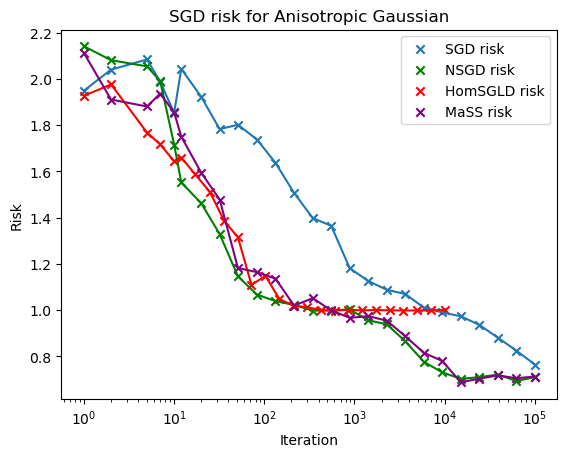

In [51]:
#plot SGD and Nesterov SGD losses
indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(1e5), 20))]
plt.plot(indices, risk_SGD)
plt.scatter(indices, risk_SGD, marker = 'x', label = 'SGD risk')
plt.plot(indices, risk_NSGD, c = 'g')
plt.scatter(indices, risk_NSGD, marker = 'x', label = 'NSGD risk', c = 'g')
indices_Hom = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(1e4), 20))]
plt.plot(indices_Hom, risk_HomSGLD, c = 'r')
plt.scatter(indices_Hom, risk_HomSGLD, marker = 'x', c = 'r', label = 'HomSGLD risk')
plt.plot(indices, risk_Mass, c = 'purple')
plt.scatter(indices, risk_Mass, marker = 'x', c = 'purple', label = 'MaSS risk')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Risk')
plt.legend()
plt.title('SGD risk for Anisotropic Gaussian')

## PDE simulation

In [104]:
from scipy.stats import norm

def q_plus(r1, r2, b, Delta):
    root_plus = np.sqrt((1+Delta)**2*r1**2+r2**2)
    return b*norm.cdf(b/(root_plus))+root_plus*norm.pdf(b/root_plus)

def q_minus(r1, r2, b, Delta):
    root_minus = np.sqrt((1-Delta)**2*r1**2+r2**2)
    return b*norm.cdf(b/(root_minus))+root_minus*norm.pdf(b/root_minus)

def dq_plus(r1, r2, b, Delta):
    from scipy.stats import norm
    d_normal = lambda x: -x*norm.pdf(x)
    
    root_plus = np.sqrt((1+Delta)**2*r1**2+r2**2)
    
    droot_plus_1 = (1+Delta)**2*r1/root_plus
    droot_plus_2 = r2/root_plus
    
    db = norm.cdf(b/(root_plus)) + b/(root_plus)*norm.pdf(b/root_plus) + d_normal(b/root_plus)
    dr1 = -droot_plus_1/(root_plus**2)*b**2*norm.pdf(b/(root_plus))\
                    +droot_plus_1*norm.pdf(b/root_plus)-b*droot_plus_1/(root_plus**2)*d_normal(b/root_plus)
    dr2 = -droot_plus_2/(root_plus**2)*b**2*norm.pdf(b/(root_plus))\
                    +droot_plus_2*norm.pdf(b/root_plus) -b*droot_plus_2/(root_plus**2)*d_normal(b/root_plus)
    return db, dr1, dr2

def dq_minus(r1, r2, b, Delta):
    from scipy.stats import norm
    d_normal = lambda x: -x*norm.pdf(x)
    
    root_minus = np.sqrt((1-Delta)**2*r1**2+r2**2)
    
    droot_minus_1 = (1-Delta)**2*r1/root_minus
    droot_minus_2 = r2/root_minus
    
    db = norm.cdf(b/(root_minus)) + b/(root_minus)*norm.pdf(b/root_minus) + d_normal(b/root_minus)
    dr1 = -droot_minus_1/(root_minus**2)*b**2*norm.pdf(b/(root_minus))\
                    +droot_minus_1*norm.pdf(b/root_minus) - b*droot_minus_1/(root_minus**2)*d_normal(b/root_minus)
    dr2 = -droot_minus_2/(root_minus**2)*b**2*norm.pdf(b/(root_minus))\
                    +droot_minus_2*norm.pdf(b/root_minus) -b*droot_minus_2/(root_minus**2)*d_normal(b/root_minus)
    return db, dr1, dr2

def R_inf(r, Delta):
    #shape of r is (J, 4)
    a = r[:,0]
    b = r[:,1]
    r1 = r[:,2]
    r2 = r[:,3]
    
    plus = a*q_plus(r1, r2, b, Delta)
    minus = a*q_minus(r1, r2, b, Delta)

    mean_q_plus = np.mean(plus)
    mean_q_minus = np.mean(minus)
    return 0.5 * (1 - mean_q_plus) ** 2 + 0.5 * (1 + mean_q_minus) ** 2

def grad_R_inf(r, Delta):
    
    #shape of r: (J, 4)
    #shape of grad: (J, 4)
    
    J = len(r)
    a = r[:,0]
    b = r[:,1]
    r1 = r[:,2]
    r2 = r[:,3]
    
    Q_plus = q_plus(r1, r2, b, Delta)
    Q_minus = q_minus(r1, r2, b, Delta)
    
    plus = a*Q_plus
    minus = a*Q_minus

    mean_q_plus = np.mean(plus)
    mean_q_minus = np.mean(minus)
    
    db_plus, dr1_plus, dr2_plus = dq_plus(r1, r2, b, Delta)
    db_minus, dr1_minus, dr2_minus = dq_minus(r1, r2, b, Delta)
    
    grad = np.zeros((J,4))
    #da
    grad[:,0] = -1/J*Q_plus*(1-mean_q_plus) + 1/J*Q_minus*(1+mean_q_minus)
    #db
    grad[:,1] = -1/J*db_plus*(1-mean_q_plus) + 1/J*db_minus*(1+mean_q_minus)
    #dr1
    grad[:,2] = -1/J*dr1_plus*(1-mean_q_plus) + 1/J*dr1_minus*(1+mean_q_minus)
    #dr2
    grad[:,3] = -1/J*dr2_plus*(1-mean_q_plus) + 1/J*dr2_minus*(1+mean_q_minus)
    
    return grad

In [238]:
#simulate pde
def pde_sim(d = 320, J = 1, epsilon = 2e-4, Delta = 0.2, s_0 = 60):
    Interval = 10**np.linspace(-0,np.log10(epsilon*1e7), int(1e5))
    risk = []
    mean_a = []
    mean_b = []
    mean_r1 = []
    separations = [Interval[k+1]-Interval[k] for k in range(len(Interval)-1)]
    #initialise params
    Z1 = np.random.multivariate_normal([0]*s_0, np.diag([(0.8)**2/d]*s_0), J).reshape(J, s_0)
    Z2 = np.random.multivariate_normal([0]*(d-s_0), np.diag([(0.8)**2/d]*(d-s_0)), J).reshape(J, d-s_0)
    a = np.ones(J).reshape(J,1)
    b = np.ones(J).reshape(J,1)
    r1 = np.linalg.norm(Z1, axis = 1).reshape(J,1)
    r2 = np.linalg.norm(Z2, axis = 1).reshape(J,1)
    r = np.hstack((a,b,r1,r2)).reshape(J,4)

    for k in trange(len(separations)):
        dt = separations[k]
        grad = grad_R_inf(r, Delta)
        r = r - (Interval[k])**(-0.25)* J * grad * dt
        error = R_inf(r, Delta)
        a = r[:,0]
        b = r[:,1]
        r1 = r[:,2]
        mean_a.append(np.mean(a))
        mean_b.append(np.mean(b))
        mean_r1.append(np.mean(r1))
        risk.append(error)
        print(np.mean(a))
    return risk, mean_a, mean_b, mean_r1

In [230]:
weights, risk_SGD, a_SGD, b_SGD, r1_SGD = stochastic_gradient_descent(32, 6, 0.4, 80, epsilon = (2e-4), num_epochs = int(1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 1, a: 0.9996748878135886
Epoch: 2, a: 0.9988861429852776
Epoch: 5, a: 0.9900358099715021
Epoch: 7, a: 0.9847604316748569
Epoch: 10, a: 0.9842643296005594
Epoch: 12, a: 0.9814097776437526
Epoch: 34, a: 0.9553274716672859
Epoch: 92, a: 0.8907948967608329
Epoch: 251, a: 0.7951703105887671
Epoch: 681, a: 0.6827034454315247
Epoch: 1847, a: 0.5687386853246253
Epoch: 5011, a: 0.4679381612344927
Epoch: 13593, a: 0.41622131645454025
Epoch: 36869, a: 0.5263938106677827
Epoch: 100000, a: 1.0752364730299284


In [239]:
pde_risk, mean_a_pde, mean_b_pde, mean_r1_pde = pde_sim(d = 320, J = 400, epsilon = 2e-4, Delta = 0.4, s_0 = 60)

  0%|          | 0/99999 [00:00<?, ?it/s]

0.9998362013390829
0.999672463678433
0.9995087869845777
0.9993451712240694
0.999181616363487
0.9990181223694321
0.9988546892085336
0.9986913168474422
0.9985280052528366
0.9983647543914189
0.9982015642299166
0.9980384347350808
0.9978753658736886
0.9977123576125417
0.9975494099184662
0.9973865227583133
0.9972236960989584
0.9970609299073024
0.9968982241502695
0.9967355787948108
0.9965729938078988
0.9964104691565336
0.9962480048077381
0.9960856007285609
0.9959232568860733
0.9957609732473739
0.9955987497795828
0.9954365864498469
0.9952744832253357
0.9951124400732442
0.9949504569607919
0.9947885338552223
0.9946266707238027
0.9944648675338256
0.9943031242526075
0.9941414408474887
0.9939798172858346
0.9938182535350344
0.9936567495625015
0.9934953053356728
0.9933339208220103
0.9931725959890002
0.9930113308041522
0.9928501252350006
0.992688979249103
0.9925278928140421
0.992366865897424
0.9922058984668787
0.9920449904900599
0.9918841419346465
0.9917233527683403
0.9915626229588664
0.99140195247397

0.9256246747403132
0.9254874761149112
0.925350324541932
0.9252132199978891
0.9250761624593121
0.9249391519027469
0.924802188304755
0.9246652716419146
0.9245284018908185
0.9243915790280768
0.9242548030303155
0.9241180738741758
0.9239813915363152
0.9238447559934073
0.9237081672221413
0.9235716251992221
0.9234351299013716
0.9232986813053256
0.9231622793878378
0.9230259241256763
0.9228896154956263
0.9227533534744873
0.9226171380390754
0.922480969166223
0.9223448468327773
0.9222087710156017
0.922072741691575
0.9219367588375929
0.921800822430565
0.9216649324474179
0.9215290888650941
0.9213932916605504
0.92125754081076
0.9211218362927124
0.9209861780834122
0.9208505661598787
0.9207150004991489
0.9205794810782731
0.920444007874319
0.9203085808643684
0.9201732000255203
0.9200378653348877
0.9199025767695995
0.9197673343068012
0.9196321379236523
0.9194969875973286
0.9193618833050217
0.9192268250239374
0.919091812731298
0.9189568464043415
0.9188219260203203
0.9186870515565028
0.9185522229901726
0.

0.8632619838846304
0.8631454218202991
0.8630288969334504
0.8629124092070865
0.8627959586242211
0.8626795451678777
0.8625631688210912
0.8624468295669067
0.8623305273883798
0.8622142622685778
0.8620980341905776
0.8619818431374671
0.861865689092345
0.8617495720383204
0.8616334919585129
0.8615174488360532
0.8614014426540826
0.861285473395752
0.861169541044224
0.8610536455826717
0.8609377869942781
0.860821965262237
0.8607061803697533
0.8605904323000416
0.8604747210363279
0.8603590465618484
0.8602434088598492
0.8601278079135874
0.8600122437063311
0.8598967162213585
0.859781225441958
0.859665771351429
0.8595503539330803
0.859434973170233
0.8593196290462168
0.8592043215443735
0.8590890506480539
0.8589738163406194
0.8588586186054437
0.8587434574259081
0.8586283327854062
0.8585132446673416
0.8583981930551281
0.8582831779321901
0.8581681992819616
0.8580532570878887
0.8579383513334258
0.8578234820020393
0.8577086490772049
0.8575938525424088
0.8574790923811486
0.8573643685769301
0.8572496811132717


0.8150360081518212
0.8149343933947936
0.8148328092239595
0.8147312556263426
0.8146297325889751
0.8145282400988954
0.814426778143151
0.8143253467087967
0.814223945782894
0.8141225753525131
0.814021235404731
0.8139199259266334
0.8138186469053127
0.8137173983278686
0.8136161801814095
0.8135149924530506
0.8134138351299146
0.8133127081991328
0.8132116116478428
0.8131105454631904
0.8130095096323288
0.812908504142419
0.8128075289806292
0.812706584134136
0.8126056695901215
0.8125047853357776
0.8124039313583029
0.812303107644903
0.8122023141827917
0.8121015509591898
0.8120008179613264
0.811900115176437
0.8117994425917654
0.8116988001945628
0.8115981879720873
0.8114976059116051
0.8113970540003902
0.8112965322257228
0.8111960405748917
0.8110955790351929
0.8109951475939294
0.8108947462384118
0.810794374955959
0.8106940337338961
0.8105937225595564
0.81049344142028
0.8103931903034152
0.8102929691963173
0.8101927780863489
0.8100926169608804
0.8099924858072889
0.8098923846129595
0.8097923133652847
0.8

0.7707938460932663
0.7707051967590249
0.7706165727078513
0.770527973929801
0.7704394004149355
0.770350852153322
0.7702623291350327
0.7701738313501454
0.7700853587887443
0.7699969114409173
0.7699084892967595
0.7698200923463707
0.7697317205798561
0.7696433739873263
0.7695550525588982
0.7694667562846931
0.7693784851548381
0.7692902391594658
0.7692020182887149
0.7691138225327286
0.7690256518816557
0.7689375063256508
0.7688493858548737
0.7687612904594898
0.7686732201296698
0.7685851748555899
0.7684971546274312
0.7684091594353812
0.7683211892696323
0.7682332441203817
0.7681453239778335
0.7680574288321955
0.7679695586736821
0.7678817134925129
0.7677938932789123
0.7677060980231103
0.7676183277153433
0.7675305823458509
0.7674428619048811
0.7673551663826841
0.7672674957695179
0.7671798500556442
0.7670922292313312
0.7670046332868523
0.7669170622124856
0.7668295159985149
0.7667419946352294
0.7666544981129241
0.766567026421898
0.7664795795524573
0.7663921574949117
0.7663047602395775
0.7662173877767

0.7330019213845356
0.7329238071442393
0.7328457141849924
0.7327676424990056
0.7326895920784944
0.7326115629156777
0.7325335550027792
0.7324555683320257
0.7323776028956491
0.7322996586858846
0.7322217356949722
0.7321438339151549
0.7320659533386811
0.7319880939578018
0.7319102557647735
0.7318324387518556
0.7317546429113116
0.7316768682354103
0.7315991147164229
0.7315213823466258
0.7314436711182991
0.7313659810237263
0.7312883120551962
0.7312106642050002
0.7311330374654351
0.7310554318288005
0.7309778472874009
0.7309002838335446
0.7308227414595433
0.7307452201577135
0.7306677199203757
0.730590240739854
0.7305127826084763
0.730435345518575
0.7303579294624867
0.7302805344325511
0.7302031604211128
0.7301258074205197
0.7300484754231243
0.7299711644212826
0.729893874407355
0.7298166053737053
0.7297393573127019
0.7296621302167168
0.7295849240781261
0.72950773888931
0.7294305746426523
0.7293534313305411
0.7292763089453683
0.7291992074795297
0.7291221269254256
0.729045067275459
0.7289680285220388

0.696516562925705
0.6964481778745412
0.696379810675316
0.6963114613219884
0.6962431298085202
0.6961748161288761
0.6961065202770239
0.6960382422469346
0.6959699820325815
0.6959017396279414
0.6958335150269944
0.6957653082237231
0.6956971192121131
0.695628947986153
0.6955607945398344
0.6954926588671522
0.6954245409621038
0.6953564408186896
0.6952883584309135
0.6952202937927818
0.695152246898304
0.6950842177414924
0.6950162063163627
0.6949482126169328
0.6948802366372245
0.6948122783712617
0.6947443378130721
0.6946764149566854
0.6946085097961346
0.6945406223254567
0.6944727525386897
0.6944049004298762
0.6943370659930608
0.6942692492222916
0.6942014501116192
0.6941336686550977
0.6940659048467833
0.6939981586807362
0.6939304301510185
0.6938627192516958
0.6937950259768367
0.6937273503205126
0.6936596922767972
0.6935920518397686
0.6935244290035062
0.6934568237620934
0.6933892361096161
0.6933216660401632
0.6932541135478266
0.6931865786267007
0.6931190612708837
0.6930515614744758
0.69298407923158

0.6681926758088873
0.668131570861402
0.6680704813834315
0.668009407370092
0.6679483488165022
0.6678873057177832
0.6678262780690578
0.6677652658654522
0.6677042691020939
0.6676432877741134
0.667582321876643
0.6675213714048176
0.6674604363537747
0.6673995167186532
0.6673386124945955
0.6672777236767453
0.6672168502602495
0.6671559922402559
0.6670951496119164
0.6670343223703842
0.6669735105108147
0.6669127140283657
0.666851932918198
0.6667911671754738
0.6667304167953577
0.6666696817730174
0.6666089621036219
0.6665482577823428
0.6664875688043547
0.6664268951648333
0.6663662368589577
0.6663055938819085
0.6662449662288688
0.6661843538950245
0.6661237568755628
0.666063175165674
0.6660026087605505
0.6659420576553867
0.6658815218453797
0.6658210013257285
0.6657604960916346
0.6657000061383016
0.6656395314609357
0.6655790720547448
0.6655186279149399
0.6654581990367333
0.6653977854153404
0.6653373870459787
0.6652770039238675
0.6652166360442289
0.6651562834022865
0.6650959459932675
0.665035623812399

0.6425162191080225
0.6424615340438095
0.6424068624917575
0.6423522044478983
0.6422975599082656
0.642242928868895
0.6421883113258237
0.6421337072750913
0.6420791167127384
0.6420245396348082
0.6419699760373453
0.6419154259163957
0.6418608892680087
0.6418063660882334
0.6417518563731224
0.6416973601187291
0.6416428773211093
0.64158840797632
0.6415339520804209
0.6414795096294725
0.641425080619538
0.6413706650466817
0.6413162629069703
0.6412618741964718
0.6412074989112565
0.6411531370473957
0.6410987886009636
0.6410444535680355
0.6409901319446883
0.6409358237270015
0.6408815289110558
0.6408272474929336
0.6407729794687195
0.6407187248344998
0.6406644835863625
0.6406102557203974
0.640556041232696
0.6405018401193519
0.6404476523764603
0.6403934780001178
0.6403393169864238
0.6402851693314784
0.6402310350313841
0.6401769140822453
0.6401228064801675
0.6400687122212588
0.6400146313016282
0.6399605637173875
0.6399065094646496
0.6398524685395293
0.6397984409381432
0.6397444266566099
0.639690425691049

0.619559269321836
0.6195102064699141
0.6194611555379635
0.6194121165227382
0.6193630894209938
0.6193140742294876
0.6192650709449778
0.6192160795642243
0.6191671000839887
0.6191181325010338
0.6190691768121235
0.619020233014024
0.6189713011035021
0.6189223810773268
0.6188734729322679
0.6188245766650969
0.6187756922725868
0.6187268197515121
0.6186779590986486
0.6186291103107737
0.6185802733846657
0.6185314483171053
0.6184826351048736
0.618433833744754
0.618385044233531
0.6183362665679905
0.6182875007449194
0.618238746761107
0.6181900046133435
0.6181412742984204
0.6180925558131309
0.6180438491542694
0.617995154318632
0.6179464713030162
0.6178978001042207
0.6178491407190455
0.6178004931442929
0.6177518573767656
0.617703233413268
0.6176546212506066
0.6176060208855884
0.6175574323150224
0.6175088555357187
0.6174602905444893
0.6174117373381469
0.6173631959135062
0.6173146662673833
0.6172661483965957
0.6172176422979617
0.6171691479683018
0.6171206654044377
0.6170721946031925
0.6170237355613903


0.5972356282157512
0.5971919599592554
0.5971483022141827
0.5971046549779112
0.5970610182478205
0.5970173920212914
0.5969737762957056
0.596930171068446
0.596886576336897
0.5968429920984437
0.5967994183504727
0.5967558550903712
0.5967123023155283
0.5966687600233338
0.5966252282111786
0.5965817068764551
0.5965381960165562
0.5964946956288768
0.5964512057108122
0.5964077262597592
0.5963642572731159
0.596320798748281
0.596277350682655
0.5962339130736388
0.5961904859186352
0.5961470692150478
0.596103662960281
0.596060267151741
0.5960168817868347
0.5959735068629702
0.5959301423775567
0.595886788328005
0.5958434447117262
0.5958001115261333
0.59575678876864
0.5957134764366613
0.5956701745276134
0.5956268830389132
0.5955836019679794
0.5955403313122315
0.5954970710690899
0.5954538212359765
0.5954105818103144
0.595367352789527
0.5953241341710401
0.5952809259522798
0.5952377281306734
0.5951945407036496
0.595151363668638
0.5951081970230693
0.5950650407643755
0.5950218948899897
0.594978759397346
0.594

0.5774376466701535
0.5773987424963151
0.5773598476987086
0.5773209622752088
0.5772820862236917
0.5772432195420335
0.5772043622281118
0.5771655142798049
0.5771266756949924
0.5770878464715545
0.5770490266073723
0.577010216100328
0.5769714149483046
0.5769326231491861
0.5768938407008575
0.5768550676012043
0.5768163038481134
0.5767775494394727
0.5767388043731704
0.5767000686470961
0.5766613422591403
0.5766226252071944
0.5765839174891505
0.5765452191029019
0.5765065300463426
0.5764678503173676
0.5764291799138728
0.5763905188337551
0.5763518670749126
0.5763132246352434
0.5762745915126473
0.576235967705025
0.5761973532102778
0.576158748026308
0.5761201521510189
0.5760815655823146
0.5760429883181003
0.576004420356282
0.5759658616947664
0.5759273123314617
0.5758887722642761
0.5758502414911199
0.5758117200099031
0.5757732078185374
0.5757347049149351
0.5756962112970097
0.5756577269626751
0.5756192519098469
0.5755807861364404
0.575542329640373
0.5755038824195625
0.5754654444719276
0.575427015795387

0.5606382530230141
0.5606034177937343
0.5605685910616868
0.5605337728251297
0.5604989630823223
0.5604641618315245
0.5604293690709972
0.5603945847990015
0.5603598090138
0.5603250417136555
0.5602902828968318
0.5602555325615933
0.5602207907062057
0.5601860573289345
0.5601513324280468
0.56011661600181
0.5600819080484926
0.5600472085663634
0.5600125175536925
0.5599778350087503
0.5599431609298082
0.5599084953151384
0.5598738381630136
0.5598391894717075
0.5598045492394945
0.5597699174646498
0.559735294145449
0.559700679280169
0.5596660728670871
0.5596314749044814
0.5595968853906309
0.5595623043238155
0.559527731702315
0.559493167524411
0.5594586117883853
0.5594240644925206
0.5593895256351005
0.5593549952144088
0.5593204732287306
0.5592859596763518
0.5592514545555585
0.5592169578646381
0.5591824696018785
0.5591479897655683
0.559113518353997
0.5590790553654548
0.5590446007982326
0.559010154650622
0.5589757169209157
0.5589412876074067
0.5589068667083888
0.558872454222157
0.5588380501470064
0.558

0.5457646222453794
0.545733453610897
0.5457022927610535
0.5456711396944214
0.545639994409574
0.5456088569050854
0.54557772717953
0.5455466052314829
0.54551549105952
0.5454843846622179
0.5454532860381535
0.5454221951859044
0.5453911121040492
0.5453600367911667
0.5453289692458366
0.5452979094666393
0.5452668574521553
0.5452358132009664
0.5452047767116546
0.5451737479828027
0.5451427270129942
0.545111713800813
0.5450807083448441
0.5450497106436724
0.5450187206958839
0.5449877385000651
0.5449567640548035
0.5449257973586866
0.5448948384103031
0.5448638872082419
0.5448329437510927
0.5448020080374458
0.5447710800658924
0.5447401598350238
0.5447092473434324
0.5446783425897108
0.5446474455724528
0.5446165562902524
0.5445856747417043
0.5445548009254035
0.5445239348399467
0.5444930764839299
0.5444622258559505
0.5444313829546062
0.544400547778496
0.5443697203262184
0.5443389005963737
0.5443080885875616
0.5442772842983835
0.5442464877274409
0.5442156988733362
0.5441849177346718
0.5441541443100517
0

0.5323935213450969
0.5323657495787286
0.5323379850105876
0.5323102276395106
0.532282477464335
0.5322547344838986
0.53222699869704
0.5321992701025979
0.5321715486994121
0.5321438344863222
0.532116127462169
0.5320884276257934
0.5320607349760372
0.5320330495117424
0.5320053712317516
0.5319777001349081
0.5319500362200555
0.5319223794860383
0.5318947299317008
0.5318670875558889
0.5318394523574477
0.5318118243352242
0.5317842034880651
0.5317565898148175
0.5317289833143298
0.5317013839854502
0.5316737918270278
0.5316462068379121
0.531618629016953
0.5315910583630012
0.5315634948749078
0.5315359385515247
0.5315083893917035
0.5314808473942972
0.5314533125581591
0.5314257848821428
0.5313982643651025
0.5313707510058929
0.5313432448033697
0.5313157457563882
0.5312882538638053
0.5312607691244776
0.5312332915372624
0.5312058211010178
0.5311783578146021
0.5311509016768745
0.5311234526866945
0.5310960108429217
0.531068576144417
0.5310411485900416
0.5310137281786568
0.5309863149091248
0.5309589087803083

0.5205821032752703
0.5205574676142742
0.5205328386778844
0.5205082164651577
0.5204836009751515
0.5204589922069235
0.5204343901595324
0.5204097948320366
0.5203852062234956
0.5203606243329688
0.5203360491595163
0.5203114807021987
0.520286918960077
0.5202623639322126
0.5202378156176671
0.5202132740155033
0.5201887391247837
0.5201642109445713
0.5201396894739302
0.520115174711924
0.5200906666576176
0.5200661653100758
0.520041670668364
0.5200171827315482
0.5199927014986946
0.5199682269688699
0.5199437591411414
0.5199192980145767
0.5198948435882439
0.5198703958612114
0.5198459548325483
0.5198215205013238
0.519797092866608
0.5197726719274711
0.5197482576829837
0.5197238501322172
0.5196994492742429
0.5196750551081332
0.5196506676329602
0.5196262868477973
0.5196019127517174
0.5195775453437946
0.5195531846231031
0.5195288305887175
0.519504483239713
0.5194801425751653
0.5194558085941502
0.5194314812957441
0.5194071606790241
0.5193828467430676
0.5193585394869521
0.5193342389097559
0.519309945010557

0.5099884998542221
0.5099668521698826
0.5099452108223081
0.5099235758107429
0.5099019471344313
0.5098803247926184
0.5098587087845492
0.5098370991094697
0.5098154957666255
0.5097938987552632
0.5097723080746295
0.5097507237239713
0.5097291457025367
0.5097075740095728
0.5096860086443283
0.5096644496060514
0.5096428968939917
0.5096213505073979
0.50959981044552
0.509578276707608
0.5095567492929125
0.5095352282006842
0.509513713430174
0.509492204980634
0.5094707028513157
0.5094492070414716
0.5094277175503542
0.5094062343772169
0.5093847575213125
0.5093632869818951
0.5093418227582189
0.5093203648495384
0.5092989132551083
0.509277467974184
0.509256029006021
0.5092345963498753
0.5092131700050032
0.5091917499706615
0.5091703362461072
0.5091489288305977
0.5091275277233911
0.5091061329237451
0.5090847444309186
0.5090633622441701
0.5090419863627595
0.509020616785946
0.5089992535129898
0.508977896543151
0.5089565458756905
0.5089352015098696
0.5089138634449494
0.5088925316801919
0.5088712062148593
0.

0.5009330527691152
0.5009141675301457
0.5008952883249588
0.5008764151529499
0.5008575480135153
0.5008386869060513
0.5008198318299545
0.5008009827846216
0.5007821397694502
0.5007633027838375
0.5007444718271814
0.5007256468988802
0.5007068279983325
0.5006880151249367
0.500669208278092
0.5006504074571978
0.5006316126616538
0.50061282389086
0.5005940411442166
0.5005752644211242
0.5005564937209838
0.5005377290431964
0.5005189703871636
0.5005002177522875
0.5004814711379696
0.5004627305436129
0.5004439959686199
0.5004252674123935
0.5004065448743371
0.5003878283538544
0.5003691178503493
0.5003504133632259
0.500331714891889
0.5003130224357433
0.5002943359941939
0.5002756555666464
0.5002569811525064
0.5002383127511798
0.5002196503620734
0.5002009939845934
0.500182343618147
0.5001636992621413
0.5001450609159841
0.5001264285790831
0.5001078022508465
0.5000891819306825
0.5000705676180004
0.5000519593122088
0.5000333570127173
0.5000147607189354
0.4999961704302731
0.4999775861461409
0.499959007865949

0.493279733064073
0.4932634194505818
0.49324711163505414
0.4932308096170058
0.4932145133959533
0.49319822297141286
0.49318193834290147
0.4931656595099359
0.4931493864720335
0.4931331192287118
0.49311685777948844
0.49310060212388135
0.49308435226140884
0.4930681081915894
0.4930518699139417
0.4930356374279845
0.4930194107332372
0.4930031898292192
0.49298697471545033
0.49297076539145024
0.49295456185673936
0.49293836411083797
0.4929221721532667
0.4929059859835466
0.49288980560119877
0.49287363100574455
0.49285746219670556
0.4928412991736038
0.4928251419359613
0.49280899048330057
0.49279284481514396
0.4927767049310146
0.49276057083043556
0.4927444425129299
0.4927283199780215
0.4927122032252341
0.4926960922540917
0.49267998706411875
0.49266388765483965
0.4926477940257794
0.4926317061764628
0.4926156241064154
0.4925995478151624
0.4925834773022298
0.4925674125671435
0.49255135360942986
0.49253530042861515
0.49251925302422633
0.4925032113957901
0.4924871755428341
0.4924711454648854
0.492455121

0.4865449567035464
0.486531195564482
0.4865174400292436
0.48650369009744454
0.4864899457686978
0.4864762070426171
0.48646247391881586
0.4864487463969078
0.48643502447650716
0.4864213081572279
0.48640759743868445
0.4863938923204912
0.4863801928022631
0.4863664988836149
0.4863528105641619
0.4863391278435192
0.4863254507213022
0.4863117791971268
0.4862981132706086
0.48628445294136385
0.4862707982090085
0.4862571490731591
0.4862435055334322
0.4862298675894446
0.48621623524081314
0.486202608487155
0.4861889873280875
0.4861753717632282
0.4861617617921945
0.4861481574146046
0.48613455863007643
0.48612096543822814
0.48610737783867825
0.4860937958310453
0.486080219414948
0.4860666485900055
0.4860530833558366
0.48603952371206094
0.4860259696582979
0.4860124211941671
0.4859988783192887
0.48598534103328234
0.4859718093357685
0.4859582832263677
0.4859447627047003
0.4859312477703871
0.4859177384230492
0.4859042346623076
0.4858907364877837
0.4858772438990989
0.48586375689587497
0.48585027547773385
0.

0.4809694891154054
0.4809581859626425
0.48094688825803206
0.4809355960012571
0.480924309192001
0.4809130278299473
0.48090175191477924
0.48089048144618063
0.4808792164238352
0.48086795684742684
0.48085670271663955
0.4808454540311577
0.48083421079066524
0.4808229729948468
0.48081174064338694
0.4808005137359702
0.4807892922722815
0.4807780762520057
0.4807668656748278
0.48075566054043306
0.48074446084850686
0.4807332665987344
0.4807220777908013
0.48071089442439346
0.48069971649919635
0.48068854401489625
0.4806773769711789
0.4806662153677307
0.4806550592042379
0.48064390848038696
0.48063276319586423
0.48062162335035663
0.480610488943551
0.4805993599751342
0.4805882364447932
0.4805771183522151
0.4805660056970876
0.48055489847909777
0.4805437966979333
0.4805327003532819
0.48052160944483124
0.4805105239722694
0.4804994439352843
0.48048836933356426
0.4804773001667975
0.48046623643467257
0.48045517813687766
0.4804441252731019
0.48043307784303374
0.48042203584636217
0.4804109992827763
0.480399968

0.4759568729945325
0.4759482779359633
0.47593968817946547
0.47593110372477115
0.47592252457161244
0.4759139507197214
0.4759053821688304
0.4758968189186718
0.47588826096897796
0.4758797083194812
0.4758711609699144
0.47586261892000964
0.4758540821695
0.47584555071811807
0.47583702456559657
0.4758285037116684
0.4758199881560664
0.47581147789852374
0.47580297293877327
0.4757944732765483
0.47578597891158175
0.475777489843607
0.47576900607235745
0.47576052759756626
0.475752054418967
0.4757435865362932
0.4757351239492783
0.47572666665765595
0.47571821466115993
0.4757097679595239
0.47570132655248165
0.47569289043976726
0.4756844596211144
0.4756760340962572
0.47566761386492984
0.4756591989268662
0.47565078928180066
0.4756423849294674
0.47563398586960093
0.4756255921019353
0.4756172036262052
0.4756088204421449
0.47560044254948936
0.47559206994797293
0.47558370263733024
0.4755753406172963
0.4755669838876056
0.47555863244799323
0.4755502862981942
0.47554194543794337
0.47553360986697585
0.475525279

0.47267086097755817
0.47266458409386863
0.4726583123986961
0.4726520458917912
0.4726457845729047
0.4726395284417871
0.4726332774981891
0.4726270317418617
0.4726207911725554
0.4726145557900209
0.4726083255940091
0.47260210058427066
0.4725958807605566
0.47258966612261744
0.47258345667020435
0.47257725240306797
0.4725710533209593
0.4725648594236291
0.4725586707108283
0.472552487182308
0.472546308837819
0.4725401356771123
0.47253396769993883
0.4725278049060496
0.47252164729519563
0.4725154948671281
0.47250934762159785
0.472503205558356
0.47249706867715374
0.4724909369777421
0.47248481045987206
0.47247868912329494
0.47247257296776174
0.4724664619930238
0.47246035619883203
0.47245425558493787
0.47244816015109237
0.47244206989704696
0.4724359848225525
0.47242990492736064
0.47242383021122253
0.47241776067388924
0.47241169631511243
0.4724056371346431
0.4723995831322327
0.4723935343076326
0.4723874906605942
0.47238145219086874
0.47237541889820767
0.47236939078236256
0.47236336784308447
0.4723573

0.4703548025249901
0.4703508506360944
0.4703469038232421
0.4703429620861836
0.4703390254246681
0.4703350938384459
0.4703311673272662
0.470327245890879
0.47032332952903394
0.4703194182414807
0.47031551202796884
0.470311610888248
0.4703077148220678
0.4703038238291778
0.47029993790932756
0.4702960570622667
0.47029218128774447
0.4702883105855106
0.47028444495531446
0.47028058439690557
0.4702767289100332
0.47027287849444677
0.4702690331498958
0.4702651928761295
0.47026135767289723
0.47025752753994843
0.47025370247703224
0.4702498824838979
0.4702460675602947
0.47024225770597183
0.4702384529206786
0.4702346532041641
0.47023085855617736
0.47022706897646765
0.47022328446478395
0.4702195050208756
0.4702157306444914
0.4702119613353804
0.47020819709329176
0.47020443791797417
0.4702006838091769
0.4701969347666489
0.47019319079013877
0.4701894518793956
0.4701857180341682
0.4701819892542055
0.47017826553925623
0.4701745468890692
0.4701708333033931
0.47016712478197675
0.470163421324569
0.4701597229309

0.4691026451690725
0.4691009021632759
0.46909916412035785
0.469097431040052
0.46909570292209163
0.46909397976621003
0.4690922615721405
0.4690905483396163
0.4690888400683704
0.469087136758136
0.4690854384086463
0.469083745019634
0.46908205659083224
0.4690803731219738
0.46907869461279156
0.46907702106301824
0.4690753524723867
0.46907368884062933
0.46907203016747895
0.46907037645266797
0.4690687276959291
0.4690670838969945
0.4690654450555967
0.46906381117146806
0.4690621822443408
0.4690605582739471
0.4690589392600193
0.4690573252022892
0.4690557161004891
0.4690541119543509
0.46905251276360665
0.469050918527988
0.46904932924722703
0.46904774492105533
0.4690461655492046
0.4690445911314066
0.46904302166739287
0.4690414571568951
0.46903989759964454
0.46903834299537267
0.46903679334381093
0.46903524864469076
0.4690337088977432
0.4690321741026995
0.4690306442592908
0.4690291193672482
0.46902759942630284
0.46902608443618554
0.46902457439662726
0.4690230693073588
0.4690215691681111
0.469020073978

0.4688208914751998
0.4688214070198204
0.46882192739692646
0.4688224526062153
0.4688229826473841
0.4688235175201298
0.4688240572241495
0.46882460175914004
0.4688251511247984
0.46882570532082113
0.46882626434690516
0.468826828202747
0.4688273968880435
0.46882797040249086
0.4688285487457858
0.46882913191762454
0.4688297199177036
0.4688303127457192
0.4688309104013677
0.46883151288434505
0.46883212019434756
0.46883273233107126
0.46883334929421216
0.46883397108346636
0.46883459769852964
0.46883522913909786
0.46883586540486705
0.4688365064955328
0.46883715241079116
0.46883780315033746
0.46883845871386753
0.4688391191010771
0.4688397843116618
0.468840454345317
0.4688411292017384
0.4688418088806214
0.46884249338166156
0.4688431827045544
0.4688438768489949
0.46884457581467914
0.46884527960130207
0.46884598820855916
0.46884670163614556
0.46884741988375694
0.4688481429510884
0.4688488708378353
0.4688496035436929
0.4688503410683565
0.4688510834115214
0.4688518305728828
0.4688525825521361
0.46885333

0.46952349532287785
0.46952613350054434
0.46952877638866225
0.4695314239869397
0.4695340762950842
0.46953673331280316
0.4695393950398038
0.46954206147579325
0.46954473262047836
0.46954740847356574
0.4695500890347619
0.46955277430377307
0.46955546428030553
0.469558158964065
0.4695608583547572
0.4695635624520878
0.46956627125576206
0.4695689847654853
0.46957170298096246
0.4695744259018983
0.4695771535279976
0.4695798858589649
0.4695826228945045
0.4695853646343205
0.469588111078117
0.4695908622255979
0.4695936180764667
0.46959637863042714
0.4695991438871826
0.46960191384643607
0.4696046885078909
0.46960746787124985
0.46961025193621575
0.4696130407024912
0.46961583416977876
0.46961863233778073
0.4696214352061992
0.46962424277473636
0.4696270550430941
0.46962987201097434
0.4696326936780784
0.4696355200441081
0.4696383511087646
0.4696411868717493
0.46964402733276345
0.4696468724915077
0.4696497223476831
0.46965257690099044
0.46965543615113037
0.4696583000978032
0.4696611687407094
0.469664042

0.4712918488378013
0.4712966809221502
0.4713015175706531
0.47130635878299243
0.47131120455885067
0.47131605489791023
0.4713209097998536
0.47132576926436315
0.47133063329112135
0.47133550187981044
0.47134037503011295
0.4713452527417108
0.47135013501428674
0.4713550218475228
0.47135991324110127
0.4713648091947044
0.47136970970801434
0.4713746147807133
0.4713795244124833
0.47138443860300666
0.47138935735196547
0.47139428065904176
0.47139920852391753
0.47140414094627486
0.47140907792579595
0.47141401946216255
0.4714189655550567
0.47142391620416035
0.47142887140915546
0.47143383116972404
0.47143879548554773
0.47144376435630847
0.4714487377816883
0.4714537157613688
0.47145869829503184
0.47146368538235917
0.4714686770230325
0.47147367321673384
0.4714786739631446
0.4714836792619465
0.4714886891128212
0.47149370351545045
0.4714987224695159
0.47150374597469885
0.4715087740306812
0.4715138066371443
0.47151884379376985
0.47152388550023927
0.47152893175623406
0.4715339825614356
0.4715390379155254
0

0.4737931794406211
0.4737999490067179
0.47380672299854554
0.47381350141578077
0.4738202842580999
0.47382707152517967
0.47383386321669646
0.473840659332327
0.47384745987174753
0.4738542648346348
0.47386107422066515
0.4738678880295153
0.47387470626086164
0.4738815289143806
0.47388835598974877
0.47389518748664267
0.4739020234047387
0.47390886374371344
0.4739157085032433
0.47392255768300484
0.4739294112826745
0.4739362693019288
0.4739431317404441
0.473949998597897
0.4739568698739639
0.47396374556832116
0.4739706256806454
0.47397751021061313
0.47398439915790047
0.4739912925221843
0.4739981903031408
0.4740050925004465
0.4740119991137777
0.4740189101428111
0.47402582558722295
0.47403274544668966
0.4740396697208878
0.47404659840949365
0.4740535315121837
0.47406046902863447
0.4740674109585221
0.4740743573015233
0.47408130805731447
0.47408826322557174
0.4740952228059718
0.47410218679819094
0.47410915520190555
0.47411612801679204
0.4741231052425269
0.47413008687878644
0.47413707292524704
0.474144

0.4774747187902819
0.47748354104609236
0.4774923675649865
0.4775011983466307
0.47751003339069087
0.47751887269683296
0.47752771626472296
0.47753656409402645
0.477545416184409
0.47755427253553606
0.4775631331470731
0.4775719980186852
0.47758086715003756
0.47758974054079517
0.4775986181906231
0.4776075000991861
0.4776163862661489
0.4776252766911762
0.4776341713739326
0.47764307031408243
0.4776519735112902
0.4776608809652203
0.4776697926755368
0.477678708641904
0.4776876288639859
0.4776965533414465
0.4777054820739498
0.47771441506115975
0.47772335230273993
0.4777322937983543
0.47774123954766634
0.47775018955034
0.47775914380603834
0.47776810231442524
0.47777706507516404
0.47778603208791814
0.4777950033523507
0.4778039788681251
0.47781295863490447
0.47782194265235217
0.4778309309201311
0.47783992343790443
0.47784892020533504
0.4778579212220859
0.47786692648782003
0.47787593600220013
0.47788494976488916
0.47789396777554977
0.4779029900338446
0.47791201653943655
0.477921047291988
0.477930082

0.48224739350900464
0.48225824358856983
0.4822690977741024
0.4822799560652914
0.4822908184618263
0.4823016849633964
0.48231255556969105
0.4823234302803995
0.48233430909521124
0.48234519201381576
0.48235607903590233
0.48236697016116054
0.4823778653892799
0.48238876471994985
0.4823996681528601
0.48241057568769996
0.4824214873241591
0.4824324030619275
0.48244332290069425
0.4824542468401494
0.4824651748799825
0.48247610701988336
0.48248704325954167
0.48249798359864726
0.48250892803688983
0.4825198765739592
0.4825308292095454
0.48254178594333824
0.48255274677502746
0.4825637117043032
0.48257468073085535
0.4825856538543738
0.48259663107454875
0.48260761239107
0.48261859780362776
0.482629587311912
0.48264058091561296
0.48265157861442076
0.48266258040802557
0.4826735862961174
0.48268459627838667
0.4826956103545236
0.4827066285242182
0.48271765078716117
0.4827286771430424
0.4827397075915527
0.482750742132382
0.482761780765221
0.4827728234897599
0.48278387030568937
0.4827949212126997
0.482805976

0.48776870096299824
0.48778143913952077
0.4877941812796109
0.48780692738297143
0.4878196774493048
0.487832431478314
0.48784518946970157
0.48785795142317057
0.4878707173384237
0.4878834872151637
0.4878962610530937
0.4879090388519164
0.4879218206113347
0.4879346063310519
0.48794739601077075
0.48796018965019444
0.48797298724902577
0.48798578880696825
0.48799859432372467
0.48801140379899843
0.4880242172324927
0.48803703462391046
0.48804985597295525
0.4880626812793303
0.48807551054273896
0.48808834376288446
0.48810118093947025
0.48811402207219984
0.4881268671607765
0.48813971620490376
0.4881525692042853
0.48816542615862457
0.48817828706762506
0.4881911519309904
0.48820402074842434
0.4882168935196303
0.4882297702443122
0.4882426509221738
0.4882555355529188
0.4882684241362508
0.4882813166718739
0.48829421315949184
0.4883071135988085
0.48832001798952773
0.48833292633135356
0.48834583862399017
0.48835875486714114
0.4883716750605109
0.4883845992038033
0.4883975272967224
0.48841045933897265
0.488

0.4942457378839181
0.4942603220174061
0.49427490997707724
0.4942895017626491
0.4943040973738394
0.4943186968103661
0.4943333000719469
0.4943479071582999
0.49436251806914266
0.4943771328041933
0.49439175136316976
0.49440637374579
0.49442099995177197
0.4944356299808338
0.4944502638326935
0.49446490150706934
0.49447954300367924
0.4944941883222417
0.49450883746247454
0.4945234904240962
0.49453814720682504
0.49455280781037914
0.494567472234477
0.4945821404788369
0.49459681254317744
0.4946114884272167
0.49462616813067334
0.49464085165326593
0.4946555389947129
0.4946702301547327
0.4946849251330442
0.4946996239293657
0.49471432654341607
0.494729032974914
0.49474374322357806
0.49475845728912704
0.4947731751712797
0.49478789686975505
0.49480262238427164
0.4948173517145485
0.4948320848603045
0.49484682182125866
0.4948615625971298
0.4948763071876372
0.4948910555924995
0.49490580781143606
0.4949205638441657
0.4949353236904079
0.49495008734988155
0.49496485482230596
0.49497962610740026
0.49499440120

0.5012072105234897
0.5012234920978641
0.5012397773742763
0.5012560663524573
0.5012723590321394
0.5012886554130537
0.501304955494932
0.5013212592775063
0.5013375667605079
0.5013538779436688
0.5013701928267207
0.5013865114093954
0.5014028336914247
0.5014191596725407
0.501435489352475
0.5014518227309596
0.5014681598077264
0.5014845005825076
0.5015008450550351
0.501517193225041
0.5015335450922572
0.5015499006564158
0.5015662599172492
0.5015826228744893
0.5015989895278685
0.5016153598771187
0.5016317339219724
0.5016481116621618
0.5016644930974193
0.5016808782274772
0.5016972670520676
0.5017136595709233
0.5017300557837764
0.5017464556903595
0.501762859290405
0.5017792665836455
0.5017956775698135
0.5018120922486414
0.5018285106198621
0.5018449326832081
0.501861358438412
0.5018777878852064
0.5018942210233241
0.5019106578524979
0.5019270983724606
0.5019435425829448
0.5019599904836834
0.5019764420744095
0.5019928973548555
0.5020093563247547
0.50202581898384
0.5020422853318443
0.5020587553685005


0.5091012417277373
0.5091192019392864
0.5091371657320927
0.5091551331059005
0.509173104060454
0.5091910785954973
0.5092090567107747
0.5092270384060302
0.5092450236810084
0.5092630125354535
0.5092810049691097
0.5092990009817213
0.5093170005730329
0.5093350037427886
0.5093530104907331
0.5093710208166108
0.5093890347201658
0.5094070522011431
0.509425073259287
0.509443097894342
0.5094611261060524
0.5094791578941634
0.5094971932584192
0.5095152321985645
0.5095332747143441
0.5095513208055025
0.5095693704717845
0.5095874237129349
0.5096054805286983
0.5096235409188197
0.5096416048830438
0.5096596724211153
0.5096777435327793
0.5096958182177806
0.5097138964758642
0.5097319783067749
0.5097500637102576
0.5097681526860576
0.5097862452339196
0.5098043413535888
0.5098224410448101
0.5098405443073288
0.5098586511408899
0.5098767615452385
0.5098948755201199
0.509912993065279
0.5099311141804614
0.5099492388654121
0.5099673671198766
0.5099854989435996
0.510003634336327
0.5100217732978038
0.510039915827775

0.5181881718928537
0.5182078325149592
0.5182274965974772
0.518247164140163
0.5182668351427718
0.5182865096050587
0.5183061875267786
0.5183258689076871
0.518345553747539
0.5183652420460898
0.5183849338030946
0.5184046290183089
0.5184243276914876
0.5184440298223862
0.5184637354107603
0.5184834444563647
0.5185031569589553
0.518522872918287
0.5185425923341157
0.5185623152061963
0.5185820415342848
0.5186017713181361
0.5186215045575062
0.5186412412521503
0.518660981401824
0.5186807250062828
0.5187004720652825
0.5187202225785784
0.5187399765459262
0.5187597339670815
0.5187794948418001
0.5187992591698375
0.5188190269509495
0.5188387981848916
0.5188585728714198
0.5188783510102897
0.5188981326012572
0.5189179176440778
0.5189377061385074
0.5189574980843022
0.5189772934812177
0.5189970923290099
0.5190168946274344
0.5190367003762475
0.5190565095752049
0.5190763222240626
0.5190961383225765
0.5191159578705027
0.5191357808675972
0.519155607313616
0.519175437208315
0.5191952705514504
0.5192151073427785

0.5283383944804038
0.5283597384484773
0.5283810857580289
0.5284024364088229
0.5284237904006234
0.5284451477331941
0.528466508406299
0.5284878724197025
0.5285092397731687
0.5285306104664612
0.5285519844993446
0.5285733618715828
0.5285947425829398
0.5286161266331802
0.5286375140220677
0.5286589047493667
0.5286802988148415
0.5287016962182561
0.5287230969593749
0.5287445010379621
0.5287659084537818
0.5287873192065985
0.5288087332961763
0.5288301507222797
0.5288515714846729
0.5288729955831202
0.5288944230173861
0.5289158537872349
0.5289372878924311
0.5289587253327389
0.5289801661079229
0.5290016102177472
0.5290230576619767
0.5290445084403756
0.5290659625527085
0.5290874199987399
0.529108880778234
0.5291303448909558
0.5291518123366695
0.5291732831151398
0.5291947572261312
0.5292162346694083
0.5292377154447359
0.5292591995518783
0.5292806869906004
0.5293021777606666
0.5293236718618418
0.5293451692938905
0.5293666700565776
0.5293881741496677
0.5294096815729255
0.5294311923261155
0.529452706409

0.5387114273511012
0.5387343128247204
0.5387572015307219
0.5387800934688767
0.5388029886389547
0.538825887040727
0.5388487886739639
0.5388716935384359
0.5388946016339138
0.5389175129601678
0.5389404275169689
0.5389633453040874
0.5389862663212942
0.5390091905683597
0.5390321180450548
0.53905504875115
0.5390779826864157
0.5391009198506231
0.5391238602435426
0.539146803864945
0.5391697507146008
0.5391927007922811
0.5392156540977564
0.5392386106307974
0.5392615703911752
0.53928453337866
0.5393074995930233
0.5393304690340354
0.5393534417014673
0.5393764175950896
0.5393993967146735
0.5394223790599897
0.5394453646308089
0.5394683534269022
0.5394913454480403
0.5395143406939945
0.5395373391645352
0.5395603408594334
0.5395833457784603
0.5396063539213869
0.5396293652879838
0.5396523798780221
0.5396753976912728
0.539698418727507
0.5397214429864957
0.5397444704680098
0.5397675011718203
0.5397905350976984
0.5398135722454152
0.5398366126147414
0.5398596562054484
0.5398827030173072
0.5399057530500888


0.5498686968748655
0.5498930827234549
0.5499174716973553
0.5499418637963425
0.5499662590201918
0.5499906573686788
0.5500150588415795
0.5500394634386694
0.5500638711597239
0.5500882820045189
0.5501126959728301
0.5501371130644328
0.5501615332791031
0.5501859566166165
0.5502103830767487
0.5502348126592754
0.5502592453639724
0.5502836811906154
0.55030812013898
0.5503325622088421
0.5503570073999774
0.5503814557121618
0.5504059071451709
0.5504303616987805
0.5504548193727663
0.5504792801669045
0.5505037440809705
0.5505282111147403
0.5505526812679896
0.5505771545404944
0.5506016309320306
0.5506261104423739
0.5506505930713002
0.5506750788185851
0.5506995676840052
0.5507240596673358
0.550748554768353
0.5507730529868327
0.5507975543225507
0.5508220587752832
0.550846566344806
0.550871077030895
0.5508955908333263
0.5509201077518757
0.5509446277863193
0.550969150936433
0.5509936772019928
0.5510182065827748
0.551042739078555
0.5510672746891094
0.5510918134142142
0.5511163552536451
0.5511409002071784


0.5611289265002557
0.5611546931788641
0.5611804628829175
0.5612062356121954
0.5612320113664774
0.5612577901455428
0.5612835719491711
0.5613093567771419
0.5613351446292346
0.5613609355052287
0.5613867294049038
0.5614125263280392
0.5614383262744146
0.5614641292438094
0.5614899352360033
0.5615157442507757
0.5615415562879063
0.5615673713471745
0.5615931894283598
0.561619010531242
0.5616448346556006
0.5616706618012152
0.5616964919678652
0.5617223251553305
0.5617481613633906
0.5617740005918251
0.5617998428404136
0.5618256881089359
0.5618515363971713
0.5618773877048997
0.5619032420319009
0.5619290993779542
0.5619549597428396
0.5619808231263366
0.562006689528225
0.5620325589482843
0.5620584313862944
0.5620843068420349
0.5621101853152858
0.5621360668058263
0.5621619513134365
0.5621878388378962
0.5622137293789851
0.5622396229364829
0.5622655195101691
0.5622914190998238
0.5623173217052269
0.5623432273261579
0.5623691359623968
0.5623950476137233
0.5624209622799171
0.5624468799607583
0.562472800656

0.5739495063163386
0.5739767116719734
0.5740039199471734
0.5740311311417218
0.5740583452554013
0.5740855622879951
0.5741127822392862
0.5741400051090574
0.5741672308970918
0.5741944596031724
0.5742216912270822
0.5742489257686043
0.5742761632275217
0.5743034036036171
0.574330646896674
0.5743578931064753
0.5743851422328039
0.5744123942754432
0.5744396492341758
0.5744669071087851
0.5744941678990542
0.574521431604766
0.5745486982257034
0.5745759677616501
0.5746032402123887
0.5746305155777024
0.5746577938573746
0.574685075051188
0.5747123591589262
0.574739646180372
0.5747669361153086
0.5747942289635192
0.574821524724787
0.5748488233988952
0.5748761249856267
0.574903429484765
0.5749307368960931
0.5749580472193944
0.5749853604544518
0.5750126766010488
0.5750399956589685
0.575067317627994
0.5750946425079086
0.5751219702984957
0.5751493009995383
0.5751766346108198
0.5752039711321235
0.5752313105632325
0.5752586529039302
0.5752859981539997
0.5753133463132246
0.5753406973813879
0.575368051358273
0

0.5873969162469963
0.5874255037994446
0.5874540941676291
0.587482687351336
0.5875112833503517
0.5875398821644622
0.5875684837934538
0.5875970882371128
0.5876256954952254
0.5876543055675776
0.5876829184539561
0.5877115341541469
0.5877401526679363
0.5877687739951107
0.5877973981354563
0.5878260250887596
0.5878546548548063
0.5878832874333833
0.5879119228242766
0.5879405610272727
0.5879692020421577
0.5879978458687183
0.5880264925067406
0.5880551419560107
0.5880837942163154
0.588112449287441
0.5881411071691736
0.5881697678612997
0.588198431363606
0.5882270976758781
0.588255766797903
0.5882844387294672
0.5883131134703566
0.5883417910203582
0.5883704713792579
0.5883991545468426
0.5884278405228982
0.5884565293072116
0.5884852208995689
0.5885139152997567
0.5885426125075616
0.5885713125227698
0.5886000153451683
0.5886287209745429
0.5886574294106804
0.5886861406533673
0.5887148547023903
0.5887435715575353
0.5887722912185894
0.588801013685339
0.5888297389575705
0.5888584670350706
0.588887197917625

0.6008410145772783
0.6008708749091426
0.6009007379591285
0.6009306037270256
0.600960472212623
0.6009903434157104
0.6010202173360772
0.601050093973513
0.6010799733278072
0.6011098553987491
0.6011397401861283
0.6011696276897343
0.6011995179093566
0.6012294108447847
0.6012593064958079
0.6012892048622163
0.6013191059437988
0.6013490097403453
0.6013789162516452
0.601408825477488
0.6014387374176634
0.6014686520719609
0.60149856944017
0.6015284895220805
0.6015584123174819
0.6015883378261635
0.6016182660479152
0.6016481969825266
0.6016781306297871
0.6017080669894866
0.6017380060614146
0.6017679478453608
0.6017978923411147
0.6018278395484663
0.6018577894672047
0.6018877420971199
0.6019176974380016
0.6019476554896396
0.6019776162518232
0.6020075797243423
0.6020375459069868
0.602067514799546
0.6020974864018102
0.6021274607135685
0.6021574377346112
0.6021874174647275
0.6022173999037076
0.6022473850513408
0.6022773729074173
0.6023073634717268
0.6023373567440589
0.6023673527242034
0.6023973514119502

0.6147981702597075
0.6148292535757293
0.6148603395142388
0.6148914280750292
0.6149225192578934
0.6149536130626246
0.614984709489016
0.6150158085368602
0.6150469102059509
0.6150780144960808
0.6151091214070431
0.615140230938631
0.6151713430906375
0.615202457862856
0.6152335752550794
0.615264695267101
0.6152958178987137
0.615326943149711
0.6153580710198859
0.6153892015090316
0.6154203346169415
0.6154514703434084
0.6154826086882259
0.615513749651187
0.615544893232085
0.6155760394307133
0.6156071882468649
0.6156383396803331
0.6156694937309113
0.6157006503983928
0.6157318096825706
0.6157629715832384
0.6157941361001892
0.6158253032332164
0.6158564729821133
0.6158876453466732
0.6159188203266894
0.6159499979219555
0.6159811781322645
0.6160123609574102
0.6160435463971855
0.6160747344513839
0.6161059251197991
0.6161371184022243
0.6161683142984529
0.616199512808278
0.6162307139314938
0.6162619176678927
0.6162931240172691
0.6163243329794159
0.6163555445541268
0.616386758741195
0.6164179755404142
0.

0.6287896419361045
0.6288218643499905
0.6288540892957764
0.6288863167732589
0.6289185467822358
0.6289507793225038
0.6289830143938605
0.6290152519961026
0.6290474921290281
0.6290797347924336
0.6291119799861166
0.6291442277098743
0.629176477963504
0.629208730746803
0.6292409860595685
0.6292732439015978
0.6293055042726884
0.6293377671726375
0.6293700326012421
0.6294023005583
0.6294345710436086
0.6294668440569647
0.6294991195981664
0.6295313976670106
0.6295636782632948
0.6295959613868163
0.6296282470373726
0.6296605352147613
0.6296928259187797
0.629725119149225
0.6297574149058949
0.629789713188587
0.6298220139970985
0.6298543173312271
0.6298866231907699
0.6299189315755249
0.6299512424852893
0.629983555919861
0.630015871879037
0.6300481903626151
0.630080511370393
0.6301128349021681
0.630145160957738
0.6301774895369002
0.6302098206394525
0.6302421542651924
0.6302744904139175
0.6303068290854255
0.6303391702795138
0.6303715139959805
0.6304038602346228
0.6304362089952388
0.6304685602776257
0.63

0.6432425082563694
0.6432758277114564
0.643309149610048
0.6433424739519468
0.6433758007369544
0.6434091299648734
0.6434424616355057
0.6434757957486537
0.6435091323041189
0.6435424713017039
0.6435758127412111
0.6436091566224426
0.6436425029452004
0.6436758517092868
0.6437092029145042
0.6437425565606545
0.6437759126475402
0.6438092711749636
0.6438426321427266
0.6438759955506321
0.6439093613984822
0.6439427296860789
0.6439761004132251
0.6440094735797226
0.6440428491853737
0.6440762272299814
0.6441096077133476
0.6441429906352748
0.6441763759955654
0.6442097637940217
0.6442431540304463
0.6442765467046417
0.6443099418164104
0.6443433393655544
0.6443767393518768
0.6444101417751795
0.6444435466352657
0.6444769539319373
0.6445103636649968
0.6445437758342472
0.6445771904394908
0.6446106074805303
0.6446440269571678
0.6446774488692069
0.6447108732164492
0.6447442999986976
0.6447777292157549
0.6448111608674236
0.6448445949535067
0.6448780314738062
0.6449114704281255
0.6449449118162667
0.64497835563

0.6591341418868167
0.6591685858453101
0.6592030321559185
0.6592374808184505
0.6592719318327142
0.6593063851985183
0.6593408409156711
0.6593752989839811
0.6594097594032565
0.6594442221733061
0.6594786872939384
0.6595131547649618
0.6595476245861847
0.6595820967574157
0.6596165712784635
0.6596510481491364
0.6596855273692432
0.6597200089385923
0.6597544928569925
0.6597889791242524
0.6598234677401804
0.6598579587045854
0.6598924520172759
0.6599269476780608
0.6599614456867485
0.6599959460431483
0.6600304487470678
0.6600649537983171
0.6600994611967039
0.6601339709420373
0.6601684830341261
0.6602029974727793
0.6602375142578056
0.6602720333890136
0.6603065548662124
0.6603410786892107
0.6603756048578175
0.6604101333718415
0.6604446642310918
0.6604791974353773
0.660513732984507
0.6605482708782895
0.660582811116534
0.6606173536990495
0.660651898625645
0.6606864458961295
0.6607209955103117
0.6607555474680011
0.6607901017690065
0.6608246584131371
0.6608592174002018
0.6608937787300097
0.6609283424023

0.6750106271440205
0.6750461194956846
0.6750816141140649
0.6751171109989769
0.6751526101502361
0.6751881115676587
0.6752236152510598
0.6752591212002553
0.6752946294150611
0.6753301398952928
0.6753656526407659
0.6754011676512964
0.6754366849267001
0.6754722044667926
0.6755077262713898
0.6755432503403075
0.675578776673362
0.6756143052703684
0.6756498361311429
0.6756853692555018
0.6757209046432603
0.6757564422942346
0.6757919822082411
0.6758275243850952
0.6758630688246128
0.6758986155266107
0.6759341644909038
0.6759697157173092
0.6760052692056422
0.6760408249557193
0.6760763829673564
0.6761119432403697
0.6761475057745752
0.6761830705697889
0.6762186376258273
0.6762542069425066
0.6762897785196428
0.676325352357052
0.6763609284545506
0.6763965068119547
0.6764320874290809
0.6764676703057451
0.6765032554417637
0.6765388428369531
0.6765744324911296
0.6766100244041096
0.676645618575709
0.676681215005745
0.6767168136940335
0.6767524146403909
0.6767880178446339
0.6768236233065786
0.67685923102604

0.6922310867417876
0.6922676418882606
0.6923041992153876
0.6923407587229927
0.6923773204109005
0.6924138842789356
0.6924504503269222
0.6924870185546859
0.6925235889620502
0.6925601615488404
0.6925967363148812
0.692633313259997
0.6926698923840126
0.6927064736867525
0.6927430571680421
0.6927796428277054
0.6928162306655679
0.6928528206814539
0.6928894128751886
0.6929260072465963
0.6929626037955025
0.6929992025217316
0.6930358034251088
0.693072406505459
0.693109011762607
0.6931456191963781
0.6931822288065967
0.6932188405930886
0.693255454555678
0.6932920706941907
0.6933286890084512
0.693365309498285
0.6934019321635168
0.6934385570039723
0.6934751840194759
0.6935118132098534
0.6935484445749299
0.6935850781145304
0.6936217138284804
0.6936583517166045
0.693694991778729
0.6937316340146782
0.6937682784242781
0.6938049250073539
0.6938415737637307
0.6938782246932342
0.6939148777956894
0.6939515330709222
0.6939881905187576
0.6940248501390214
0.6940615119315388
0.6940981758961354
0.6941348420326366

0.709424048381073
0.7094615968451515
0.7094991474107146
0.7095367000775973
0.7095742548456336
0.7096118117146583
0.7096493706845054
0.7096869317550099
0.7097244949260064
0.7097620601973292
0.7097996275688132
0.7098371970402928
0.7098747686116029
0.7099123422825779
0.7099499180530529
0.7099874959228621
0.7100250758918409
0.7100626579598235
0.7101002421266449
0.71013782839214
0.7101754167561435
0.7102130072184905
0.7102505997790155
0.7102881944375539
0.71032579119394
0.7103633900480096
0.7104009909995971
0.7104385940485375
0.7104761991946659
0.7105138064378174
0.7105514157778271
0.7105890272145302
0.7106266407477615
0.7106642563773565
0.7107018741031499
0.7107394939249773
0.7107771158426738
0.7108147398560747
0.710852365965015
0.7108899941693302
0.7109276244688555
0.7109652568634263
0.711002891352878
0.7110405279370456
0.7110781666157651
0.7111158073888714
0.7111534502562001
0.7111910952175867
0.7112287422728667
0.7112663914218758
0.7113040426644491
0.7113416960004222
0.711379351429631
0

0.7276859163803487
0.7277244549547385
0.727762995553867
0.7278015381775802
0.727840082825724
0.7278786294981449
0.7279171781946883
0.727955728915201
0.7279942816595285
0.7280328364275174
0.7280713932190137
0.7281099520338639
0.7281485128719138
0.7281870757330098
0.7282256406169983
0.7282642075237254
0.7283027764530376
0.7283413474047813
0.7283799203788028
0.7284184953749485
0.7284570723930648
0.7284956514329983
0.7285342324945953
0.7285728155777025
0.728611400682166
0.7286499878078331
0.7286885769545498
0.728727168122163
0.7287657613105191
0.7288043565194648
0.7288429537488471
0.7288815529985123
0.7289201542683075
0.7289587575580794
0.7289973628676742
0.7290359701969398
0.7290745795457221
0.7291131909138683
0.7291518043012255
0.7291904197076403
0.7292290371329598
0.7292676565770309
0.7293062780397005
0.7293449015208162
0.7293835270202242
0.729422154537772
0.7294607840733068
0.7294994156266756
0.7295380491977257
0.7295766847863038
0.7296153223922575
0.7296539620154338
0.7296926036556802

0.7448363066352447
0.7448757215867882
0.7449151384978304
0.7449545573682294
0.7449939781978421
0.7450334009865267
0.7450728257341407
0.745112252440542
0.7451516811055885
0.7451911117291377
0.7452305443110473
0.7452699788511756
0.7453094153493802
0.7453488538055191
0.7453882942194505
0.7454277365910318
0.7454671809201214
0.7455066272065771
0.7455460754502571
0.7455855256510194
0.7456249778087222
0.745664431923224
0.7457038879943818
0.7457433460220549
0.745782806006101
0.7458222679463788
0.745861731842746
0.7459011976950611
0.7459406655031827
0.7459801352669686
0.7460196069862778
0.7460590806609682
0.7460985562908988
0.7461380338759274
0.7461775134159129
0.7462169949107136
0.7462564783601883
0.7462959637641956
0.7463354511225936
0.7463749404352416
0.7464144317019976
0.7464539249227209
0.7464934200972699
0.7465329172255033
0.74657241630728
0.7466119173424586
0.746651420330898
0.7466909252724573
0.7467304321669954
0.7467699410143706
0.7468094518144422
0.7468489645670695
0.746888479272111
0

0.7640992253237406
0.7641395706646386
0.7641799178995552
0.7642202670283621
0.7642606180509304
0.7643009709671322
0.7643413257768384
0.7643816824799211
0.7644220410762513
0.764462401565701
0.7645027639481415
0.7645431282234447
0.7645834943914822
0.7646238624521257
0.7646642324052471
0.7647046042507176
0.7647449779884096
0.7647853536181947
0.764825731139945
0.7648661105535319
0.7649064918588278
0.7649468750557042
0.7649872601440336
0.7650276471236874
0.765068035994538
0.7651084267564576
0.765148819409318
0.7651892139529918
0.7652296103873502
0.7652700087122661
0.7653104089276116
0.7653508110332592
0.7653912150290805
0.7654316209149482
0.7654720286907348
0.7655124383563126
0.7655528499115536
0.7655932633563305
0.7656336786905158
0.7656740959139818
0.7657145150266013
0.7657549360282465
0.76579535891879
0.7658357836981048
0.7658762103660629
0.7659166389225376
0.7659570693674013
0.7659975017005265
0.766037935921786
0.766078372031053
0.7661188100282
0.7661592499130998
0.7661996916856251
0.76

0.7835567254976393
0.7835979602250664
0.7836391967885854
0.783680435188083
0.7837216754234442
0.7837629174945556
0.7838041614013028
0.783845407143572
0.783886654721249
0.7839279041342201
0.783969155382371
0.784010408465588
0.7840516633837576
0.7840929201367655
0.784134178724498
0.7841754391468412
0.7842167014036816
0.7842579654949055
0.7842992314203991
0.7843404991800489
0.784381768773741
0.7844230402013619
0.7844643134627983
0.7845055885579367
0.7845468654866633
0.7845881442488647
0.7846294248444274
0.7846707072732384
0.7847119915351841
0.7847532776301511
0.784794565558026
0.7848358553186959
0.7848771469120472
0.784918440337967
0.7849597355963417
0.7850010326870585
0.785042331610004
0.7850836323650654
0.7851249349521296
0.7851662393710835
0.7852075456218139
0.7852488537042084
0.7852901636181535
0.7853314753635366
0.7853727889402446
0.7854141043481649
0.785455421587185
0.7854967406571913
0.7855380615580717
0.785579384289713
0.785620708852003
0.7856620352448289
0.7857033634680778
0.7857

0.8030533465520384
0.8030954286285137
0.8031375124910914
0.8031795981396718
0.8032216855741559
0.8032637747944438
0.8033058658004367
0.8033479585920352
0.8033900531691403
0.8034321495316524
0.8034742476794727
0.803516347612502
0.8035584493306409
0.8036005528337907
0.8036426581218522
0.8036847651947266
0.8037268740523146
0.8037689846945174
0.8038110971212364
0.8038532113323723
0.8038953273278265
0.8039374451075001
0.8039795646712945
0.8040216860191106
0.8040638091508501
0.804105934066414
0.8041480607657037
0.8041901892486208
0.8042323195150667
0.8042744515649426
0.80431658539815
0.8043587210145908
0.8044008584141662
0.804442997596778
0.8044851385623274
0.8045272813107164
0.8045694258418468
0.8046115721556197
0.8046537202519377
0.8046958701307017
0.8047380217918143
0.8047801752351766
0.804822330460691
0.8048644874682591
0.8049066462577832
0.8049488068291649
0.8049909691823061
0.8050331333171092
0.8050752992334761
0.8051174669313089
0.8051596364105095
0.8052018076709806
0.8052439807126237

0.8244441210835263
0.8244870897003385
0.8245300600573309
0.8245730321544201
0.8246160059915232
0.8246589815685569
0.8247019588854382
0.8247449379420841
0.8247879187384121
0.8248309012743384
0.8248738855497807
0.8249168715646558
0.824959859318881
0.8250028488123737
0.8250458400450509
0.8250888330168299
0.8251318277276276
0.8251748241773622
0.8252178223659502
0.8252608222933092
0.8253038239593571
0.8253468273640105
0.8253898325071876
0.8254328393888056
0.8254758480087823
0.8255188583670348
0.8255618704634814
0.8256048842980388
0.8256478998706257
0.8256909171811592
0.825733936229557
0.8257769570157372
0.8258199795396172
0.8258630038011154
0.8259060298001493
0.8259490575366367
0.8259920870104958
0.8260351182216445
0.8260781511700004
0.8261211858554824
0.8261642222780077
0.8262072604374948
0.8262503003338619
0.826293341967027
0.8263363853369086
0.8263794304434242
0.826422477286493
0.8264655258660325
0.8265085761819616
0.8265516282341983
0.826594682022661
0.8266377375472683
0.826680794807938

0.8438233797913124
0.8438671184622774
0.8439108588395021
0.8439546009229175
0.8439983447124555
0.8440420902080473
0.8440858374096244
0.8441295863171184
0.844173336930461
0.8442170892495835
0.8442608432744175
0.844304599004895
0.8443483564409476
0.8443921155825066
0.844435876429504
0.8444796389818723
0.8445234032395422
0.8445671692024461
0.8446109368705157
0.8446547062436832
0.8446984773218803
0.8447422501050391
0.8447860245930915
0.8448298007859697
0.8448735786836056
0.8449173582859314
0.8449611395928796
0.8450049226043815
0.8450487073203701
0.8450924937407774
0.8451362818655355
0.8451800716945769
0.845223863227834
0.8452676564652389
0.845311451406724
0.8453552480522224
0.8453990464016656
0.8454428464549869
0.8454866482121184
0.8455304516729928
0.8455742568375423
0.8456180637057004
0.8456618722773988
0.8457056825525708
0.8457494945311491
0.8457933082130663
0.8458371235982551
0.8458809406866484
0.8459247594781794
0.8459685799727805
0.8460124021703848
0.8460562260709251
0.846100051674334

0.863944201673354
0.8639887117898658
0.8640332235847075
0.864077737057825
0.8641222522091648
0.864166769038673
0.8642112875462955
0.8642558077319787
0.8643003295956692
0.8643448531373127
0.8643893783568559
0.864433905254245
0.8644784338294267
0.8645229640823467
0.8645674960129525
0.8646120296211893
0.8646565649070049
0.8647011018703449
0.8647456405111565
0.8647901808293859
0.8648347228249799
0.8648792664978852
0.8649238118480485
0.8649683588754163
0.8650129075799355
0.8650574579615535
0.8651020100202164
0.865146563755871
0.8651911191684647
0.865235676257944
0.8652802350242564
0.8653247954673483
0.865369357587167
0.8654139213836595
0.8654584868567733
0.8655030540064547
0.8655476228326515
0.8655921933353105
0.8656367655143792
0.8656813393698051
0.8657259149015346
0.8657704921095158
0.8658150709936957
0.8658596515540219
0.8659042337904416
0.8659488177029024
0.8659934032913514
0.8660379905557366
0.8660825794960053
0.8661271701121052
0.8661717624039835
0.8662163563715883
0.8662609520148672


0.8840972890852477
0.8841425478267035
0.8841878082254746
0.8842330702815218
0.8842783339948048
0.8843235993652843
0.8843688663929202
0.8844141350776736
0.8844594054195042
0.8845046774183729
0.88454995107424
0.884595226387066
0.8846405033568115
0.8846857819834372
0.8847310622669035
0.884776344207171
0.8848216278042006
0.8848669130579526
0.884912199968388
0.8849574885354677
0.885002778759152
0.8850480706394025
0.8850933641761793
0.8851386593694436
0.8851839562191564
0.8852292547252784
0.8852745548877705
0.885319856706594
0.88536516018171
0.8854104653130793
0.8854557721006632
0.8855010805444223
0.8855463906443188
0.8855917024003128
0.8856370158123661
0.88568233088044
0.8857276476044956
0.8857729659844941
0.8858182860203969
0.8858636077121657
0.8859089310597615
0.8859542560631462
0.8859995827222806
0.8860449110371269
0.886090241007646
0.8861355726338
0.8861809059155502
0.8862262408528582
0.886271577445686
0.8863169156939947
0.8863622555977466
0.8864075971569031
0.8864529403714262
0.8864982

0.9061495050282734
0.9061955602010856
0.9062416170155855
0.9062876754717473
0.9063337355695463
0.9063797973089578
0.9064258606899562
0.9064719257125173
0.9065179923766155
0.9065640606822265
0.9066101306293252
0.9066562022178866
0.9067022754478861
0.9067483503192989
0.9067944268321005
0.906840504986266
0.9068865847817708
0.9069326662185903
0.9069787492966996
0.9070248340160745
0.9070709203766905
0.9071170083785224
0.9071630980215466
0.9072091893057379
0.9072552822310723
0.9073013767975255
0.9073474730050728
0.90739357085369
0.9074396703433529
0.9074857714740371
0.9075318742457182
0.9075779786583723
0.9076240847119749
0.9076701924065018
0.9077163017419295
0.9077624127182332
0.9078085253353894
0.9078546395933731
0.9079007554921614
0.9079468730317296
0.9079929922120544
0.9080391130331109
0.9080852354948761
0.9081313595973256
0.9081774853404357
0.9082236127241831
0.9082697417485431
0.9083158724134927
0.9083620047190079
0.9084081386650648
0.90845427425164
0.90850041147871
0.908546550346251
0

0.9287722418457889
0.9288190941162873
0.9288659480197242
0.9289128035560882
0.9289596607253688
0.9290065195275545
0.9290533799626352
0.9291002420305995
0.9291471057314366
0.9291939710651357
0.929240838031686
0.9292877066310772
0.9293345768632978
0.9293814487283376
0.9294283222261857
0.9294751973568313
0.9295220741202642
0.9295689525164735
0.9296158325454489
0.9296627142071796
0.9297095975016552
0.9297564824288651
0.929803368988799
0.9298502571814464
0.9298971470067968
0.9299440384648402
0.9299909315555659
0.9300378262789638
0.9300847226350234
0.9301316206237344
0.9301785202450867
0.9302254214990703
0.9302723243856745
0.9303192289048897
0.9303661350567057
0.930413042841112
0.9304599522580989
0.9305068633076562
0.930553775989774
0.9306006903044421
0.9306476062516511
0.9306945238313904
0.9307414430436506
0.9307883638884212
0.930835286365693
0.930882210475456
0.9309291362177003
0.9309760635924165
0.9310229925995944
0.9310699232392247
0.9311168555112971
0.9311637894158025
0.9312107249527313

0.9498302827669789
0.9498778626427727
0.949925444149327
0.9499730272866432
0.9500206120547224
0.9500681984535657
0.9501157864831744
0.9501633761435496
0.9502109674346926
0.9502585603566045
0.950306154909287
0.950353751092741
0.9504013489069685
0.95044894835197
0.9504965494277478
0.9505441521343024
0.9505917564716362
0.9506393624397497
0.9506869700386451
0.950734579268324
0.9507821901287876
0.9508298026200376
0.9508774167420756
0.9509250324949037
0.9509726498785224
0.9510202688929347
0.9510678895381415
0.9511155118141451
0.9511631357209467
0.9512107612585484
0.9512583884269522
0.9513060172261595
0.9513536476561727
0.9514012797169933
0.9514489134086235
0.951496548731065
0.95154418568432
0.9515918242683901
0.951639464483278
0.9516871063289851
0.9517347498055139
0.9517823949128666
0.951830041651045
0.9518776900200515
0.951925340019888
0.9519729916505572
0.9520206449120607
0.9520682998044012
0.9521159563275811
0.9521636144816026
0.9522112742664678
0.9522589356821791
0.9523065987287395
0.952

0.9717442688019764
0.971792594459086
0.9718409217501355
0.9718892506751371
0.9719375812341039
0.9719859134270482
0.9720342472539829
0.972082582714921
0.9721309198098751
0.9721792585388578
0.9722275989018823
0.9722759408989613
0.9723242845301077
0.9723726297953345
0.9724209766946543
0.9724693252280807
0.9725176753956262
0.9725660271973041
0.972614380633127
0.9726627357031083
0.9727110924072611
0.9727594507455983
0.9728078107181333
0.972856172324879
0.9729045355658488
0.9729529004410558
0.973001266950513
0.973049635094234
0.9730980048722322
0.9731463762845203
0.9731947493311123
0.973243124012021
0.9732915003272601
0.973339878276843
0.973388257860783
0.9734366390790935
0.973485021931788
0.9735334064188802
0.9735817925403835
0.9736301802963115
0.9736785696866774
0.9737269607114952
0.9737753533707785
0.9738237476645406
0.9738721435927957
0.9739205411555568
0.9739689403528382
0.9740173411846534
0.9740657436510163
0.9741141477519403
0.9741625534874397
0.9742109608575282
0.9742593698622194
0.9

0.9933617738011958
0.9934108265188621
0.9934598808784213
0.9935089368798958
0.9935579945233093
0.9936070538086841
0.9936561147360442
0.9937051773054121
0.993754241516811
0.9938033073702645
0.9938523748657951
0.9939014440034267
0.9939505147831821
0.9939995872050847
0.9940486612691575
0.9940977369754245
0.9941468143239082
0.9941958933146324
0.9942449739476206
0.9942940562228955
0.9943431401404814
0.9943922257004013
0.9944413129026785
0.9944904017473368
0.9945394922343996
0.9945885843638901
0.9946376781358321
0.9946867735502495
0.9947358706071654
0.9947849693066039
0.9948340696485879
0.9948831716331417
0.9949322752602887
0.9949813805300528
0.9950304874424574
0.9950795959975264
0.9951287061952834
0.9951778180357528
0.9952269315189579
0.9952760466449224
0.9953251634136707
0.9953742818252264
0.9954234018796132
0.9954725235768549
0.9955216469169763
0.9955707719000004
0.9956198985259516
0.9956690267948543
0.9957181567067316
0.9957672882616084
0.9958164214595083
0.9958655563004558
0.99591469278

1.015352807138885
1.0154025930931754
1.0154523807017524
1.0155021699646485
1.0155519608818966
1.0156017534535289
1.0156515476795784
1.0157013435600775
1.0157511410950588
1.015800940284555
1.015850741128599
1.015900543627223
1.0159503477804603
1.0160001535883436
1.0160499610509055
1.0160997701681784
1.0161495809401961
1.0161993933669908
1.0162492074485951
1.0162990231850424
1.0163488405763652
1.0163986596225971
1.0164484803237699
1.0164983026799173
1.0165481266910725
1.016597952357268
1.016647779678537
1.0166976086549124
1.0167474392864275
1.0167972715731153
1.016847105515009
1.0168969411121411
1.0169467783645458
1.0169966172722555
1.0170464578353033
1.017096300053723
1.0171461439275473
1.01719598945681
1.0172458366415436
1.0172956854817818
1.0173455359775578
1.017395388128905
1.017445241935857
1.017495097398447
1.017544954516708
1.0175948132906736
1.0176446737203775
1.0176945358058527
1.0177443995471334
1.0177942649442522
1.0178441319972429
1.0178940007061397
1.0179438710709752
1.01799

1.0405541188588538
1.0406047397749907
1.0406553623642327
1.0407059866266222
1.0407566125622014
1.0408072401710124
1.0408578694530979
1.0409085004085004
1.0409591330372612
1.041009767339424
1.0410604033150304
1.0411110409641233
1.0411616802867447
1.0412123212829372
1.0412629639527433
1.0413136082962056
1.041364254313366
1.041414902004268
1.0414655513689537
1.0415162024074653
1.0415668551198458
1.0416175095061377
1.0416681655663838
1.0417188233006263
1.0417694827089081
1.0418201437912717
1.0418708065477602
1.041921470978416
1.0419721370832817
1.0420228048624005
1.0420734743158147
1.0421241454435672
1.0421748182457011
1.042225492722259
1.0422761688732833
1.0423268466988178
1.0423775261989043
1.0424282073735867
1.0424788902229072
1.0425295747469088
1.042580260945635
1.0426309488191279
1.0426816383674313
1.0427323295905877
1.0427830224886403
1.042833717061632
1.0428844133096058
1.042935111232605
1.0429858108306727
1.043036512103852
1.0430872150521857
1.0431379196757173
1.0431886259744898
1.

1.065559680405889
1.0656111265550339
1.0656625744001131
1.065714023941177
1.0657654751782766
1.065816928111462
1.0658683827407847
1.0659198390662956
1.0659712970880448
1.066022756806084
1.066074218220464
1.0661256813312354
1.0661771461384486
1.066228612642156
1.066280080842407
1.0663315507392537
1.0663830223327466
1.0664344956229368
1.066485970609875
1.0665374472936124
1.0665889256742007
1.06664040575169
1.0666918875261322
1.0667433709975773
1.0667948561660778
1.066846343031684
1.0668978315944468
1.0669493218544184
1.067000813811649
1.0670523074661904
1.067103802818093
1.0671552998674094
1.0672067986141895
1.0672582990584853
1.0673098012003477
1.0673613050398285
1.0674128105769785
1.067464317811849
1.067515826744492
1.0675673373749583
1.0676188497032997
1.0676703637295666
1.0677218794538117
1.0677733968760859
1.0678249159964401
1.0678764368149267
1.067927959331597
1.0679794835465015
1.0680310094596925
1.068082537071222
1.0681340663811405
1.0681855973895005
1.0682371300963527
1.06828866

1.0916000187913308
1.0916523230188915
1.091704628969864
1.0917569366443083
1.0918092460422821
1.0918615571638446
1.0919138700090534
1.0919661845779682
1.0920185008706473
1.0920708188871493
1.0921231386275323
1.092175460091856
1.0922277832801788
1.092280108192559
1.0923324348290562
1.0923847631897279
1.0924370932746341
1.0924894250838324
1.0925417586173827
1.0925940938753433
1.0926464308577726
1.0926987695647303
1.0927511099962748
1.0928034521524654
1.0928557960333598
1.0929081416390185
1.092960488969499
1.0930128380248616
1.0930651888051635
1.0931175413104652
1.093169895540825
1.093222251496302
1.0932746091769552
1.0933269685828437
1.0933793297140262
1.093431692570562
1.0934840571525104
1.0935364234599299
1.0935887914928801
1.0936411612514199
1.0936935327356083
1.0937459059455046
1.093798280881168
1.0938506575426574
1.0939030359300324
1.0939554160433516
1.0940077978826743
1.0940601814480604
1.0941125667395688
1.094164953757258
1.094217342501188
1.0942697329714186
1.094322125168008
1.09

1.1170646965478692
1.1171178402694038
1.1171709857442969
1.1172241329726134
1.1172772819544188
1.117330432689778
1.1173835851787568
1.1174367394214209
1.1174898954178345
1.1175430531680646
1.1175962126721755
1.1176493739302331
1.1177025369423021
1.117755701708449
1.117808868228739
1.117862036503237
1.1179152065320088
1.1179683783151202
1.1180215518526366
1.118074727144623
1.118127904191146
1.1181810829922705
1.118234263548062
1.1182874458585859
1.1183406299239085
1.118393815744095
1.1184470033192107
1.118500192649322
1.118553383734494
1.118606576574793
1.1186597711702833
1.1187129675210323
1.1187661656271048
1.1188193654885668
1.1188725671054833
1.118925770477921
1.1189789756059454
1.1190321824896217
1.1190853911290164
1.119138601524195
1.119191813675224
1.1192450275821677
1.1192982432450933
1.1193514606640662
1.1194046798391524
1.1194579007704168
1.1195111234579267
1.1195643479017476
1.1196175741019447
1.119670802058585
1.1197240317717339
1.119777263241457
1.119830496467821
1.11988373

1.143100459245716
1.1431544630449022
1.1432084686307125
1.1432624760032182
1.1433164851624906
1.1433704961086022
1.1434245088416235
1.143478523361627
1.1435325396686828
1.143586557762864
1.1436405776442415
1.1436945993128864
1.1437486227688718
1.1438026480122678
1.1438566750431465
1.1439107038615797
1.143964734467639
1.144018766861396
1.1440728010429222
1.14412683701229
1.1441808747695703
1.1442349143148351
1.1442889556481557
1.144342998769605
1.1443970436792537
1.144451090377174
1.144505138863437
1.1445591891381155
1.144613241201281
1.1446672950530046
1.1447213506933587
1.1447754081224157
1.1448294673402464
1.1448835283469228
1.1449375911425177
1.1449916557271018
1.1450457221007477
1.1450997902635272
1.145153860215512
1.1452079319567745
1.1452620054873857
1.1453160808074185
1.1453701579169446
1.145424236816036
1.145478317504764
1.1455323999832019
1.1455864842514207
1.1456405703094927
1.14569465815749
1.1457487477954849
1.1458028392235489
1.1458569324417542
1.1459110274501734
1.1459651

1.1698326770165275
1.169887566881811
1.1699424585702445
1.1699973520819056
1.1700522474168713
1.1701071445752194
1.170162043557026
1.1702169443623698
1.1702718469913271
1.1703267514439752
1.170381657720392
1.1704365658206546
1.1704914757448401
1.170546387493026
1.1706013010652898
1.1706562164617087
1.1707111336823595
1.1707660527273207
1.1708209735966693
1.1708758962904826
1.1709308208088374
1.1709857471518124
1.1710406753194844
1.1710956053119306
1.1711505371292283
1.171205470771456
1.1712604062386904
1.1713153435310089
1.1713702826484897
1.17142522359121
1.1714801663592467
1.171535110952678
1.1715900573715818
1.1716450056160348
1.1716999556861152
1.1717549075819003
1.171809861303468
1.1718648168508954
1.1719197742242604
1.171974733423641
1.1720296944491144
1.1720846573007584
1.1721396219786502
1.1721945884828684
1.17224955681349
1.172304526970593
1.1723594989542547
1.1724144727645536
1.172469448401567
1.172524425865372
1.1725794051560476
1.172634386273671
1.17268936921832
1.172744353

1.1981207024722709
1.1981765342762603
1.1982323679443039
1.1982882034764848
1.1983440408728863
1.19839988013359
1.1984557212586802
1.198511564248239
1.1985674091023495
1.1986232558210939
1.1986791044045564
1.198734954852819
1.1987908071659643
1.1988466613440765
1.1989025173872372
1.1989583752955304
1.199014235069038
1.1990700967078438
1.1991259602120308
1.1991818255816817
1.1992376928168793
1.199293561917707
1.199349432884248
1.1994053057165843
1.1994611804148
1.1995170569789781
1.1995729354092013
1.1996288157055524
1.1996846978681153
1.1997405818969724
1.1997964677922068
1.1998523555539027
1.1999082451821417
1.199964136677008
1.2000200300385842
1.200075925266954
1.2001318223622
1.2001877213244059
1.200243622153654
1.2002995248500288
1.200355429413613
1.2004113358444888
1.2004672441427409
1.200523154308452
1.2005790663417057
1.2006349802425842
1.2006908960111717
1.2007468136475514
1.2008027331518067
1.20085865452402
1.2009145777642758
1.2009705028726572
1.2010264298492463
1.20108235869

1.2252492746899757
1.2253060147648986
1.2253627567450165
1.2254195006304167
1.2254762464211875
1.2255329941174162
1.2255897437191916
1.2256464952266013
1.2257032486397323
1.2257600039586736
1.2258167611835131
1.2258735203143383
1.225930281351237
1.2259870442942975
1.226043809143608
1.2261005758992565
1.22615734456133
1.2262141151299175
1.226270887605107
1.2263276619869856
1.2263844382756426
1.2264412164711653
1.2264979965736422
1.2265547785831603
1.226611562499809
1.2266683483236758
1.226725136054849
1.2267819256934158
1.226838717239466
1.2268955106930866
1.2269523060543652
1.2270091033233914
1.2270659025002528
1.227122703585037
1.2271795065778324
1.2272363114787277
1.2272931182878108
1.2273499270051698
1.2274067376308933
1.227463550165069
1.2275203646077855
1.2275771809591307
1.2276339992191934
1.2276908193880616
1.2277476414658235
1.2278044654525673
1.2278612913483817
1.2279181191533548
1.2279749488675744
1.2280317804911298
1.2280886140241087
1.2281454494666
1.228202286818691
1.22825

1.252647500577243
1.252705163484269
1.2527628283397367
1.2528204951437394
1.2528781638963689
1.2529358345977186
1.252993507247881
1.2530511818469485
1.2531088583950152
1.2531665368921723
1.2532242173385129
1.2532818997341297
1.2533395840791164
1.253397270373565
1.2534549586175683
1.253512648811219
1.2535703409546102
1.2536280350478346
1.253685731090985
1.2537434290841545
1.2538011290274358
1.2538588309209218
1.253916534764705
1.2539742405588787
1.2540319483035358
1.254089657998769
1.254147369644671
1.2542050832413354
1.2542627987888546
1.2543205162873212
1.2543782357368292
1.2544359571374712
1.2544936804893394
1.254551405792527
1.2546091330471283
1.2546668622532346
1.2547245934109394
1.2547823265203366
1.2548400615815185
1.2548977985945777
1.254955537559608
1.255013278476702
1.2550710213459535
1.2551287661674546
1.2551865129412987
1.2552442616675794
1.2553020123463894
1.2553597649778212
1.2554175195619692
1.2554752760989256
1.255533034588784
1.2555907950316374
1.255648557427579
1.25570

1.279789672124273
1.2798482552004633
1.279906840269412
1.2799654273312155
1.2800240163859706
1.2800826074337752
1.2801412004747261
1.28019979550892
1.2802583925364537
1.280316991557425
1.280375592571931
1.2804341955800675
1.280492800581933
1.2805514075776245
1.2806100165672383
1.2806686275508712
1.2807272405286219
1.2807858555005864
1.2808444724668624
1.2809030914275457
1.2809617123827355
1.2810203353325271
1.2810789602770192
1.281137587216308
1.2811962161504915
1.2812548470796656
1.2813134800039279
1.2813721149233768
1.2814307518381087
1.28148939074822
1.2815480316538095
1.2816066745549732
1.2816653194518093
1.2817239663444142
1.2817826152328857
1.281841266117321
1.2818999189978175
1.2819585738744719
1.2820172307473816
1.282075889616645
1.282134550482358
1.2821932133446188
1.2822518782035246
1.2823105450591727
1.28236921391166
1.2824278847610844
1.2824865576075433
1.2825452324511337
1.282603909291953
1.2826625881300986
1.2827212689656688
1.2827799517987593
1.282838636629469
1.28289732

1.3065333266889332
1.3065928225321448
1.3066523204127918
1.306711820330974
1.3067713222867905
1.3068308262803419
1.3068903323117278
1.3069498403810473
1.307009350488402
1.3070688626338904
1.3071283768176127
1.307187893039668
1.3072474113001578
1.3073069315991808
1.3073664539368373
1.3074259783132265
1.307485504728449
1.3075450331826048
1.3076045636757925
1.3076640962081136
1.3077236307796674
1.3077831673905533
1.307842706040871
1.307902246730722
1.3079617894602047
1.308021334229419
1.3080808810384656
1.3081404298874437
1.3081999807764537
1.308259533705595
1.3083190886749678
1.3083786456846724
1.3084382047348084
1.3084977658254746
1.3085573289567727
1.3086168941288017
1.3086764613416613
1.308736030595452
1.3087956018902736
1.3088551752262259
1.3089147506034085
1.3089743280219215
1.3090339074818655
1.30909348898334
1.309153072526444
1.309212658111279
1.3092722457379438
1.3093318354065382
1.3093914271171636
1.3094510208699188
1.3095106166649035
1.3095702145022179
1.3096298143819627
1.3096

1.3329700829789624
1.3330304870053868
1.3330908931130352
1.3331513013020049
1.3332117115723923
1.3332721239242944
1.3333325383578085
1.3333929548730317
1.3334533734700602
1.3335137941489918
1.3335742169099234
1.3336346417529512
1.3336950686781726
1.3337554976856842
1.3338159287755829
1.3338763619479652
1.3339367972029288
1.3339972345405697
1.3340576739609846
1.3341181154642703
1.3341785590505242
1.3342390047198416
1.3342994524723202
1.334359902308056
1.3344203542271464
1.3344808082296873
1.3345412643157755
1.3346017224855076
1.3346621827389793
1.3347226450762883
1.33478310949753
1.3348435760028012
1.3349040445921991
1.3349645152658196
1.335024988023758
1.335085462866112
1.3351459397929772
1.33520641880445
1.3352668999006267
1.335327383081604
1.3353878683474774
1.3354483556983434
1.3355088451342982
1.335569336655438
1.335629830261858
1.3356903259536557
1.3357508237309264
1.3358113235937665
1.3358718255422712
1.3359323295765375
1.3359928356966608
1.336053343902737
1.336113854194862
1.336

1.3598115059953506
1.3598728367395858
1.359934169603639
1.3599955045875816
1.3600568416914849
1.3601181809154186
1.3601795222594548
1.3602408657236638
1.3603022113081153
1.36036355901288
1.360424908838029
1.3604862607836317
1.3605476148497582
1.360608971036478
1.3606703293438616
1.360731689771979
1.3607930523208984
1.3608544169906907
1.3609157837814243
1.3609771526931689
1.361038523725993
1.3610998968799664
1.3611612721551574
1.361222649551635
1.3612840290694672
1.3613454107087233
1.361406794469471
1.361468180351779
1.361529568355715
1.3615909584813477
1.3616523507287446
1.3617137450979726
1.3617751415891006
1.3618365402021957
1.3618979409373246
1.3619593437945556
1.3620207487739555
1.362082155875591
1.3621435650995288
1.3622049764458364
1.36226638991458
1.362327805505826
1.3623892232196406
1.3624506430560905
1.362512065015242
1.3625734890971604
1.3626349153019117
1.3626963436295623
1.3627577740801768
1.3628192066538216
1.3628806413505614
1.3629420781704618
1.3630035171135875
1.3630649

1.3893702558940628
1.3894326054847213
1.3894949572135424
1.3895573110805446
1.3896196670857455
1.3896820252291604
1.3897443855108087
1.389806747930707
1.3898691124888731
1.3899314791853237
1.3899938480200773
1.3900562189931522
1.390118592104565
1.3901809673543335
1.3902433447424771
1.390305724269013
1.3903681059339588
1.3904304897373336
1.3904928756791557
1.3905552637594434
1.390617653978215
1.3906800463354891
1.3907424408312847
1.390804837465621
1.3908672362385155
1.3909296371499889
1.3909920402000595
1.3910544453887457
1.3911168527160687
1.3911792621820467
1.3912416737866993
1.3913040875300464
1.3913665034121079
1.3914289214329034
1.391491341592453
1.3915537638907771
1.3916161883278955
1.3916786149038287
1.3917410436185966
1.3918034744722212
1.3918659074647224
1.3919283425961209
1.3919907798664377
1.3920532192756945
1.3921156608239118
1.3921781045111112
1.392240550337315
1.3923029983025441
1.3923654484068198
1.3924279006501648
1.392490355032601
1.392552811554151
1.3926152702148367
1.

1.4187208089466845
1.4187841621319524
1.4188475174849353
1.4189108750057375
1.4189742346944618
1.4190375965512114
1.4191009605760894
1.4191643267691996
1.419227695130645
1.4192910656605293
1.4193544383589556
1.4194178132260284
1.4194811902618503
1.4195445694665245
1.4196079508401553
1.4196713343828464
1.4197347200947008
1.4197981079758222
1.4198614980263151
1.4199248902462827
1.419988284635828
1.4200516811950563
1.4201150799240707
1.420178480822975
1.4202418838918722
1.4203052891308676
1.4203686965400644
1.420432106119566
1.4204955178694774
1.4205589317899017
1.4206223478809432
1.420685766142705
1.4207491865752928
1.4208126091788096
1.4208760339533597
1.420939460899046
1.421002890015974
1.421066321304247
1.4211297547639685
1.4211931903952444
1.4212566281981773
1.421320068172872
1.4213835103194312
1.421446954637961
1.4215104011285646
1.4215738497913457
1.4216373006264087
1.4217007536338582
1.4217642088137978
1.4218276661663314
1.4218911256915634
1.4219545873895987
1.4220180512605407
1.4

1.449510199336758
1.4495746088212664
1.4496390205191074
1.4497034344303665
1.4497678505551275
1.4498322688934744
1.4498966894454923
1.449961112211266
1.4500255371908792
1.4500899643844167
1.4501543937919628
1.4502188254136028
1.4502832592494204
1.4503476952995
1.4504121335639275
1.4504765740427865
1.4505410167361612
1.4506054616441375
1.4506699087667994
1.4507343581042316
1.4507988096565185
1.4508632634237457
1.4509277194059973
1.450992177603358
1.4510566380159133
1.451121100643748
1.4511855654869463
1.4512500325455926
1.4513145018197735
1.4513789733095728
1.4514434470150763
1.4515079229363677
1.4515724010735331
1.4516368814266576
1.4517013639958254
1.4517658487811225
1.451830335782634
1.4518948250004444
1.4519593164346392
1.4520238100853047
1.452088305952525
1.4521528040363858
1.452217304336972
1.45228180685437
1.4523463115886646
1.4524108185399407
1.4524753277082851
1.452539839093783
1.452604352696519
1.4526688685165794
1.4527333865540504
1.4527979068090169
1.4528624292815646
1.45292

1.4800936014287243
1.4801590635203068
1.4802245278694857
1.480289994476354
1.4803554633410057
1.4804209344635342
1.4804864078440332
1.4805518834825955
1.4806173613793152
1.4806828415342848
1.4807483239475976
1.4808138086193463
1.4808792955496244
1.480944784738525
1.4810102761861408
1.4810757698925636
1.4811412658578862
1.4812067640822022
1.4812722645656031
1.481337767308182
1.4814032723100299
1.4814687795712405
1.481534289091905
1.481599800872115
1.4816653149119636
1.481730831211542
1.4817963497709417
1.4818618705902542
1.4819273936695723
1.4819929190089862
1.4820584466085875
1.482123976468468
1.482189508588719
1.4822550429694312
1.4823205796106946
1.482386118512602
1.482451659675243
1.4825172030987093
1.48258274878309
1.4826482967284769
1.4827138469349606
1.4827793994026306
1.4828449541315778
1.4829105111218919
1.4829760703736634
1.483041631886982
1.4831071956619377
1.48317276169862
1.4832383299971192
1.483303900557524
1.4833694733799252
1.4834350484644108
1.4835006258110708
1.4835662

1.5129747784914178
1.5130413745368705
1.5131079728761438
1.5131745735093045
1.5132411764364202
1.5133077816575584
1.5133743891727862
1.5134409989821718
1.5135076110857824
1.513574225483686
1.51364084217595
1.5137074611626422
1.513774082443832
1.5138407060195862
1.513907331889973
1.513973960055061
1.5140405905149192
1.5141072232696149
1.514173858319217
1.5142404956637945
1.5143071353034157
1.5143737772381491
1.5144404214680645
1.5145070679932309
1.5145737168137163
1.5146403679295901
1.5147070213409224
1.5147736770477822
1.514840335050239
1.5149069953483616
1.5149736579422204
1.5150403228318852
1.5151069900174248
1.515173659498911
1.515240331276412
1.5153070053499988
1.515373681719741
1.5154403603857098
1.5155070413479754
1.5155737246066077
1.5156404101616778
1.5157070980132565
1.5157737881614142
1.5158404806062213
1.5159071753477509
1.515973872386072
1.5160405717212568
1.5161072733533763
1.5161739772825018
1.5162406835087057
1.5163073920320582
1.5163741028526323
1.5164408159704994
1.516

1.5448675442649682
1.544935239318243
1.5450029367083444
1.5450706364353721
1.5451383384994273
1.5452060429006103
1.5452737496390205
1.5453414587147591
1.545409170127926
1.5454768838786217
1.545544599966945
1.5456123183929968
1.545680039156877
1.545747762258685
1.5458154876985208
1.5458832154764832
1.545950945592673
1.5460186780471887
1.54608641284013
1.5461541499715963
1.5462218894416866
1.5462896312504997
1.5463573753981352
1.5464251218846923
1.5464928707102685
1.5465606218749643
1.546628375378877
1.5466961312221061
1.546763889404749
1.5468316499269052
1.546899412788673
1.5469671779901502
1.547034945531434
1.5471027154126242
1.5471704876338177
1.5472382621951122
1.547306039096606
1.5473738183383967
1.5474415999205815
1.547509383843257
1.5475771701065224
1.547644958710474
1.5477127496552088
1.5477805429408233
1.5478483385674155
1.547916136535082
1.5479839368439183
1.5480517394940227
1.548119544485491
1.5481873518184193
1.5482551614929037
1.548322973509041
1.5483907878669272
1.548458604

1.5773560545072018
1.5774248703466685
1.577493688549564
1.5775625091158796
1.5776313320456057
1.5777001573387333
1.577768984995252
1.577837815015153
1.5779066473984245
1.577975482145057
1.5780443192550393
1.5781131587283597
1.5781820005650062
1.5782508447649684
1.5783196913282327
1.578388540254788
1.5784573915446203
1.5785262451977173
1.5785951012140658
1.578663959593651
1.5787328203364603
1.5788016834424792
1.5788705489116928
1.578939416744086
1.5790082869396445
1.5790771594983528
1.5791460344201942
1.5792149117051537
1.5792837913532147
1.5793526733643608
1.5794215577385744
1.5794904444758393
1.579559333576138
1.5796282250394518
1.5796971188657631
1.5797660150550537
1.579834913607305
1.5799038145224982
1.5799727178006142
1.580041623441633
1.580110531445535
1.5801794418123003
1.5802483545419086
1.5803172696343393
1.580386187089571
1.5804551069075825
1.580524029088353
1.5805929536318606
1.580661880538082
1.580730809806997
1.5807997414385815
1.580868675432813
1.5809376117896676
1.5810065

1.612197999497082
1.612267996056749
1.6123379949513998
1.6124079961809514
1.6124779997453214
1.6125480056444266
1.6126180138781832
1.6126880244465083
1.6127580373493187
1.6128280525865302
1.6128980701580582
1.6129680900638208
1.6130381123037325
1.6131081368777092
1.613178163785667
1.6132481930275213
1.6133182246031879
1.613388258512581
1.6134582947556166
1.6135283333322092
1.6135983742422741
1.6136684174857254
1.6137384630624783
1.6138085109724472
1.6138785612155448
1.6139486137916874
1.614018668700788
1.6140887259427603
1.6141587855175168
1.6142288474249735
1.6142989116650426
1.6143689782376356
1.6144390471426684
1.614509118380052
1.6145791919497001
1.614649267851524
1.6147193460854377
1.614789426651352
1.61485950954918
1.6149295947788322
1.6149996823402222
1.615069772233261
1.6151398644578585
1.6152099590139284
1.6152800559013798
1.6153501551201246
1.6154202566700726
1.6154903605511357
1.6155604667632235
1.6156305753062457
1.6157006861801135
1.615770799384736
1.615840914920023
1.6159

1.6445701152428898
1.6446411708893294
1.6447122288031846
1.6447832889842178
1.644854351432192
1.6449254161468696
1.6449964831280113
1.645067552375378
1.6451386238887318
1.6452096976678319
1.6452807737124382
1.6453518520223098
1.6454229325972065
1.6454940154368864
1.645565100541107
1.6456361879096268
1.6457072775422028
1.6457783694385921
1.6458494635985494
1.6459205600218325
1.645991658708196
1.6460627596573953
1.646133862869184
1.646204968343318
1.6462760760795496
1.6463471860776318
1.646418298337319
1.6464894128583631
1.646560529640516
1.646631648683528
1.646702769987152
1.646773893551138
1.6468450193752358
1.6469161474591965
1.6469872778027688
1.6470584104057013
1.6471295452677424
1.6472006823886414
1.647271821768145
1.647342963406001
1.6474141073019553
1.6474852534557556
1.6475564018671474
1.647627552535875
1.6476987054616854
1.647769860644322
1.64784101808353
1.6479121777790522
1.6479833397306323
1.648054503938014
1.6481256704009388
1.6481968391191488
1.6482680100923872
1.648339183

1.6803026976117181
1.6803748471497795
1.6804469987907849
1.6805191525343344
1.6805913083800283
1.6806634663274682
1.680735626376254
1.6808077885259853
1.680879952776262
1.6809521191266845
1.6810242875768526
1.681096458126364
1.6811686307748204
1.6812408055218193
1.68131298236696
1.6813851613098405
1.6814573423500605
1.681529525487218
1.6816017107209111
1.6816738980507377
1.6817460874762957
1.6818182789971832
1.6818904726129975
1.681962668323336
1.6820348661277962
1.6821070660259745
1.6821792680174679
1.6822514721018738
1.6823236782787883
1.6823958865478077
1.682468096908528
1.6825403093605453
1.6826125239034564
1.6826847405368557
1.6827569592603402
1.6828291800735042
1.6829014029759428
1.682973627967252
1.6830458550470262
1.6831180842148605
1.6831903154703485
1.6832625488130861
1.6833347842426667
1.683407021758685
1.6834792613607334
1.6835515030484078
1.6836237468213004
1.683695992679006
1.683768240621116
1.6838404906472255
1.683912742756927
1.6839849969498117
1.6840572532254752
1.6841

1.7174358883005327
1.7175090571607399
1.7175822279012818
1.717655400521695
1.7177285750215157
1.7178017514002821
1.717874929657529
1.7179481097927942
1.7180212918056137
1.718094475695524
1.7181676614620627
1.7182408491047647
1.7183140386231686
1.71838723001681
1.7184604232852252
1.718533618427951
1.718606815444525
1.7186800143344838
1.7187532150973626
1.7188264177327002
1.7188996222400323
1.7189728286188954
1.719046036868827
1.7191192469893637
1.7191924589800425
1.7192656728404003
1.7193388885699732
1.7194121061682999
1.719485325634916
1.7195585469693586
1.7196317701711654
1.7197049952398737
1.7197782221750197
1.7198514509761411
1.7199246816427758
1.7199979141744597
1.7200711485707307
1.7201443848311266
1.720217622955185
1.7202908629424425
1.7203641047924367
1.7204373485047058
1.720510594078787
1.7205838415142183
1.7206570908105363
1.7207303419672804
1.7208035949839877
1.7208768498601956
1.720950106595443
1.7210233651892672
1.721096625641207
1.7211698879507997
1.7212431521175842
1.7213

1.7509149088618228
1.7509888876014725
1.7510628680285258
1.7511368501426219
1.7512108339433963
1.751284819430486
1.7513588066035302
1.7514327954621662
1.7515067860060325
1.751580778234766
1.7516547721480078
1.7517287677453952
1.7518027650265677
1.7518767639911657
1.751950764638828
1.7520247669691946
1.7520987709819058
1.752172776676603
1.7522467840529259
1.7523207931105163
1.7523948038490147
1.7524688162680633
1.7525428303673036
1.7526168461463771
1.752690863604927
1.7527648827425957
1.7528389035590255
1.7529129260538594
1.7529869502267408
1.7530609760773133
1.753135003605221
1.7532090328101069
1.7532830636916161
1.7533570962493927
1.7534311304830812
1.7535051663923276
1.7535792039767761
1.7536532432360723
1.7537272841698617
1.753801326777791
1.7538753710595056
1.753949417014652
1.7540234646428772
1.7540975139438277
1.7541715649171505
1.7542456175624925
1.7543196718795024
1.7543937278678277
1.7544677855271158
1.7545418448570143
1.7546159058571738
1.754689968527241
1.7547640328668654
1.

1.7846694367338116
1.7847441462515994
1.784818857299249
1.7848935698763695
1.7849682839825716
1.7850429996174655
1.7851177167806604
1.7851924354717652
1.7852671556903876
1.7853418774361365
1.7854166007086183
1.7854913255074403
1.7855660518322094
1.7856407796825315
1.785715509058012
1.7857902399582555
1.7858649723828677
1.785939706331452
1.7860144418036124
1.7860891787989521
1.7861639173170747
1.786238657357581
1.7863133989200737
1.7863881420041536
1.786462886609422
1.7865376327354796
1.7866123803819252
1.7866871295483593
1.7867618802343805
1.7868366324395868
1.786911386163577
1.7869861414059482
1.7870608981662972
1.7871356564442202
1.787210416239314
1.7872851775511742
1.7873599403793947
1.787434704723571
1.7875094705832972
1.7875842379581668
1.7876590068477722
1.7877337772517063
1.7878085491695621
1.7878833226009296
1.787958097545401
1.7880328740025668
1.7881076519720165
1.7881824314533394
1.788257212446126
1.7883319949499636
1.7884067789644411
1.788481564489145
1.7885563515236635
1.78

1.8201699193887786
1.8202452998869822
1.8203206816725321
1.8203960647448039
1.8204714491031706
1.8205468347470053
1.8206222216756822
1.820697609888574
1.8207729993850532
1.8208483901644912
1.8209237822262605
1.820999175569733
1.8210745701942799
1.821149966099271
1.8212253632840782
1.821300761748071
1.8213761614906196
1.8214515625110934
1.8215269648088621
1.8216023683832945
1.8216777732337583
1.8217531793596238
1.8218285867602575
1.8219039954350271
1.821979405383301
1.8220548166044455
1.8221302290978278
1.8222056428628135
1.8222810578987703
1.8223564742050626
1.822431891781057
1.822507310626118
1.822582730739611
1.8226581521209007
1.822733574769351
1.822808998684327
1.8228844238651913
1.8229598503113085
1.8230352780220402
1.823110706996751
1.8231861372348026
1.8232615687355576
1.8233370014983779
1.8234124355226253
1.823487870807662
1.8235633073528479
1.823638745157545
1.823714184221114
1.8237896245429144
1.8238650661223064
1.823940508958651
1.8240159530513065
1.8240913983996325
1.824166

1.8551222178222122
1.8551981238809554
1.8552740309278988
1.8553499389624266
1.8554258479839247
1.8555017579917779
1.8555776689853714
1.85565358096409
1.855729493927322
1.8558054078744528
1.8558813228048685
1.8559572387179575
1.8560331556131064
1.8561090734897032
1.8561849923471356
1.8562609121847928
1.8563368330020629
1.856412754798335
1.8564886775729976
1.856564601325442
1.8566405260550574
1.8567164517612331
1.856792378443361
1.8568683061008324
1.8569442347330374
1.8570201643393673
1.857096094919216
1.8571720264719738
1.8572479589970339
1.8573238924937892
1.8573998269616327
1.8574757623999592
1.8575516988081602
1.857627636185632
1.8577035745317687
1.8577795138459647
1.8578554541276144
1.8579313953761152
1.858007337590862
1.85808328077125
1.8581592249166774
1.85823517002654
1.8583111161002355
1.8583870631371604
1.8584630111367142
1.8585389600982936
1.8586149100212976
1.8586908609051247
1.8587668127491748
1.8588427655528466
1.8589187193155399
1.8589946740366559
1.8590706297155941
1.8591

1.8907443974467577
1.890820704179733
1.89089701164949
1.890973319855541
1.8910496287973944
1.8911259384745613
1.8912022488865505
1.8912785600328743
1.8913548719130415
1.8914311845265632
1.8915074978729485
1.891583811951709
1.8916601267623547
1.891736442304395
1.891812758577342
1.8918890755807056
1.8919653933139957
1.8920417117767228
1.8921180309683985
1.892194350888532
1.892270671536635
1.8923469929122165
1.8924233150147893
1.8924996378438623
1.8925759613989468
1.8926522856795531
1.8927286106851924
1.892804936415375
1.8928812628696108
1.8929575900474118
1.8930339179482878
1.8931102465717498
1.8931865759173083
1.8932629059844746
1.8933392367727588
1.893415568281671
1.893491900510723
1.8935682334594253
1.893644567127288
1.8937209015138214
1.8937972366185372
1.8938735724409457
1.8939499089805572
1.8940262462368826
1.894102584209433
1.8941789228977184
1.894255262301249
1.894331602419536
1.8944079432520897
1.8944842847984211
1.8945606270580395
1.894636970030457
1.8947133137151833
1.89478965

1.9265280321013165
1.926604628868854
1.9266812261342943
1.9267578238971088
1.9268344221567661
1.9269110209127347
1.9269876201644853
1.9270642199114874
1.9271408201532099
1.9272174208891226
1.927294022118696
1.9273706238413992
1.9274472260567026
1.9275238287640764
1.9276004319629907
1.9276770356529154
1.92775363983332
1.927830244503677
1.9279068496634553
1.927983455312126
1.9280600614491596
1.9281366680740268
1.9282132751861993
1.928289882785147
1.9283664908703417
1.928443099441255
1.9285197084973569
1.9285963180381196
1.9286729280630148
1.9287495385715143
1.9288261495630896
1.9289027610372118
1.9289793729933546
1.929055985430989
1.9291325983495873
1.9292092117486224
1.9292858256275667
1.9293624399858929
1.9294390548230727
1.9295156701385805
1.929592285931889
1.9296689022024704
1.9297455189497998
1.9298221361733496
1.9298987538725936
1.929975372047005
1.9300519906960587
1.9301286098192287
1.9302052294159886
1.9302818494858132
1.9303584700281773
1.930435091042555
1.9305117125284206
1.930

1.9624979464362746
1.962574723299633
1.9626515004504443
1.9627282778883726
1.962805055613083
1.9628818336242408
1.962958611921511
1.9630353905045594
1.9631121693730536
1.9631889485266598
1.9632657279650456
1.9633425076878779
1.9634192876948262
1.9634960679855595
1.9635728485597452
1.9636496294170547
1.9637264105571575
1.9638031919797236
1.9638799736844244
1.9639567556709319
1.9640335379389164
1.964110320488052
1.9641871033180098
1.9642638864284638
1.9643406698190875
1.964417453489554
1.9644942374395395
1.964571021668718
1.9646478061767645
1.9647245909633542
1.9648013760281648
1.964878161370872
1.9649549469911518
1.965031732888683
1.9651085190631432
1.9651853055142103
1.9652620922415627
1.96533887924488
1.9654156665238418
1.9654924540781276
1.965569241907417
1.9656460300113918
1.9657228183897326
1.9657996070421209
1.9658763959682388
1.9659531851677687
1.966029974640393
1.9661067643857946
1.9661835544036574
1.9662603446936655
1.9663371352555024
1.966413926088853
1.9664907171934027
1.9665

1.9973795510440946
1.9974564278743048
1.9975333056260405
1.997610182782849
1.9976870608493607
1.9977639382945158
1.9978408166546686
1.9979176944972188
1.9979945731841315
1.9980714511351432
1.9981483299830307
1.9982252087884547
1.9983020873883814
1.9983789668503393
1.9984558456143986
1.9985327252270326
1.9986096047833402
1.9986864841862653
1.9987633644075742
1.998840243882431
1.9989171242052601
1.998994004590807
1.9990708846207093
1.9991477654596965
1.9992246461648782
1.9993015269528762
1.999378408088956
1.9994552888659802
1.9995321703989117
1.9996090519258631
1.9996859332628083
1.999762815416169
1.9998396969328092
1.9999165791485995
1.9999934614913473
2.000070343426977
2.000147226006921
2.0002241088841846
2.000300991180905
2.0003778743925853
2.0004547573772085
2.0005316408385716
2.0006085237182587
2.0006854075470812
2.0007622910025216
2.000839175215908
2.0009160586818866
2.0009929430370277
2.00106982716429
2.001146711834728
2.001223595859079
2.001300480754411
2.0013773650746476
2.00145

2.03336921588171
2.0334461261921852
2.0335230364708683
2.033599946717231
2.0336768569307453
2.033753767110882
2.033830677257113
2.0339075873689088
2.0339844974457395
2.034061407487075
2.0341383174923853
2.034215227461139
2.0342921373928045
2.034369047286851
2.034445957142747
2.034522866959959
2.034599776737954
2.0346766864761996
2.0347535961741623
2.034830505831308
2.034907415447103
2.034984325021012
2.0350612345525003
2.0351381440410323
2.0352150534860733
2.035291962887087
2.0353688722435357
2.0354457815548836
2.035522690820594
2.035599600040129
2.03567650921295
2.035753418338521
2.035830327416301
2.0359072364457536
2.035984145426337
2.036061054357514
2.0361379632387444
2.0362148720694866
2.036291780849201
2.0363686895773476
2.036445598253384
2.0365225068767683
2.03659941544696
2.036676323963417
2.0367532324255957
2.036830140832954
2.036907049184949
2.036983957481037
2.0370608657206737
2.037137773903316
2.0372146820284196
2.0372915900954394
2.03736849810383
2.037445406053047
2.0375223

2.0691199336953683
2.0691967701850227
2.0692736063949213
2.0693504423246187
2.06942727797367
2.06950411334163
2.0695809484280554
2.0696577832325023
2.0697346177545297
2.0698114519936954
2.069888285949558
2.0699651196216773
2.0700419530096137
2.0701187861129284
2.0701956189311823
2.0702724514639392
2.0703492837107618
2.0704261156712134
2.070502947344858
2.070579778731262
2.070656609829991
2.0707334406406117
2.0708102711626903
2.0708871013957957
2.0709639313394965
2.0710407609933617
2.071117590356962
2.071194419429867
2.0712712482116498
2.0713480767018804
2.071424904900133
2.0715017328059817
2.071578560418999
2.071655387738761
2.0717322147648427
2.0718090414968215
2.071885867934273
2.0719626940767757
2.0720395199239077
2.0721163454752487
2.072193170730377
2.072269995688875
2.0723468203503224
2.072423644714301
2.0725004687803956
2.072577292548187
2.07265411601726
2.072730939187199
2.0728077620575904
2.0728845846280195
2.072961406898073
2.073038228867338
2.073115050535404
2.073191871901858

2.10396913056788
2.1040458034098877
2.1041224758345725
2.1041991478416757
2.1042758194309426
2.104352490602121
2.1044291613549633
2.1045058316892216
2.104582501604648
2.1046591711009976
2.1047358401780243
2.104812508835483
2.104889177073128
2.1049658448907147
2.105042512287998
2.1051191792647335
2.1051958458206754
2.1052725119555786
2.1053491776691993
2.1054258429612913
2.105502507831609
2.1055791722799087
2.1056558363059428
2.1057324999094664
2.1058091630902327
2.1058858258479973
2.1059624881825116
2.1060391500935305
2.1061158115808056
2.106192472644091
2.1062691332831394
2.1063457934977015
2.1064224532875313
2.1064991126523793
2.1065757715919973
2.106652430106136
2.106729088194547
2.10680574585698
2.106882403093186
2.106959059902914
2.1070357162859144
2.1071123722419363
2.107189027770727
2.107265682872037
2.1073423375456137
2.1074189917912047
2.107495645608557
2.1075722989974186
2.107648951957535
2.107725604488653
2.107802256590519
2.1078789082628777
2.1079555595054744
2.108032210318

2.1384250615320415
2.1385015105637244
2.1385779598701378
2.1386544080869188
2.1387308558684417
2.1388073026280536
2.1388837495438846
2.1389601948637784
2.139036640412828
2.139113085001284
2.1391895288848524
2.139265972358737
2.1393424147216478
2.1394188572740296
2.139495298386178
2.1395717396802816
2.139648179567643
2.139724619622291
2.139801058194781
2.139877496919288
2.1399539344604874
2.1400303719137237
2.1401068077992695
2.140183243962016
2.1402596790566615
2.1403361138315504
2.1404125472681086
2.140488980731241
2.1405654135637078
2.1406418451434495
2.1407182767339608
2.140794707591916
2.140871137671452
2.140947568349286
2.1410239969157727
2.1411004253370707
2.141176853433921
2.141253280627901
2.1413297068253065
2.1414061326576967
2.141482557629899
2.141558982571532
2.14163540666281
2.1417118285969483
2.1417882521186287
2.1418646737016367
2.1419410949327657
2.1420175155417622
2.1420939359218107
2.1421703547076913
2.142246774657971
2.142323191595835
2.1423996091251896
2.142476025631

2.1774658939668843
2.177541902593293
2.1776179088082954
2.177693915380351
2.177769920986589
2.1778459239335204
2.1779219276697437
2.1779979283064033
2.1780739291911884
2.1781499282810968
2.178225927171694
2.1783019231892036
2.178377919112535
2.178453914113307
2.178529907330228
2.178605900208362
2.1786818913624093
2.1787578816573507
2.1788338703022454
2.178909859251914
2.1789858464535574
2.179061832445275
2.179137816538945
2.1792138000035943
2.1792897825250694
2.1793657630434864
2.1794417419621093
2.1795177208482808
2.1795936986109514
2.179669674409682
2.179745649791153
2.179821623911427
2.1798975966764975
2.1799735686195016
2.1800495390494197
2.1801255083647266
2.180201477241898
2.1802774436397696
2.180353409566342
2.1804293750997346
2.180505337768309
2.1805812998292557
2.1806572609433967
2.1807332203087735
2.180809178970922
2.1808851377808547
2.1809610935148345
2.1810370490814237
2.181113002659971
2.1811889556365607
2.181264908640484
2.1813408585948326
2.1814168082850007
2.18149275591

2.211467706845155
2.2115431248487663
2.211618541309109
2.2116939567092557
2.2117693709882627
2.211844782614705
2.211920193617462
2.2119956031130967
2.2120710103186285
2.2121464156249404
2.2122218204761923
2.212297223336036
2.2123726252822262
2.2124480243489946
2.21252342380069
2.212598821214744
2.212674217579418
2.21274961062998
2.2128250045589617
2.212900394493254
2.212975784972867
2.2130511735303293
2.2131265607764816
2.213201945830809
2.213277330009451
2.213352712141096
2.2134280943131106
2.213503473124854
2.213578851685189
2.213654227272909
2.213729603671184
2.213804975089907
2.2138803491592873
2.2139557187199683
2.214031088803413
2.214106454713337
2.214181822250383
2.21425718468495
2.2143325484902245
2.214407908787146
2.214483269916683
2.2145586265625594
2.214633984000155
2.21470933850613
2.214784692375523
2.2148600437131076
2.2149353952621853
2.2150107431121575
2.2150860924277977
2.215161436944575
2.2152367817936054
2.2153121243474594
2.215387466564499
2.215462805402508
2.2155381

2.2492012597099644
2.2492758473506873
2.249350434081139
2.249425018503222
2.2494996016626034
2.249574182024805
2.2496487626432256
2.249723339922289
2.249797915959179
2.2498724891141664
2.2499470625251137
2.2500216327259066
2.2500962015433874
2.250170767921509
2.250245334294204
2.2503198970160043
2.2503944587256535
2.2504690179867275
2.2505435761781696
2.250618131602464
2.250692685957825
2.250767238349257
2.2508417888229
2.250916337804038
2.250990884323138
2.251065429714393
2.251139973054296
2.2512145147190052
2.2512890542658823
2.2513635926788136
2.251438128296158
2.2515126628399407
2.251587195414582
2.2516617261948237
2.251736255150666
2.2518107823639024
2.251885307600727
2.2519598314887306
2.2520343526779483
2.252108872839742
2.2521833908418385
2.2522579075463973
2.2523324215031364
2.2524069345937834
2.2524814450744692
2.25255595413689
2.2526304616073123
2.2527049666778542
2.2527794703052333
2.252853972339545
2.252928471990179
2.2530029701667273
2.2530774667712112
2.2531519609771777


2.2834618617844593
2.2835355691775305
2.2836092739048524
2.2836829770085543
2.2837566776171743
2.2838303772803905
2.2839040739607945
2.28397776878505
2.284051461383184
2.284125152358397
2.284198841747748
2.284272527605125
2.2843462134310797
2.284419896015596
2.284493577660692
2.2845672558179904
2.2846409353182837
2.284714608843961
2.28478828075752
2.2848619530623893
2.284935622172021
2.2850092875266754
2.285082951856968
2.285156613331063
2.2852302750044045
2.2853039327939206
2.285377590660223
2.285451245976046
2.285524898209079
2.2855985487262642
2.2856721972281373
2.2857458434402123
2.2858194880573515
2.285893129206023
2.2859667701689292
2.286040407878878
2.286114045970678
2.286187678720845
2.2862613121207245
2.2863349408414058
2.286408570308751
2.2864821957479355
2.2865558214324198
2.2866294425358644
2.2867030646775994
2.286776681623545
2.286850299089953
2.2869239127943786
2.286997526982683
2.2870711359179676
2.2871447452341367
2.287218351048225
2.2872919565976004
2.287365557370421
2

2.316427773079846
2.3165005840185087
2.3165733939725284
2.316646201851691
2.3167190078401756
2.316791810432775
2.3168646121410488
2.316937411012737
2.3170102093738096
2.3170830045312742
2.317155798870216
2.3172285893977786
2.3173013800539635
2.3173741674224333
2.317446953404974
2.317519736770736
2.3175925203258587
2.317665299355251
2.317738077240788
2.3178108531463035
2.317883627630404
2.3179563989893124
2.3180291703592437
2.3181019378346233
2.318174705382894
2.3182474689400574
2.3183202316637717
2.318392992046967
2.3184657512040205
2.318538507066237
2.318611262471612
2.3186840141100133
2.318756765440981
2.3188295138478363
2.3189022613460217
2.318975005408603
2.319047749160654
2.319120489283327
2.3191932301668574
2.31926596679829
2.3193387040536164
2.319411436381529
2.3194841685868797
2.31955689776806
2.319629626173219
2.319702351588045
2.319775076624655
2.3198477974503966
2.319920518863659
2.3199932359663746
2.3200659540538964
2.3201386676387865
2.320211381241373
2.320284090419555
2.3

2.3488563760808545
2.3489283416832776
2.349000305457865
2.349072267421459
2.349144225612416
2.34921618463592
2.349288139720006
2.349360092778779
2.3494320453539617
2.349503994816308
2.3495759440764035
2.349647890120579
2.349719835463318
2.3497917775264656
2.3498637195091514
2.349935657905887
2.350007595814877
2.35007953070944
2.350151465947547
2.350223397905413
2.3502953290341058
2.3503672562872016
2.350439183215437
2.350511107528575
2.350583029193781
2.3506549505602137
2.3507268693475667
2.3507987856891437
2.350870701398323
2.350942614231154
2.35101452657687
2.351086435240229
2.351158344477042
2.351230249715473
2.3513021537857335
2.3513740561274314
2.35144595750329
2.351517855383601
2.351589752435082
2.3516616468539104
2.351733540603445
2.3518054316882715
2.351877321931339
2.3519492089311784
2.352021094471131
2.3520929786071347
2.352164860844753
2.3522367405017643
2.352308619930333
2.3523804959377905
2.352452370869644
2.3525242432765414
2.352596114270334
2.352667983790799
2.3527398514

2.3822660031488
2.3823371241001694
2.3824082409223655
2.3824793595481926
2.3825504724055393
2.3826215867145124
2.3826926967978013
2.3827638069423625
2.382834913796504
2.382906019877763
2.382977122546734
2.3830482249077636
2.383119325151195
2.383190423631867
2.3832615206399903
2.383332616528895
2.3834037077760457
2.383474800170609
2.3835458890367844
2.383616977923684
2.3836880621211627
2.383759145848295
2.3838302297349983
2.3839013109479112
2.383972389572824
2.3840434678899425
2.3841145420586867
2.3841856170595346
2.3842566868177726
2.3843277571003716
2.3843988251437533
2.384469891519417
2.3845409560441566
2.3846120198790426
2.3846830800481364
2.3847541412953617
2.3848251978644766
2.384896254218979
2.384967308732677
2.3850383608587613
2.3851094094757377
2.3851804599350497
2.3852515061283173
2.3853225512925693
2.385393594416679
2.385464636305499
2.385535674888158
2.385606712988013
2.3856777478931015
2.385748783694326
2.3858198142460294
2.3858908433921044
2.3859618733782706
2.386032900998

2.4154265438423077
2.415496832731823
2.415567120159987
2.4156374044987423
2.41570768672694
2.4157779686681504
2.415848248766561
2.4159185266558323
2.4159888034478656
2.416059077254621
2.416129350254301
2.416199621357488
2.4162698903929454
2.4163401579819714
2.416410423541849
2.4164806875034013
2.416550949048184
2.4166212094452506
2.416691468413438
2.4167617248865927
2.416831980254128
2.4169022341114412
2.416972485535229
2.417042734992033
2.41711298336749
2.4171832293756363
2.4172534739212774
2.417323715749059
2.4173939570003737
2.417464196063339
2.4175344333461197
2.4176046689139987
2.417674902650946
2.41774513394874
2.417815364363066
2.417885591997193
2.41795581898255
2.4180260442570902
2.4180962681291533
2.418166488821886
2.4182367084072407
2.4183069257081486
2.4183771410990924
2.418447355423814
2.4185175679308526
2.4185877787669727
2.418657987722642
2.4187281942878767
2.418798399735519
2.4188686022935433
2.418938804754816
2.419009004368702
2.419079201680974
2.4191493983767374
2.4192

2.446805627846723
2.4468751011865377
2.446944572457655
2.447014041700138
2.4470835094363914
2.4471529770667058
2.447222441414342
2.447291903801691
2.4473613645013006
2.4474308229838155
2.4475002798243395
2.4475697345397602
2.4476391872149534
2.4477086390611147
2.4477780874140165
2.4478475335422747
2.44791697930844
2.447986421948416
2.448055862649761
2.448125301863546
2.44819473925625
2.4482641748372007
2.4483336073201283
2.448403039504472
2.4484724691520667
2.4485418967856587
2.4486113236318876
2.448680747117891
2.4487501684994655
2.4488195893817277
2.448889007232987
2.448958423648257
2.449027838078595
2.4490972509097655
2.4491666620454255
2.449236071988646
2.449305477043981
2.4493748839458154
2.4494442867685144
2.449513688251469
2.4495830868748247
2.449652483846027
2.4497218801221425
2.4497912737798018
2.449860664297723
2.4499300551466465
2.4499994422628104
2.4500688273906834
2.4501382107568492
2.450207593367824
2.4502769734146543
2.4503463505984175
2.4504157276382816
2.45048510252328

2.480536896017585
2.480605344897077
2.4806737929510634
2.480742237338695
2.4808106796448954
2.4808791200275966
2.4809475580549396
2.4810159943311008
2.4810844286289924
2.481152856488004
2.4812212873728483
2.4812897132769103
2.4813581381602523
2.481426559278194
2.4814949797331525
2.4815633959709276
2.481631811961214
2.481700224532347
2.4817686356321516
2.4818370428667547
2.4819054494232504
2.4819738518890646
2.482042253941834
2.4821106516323526
2.4821790489998694
2.482247442078178
2.4823158349566334
2.482384223737396
2.4824526115619867
2.482520995614509
2.4825893792836906
2.4826577593047245
2.4827261385321684
2.482794513680211
2.482862890091222
2.482931259883224
2.4829996285682623
2.4830679949370373
2.483136359654314
2.483204720308217
2.483273080140533
2.4833414363107353
2.4834097926170062
2.4834781434815714
2.483546493704137
2.483614840669802
2.4836831869748006
2.483751528840457
2.4838198706756596
2.483888207833699
2.4839565452186303
2.484024877475581
2.484093208723169
2.48416153709122

2.5131150751663944
2.5131823414207606
2.5132496044877883
2.513316865937705
2.513384123371114
2.5134513796435614
2.5135186332634736
2.5135858838518037
2.5136531325127645
2.5137203777492956
2.5137876205671166
2.5138548609499387
2.513922098326572
2.513989333522447
2.514056565968156
2.514123795938249
2.5141910228598867
2.514258246165409
2.514325469650389
2.514392688853986
2.5144599049868672
2.5145271193628047
2.514594331402597
2.5146615403203123
2.514728746902419
2.514795950500302
2.5148631519374014
2.514930349717784
2.514997546164838
2.515064739323839
2.5151319296673376
2.515199117311595
2.5152663020950183
2.5153334841376322
2.515400665077712
2.515467842837845
2.515535018392262
2.515602190784829
2.5156693607132325
2.515736527690497
2.5158036915161905
2.5158708540031642
2.5159380136095875
2.516005168573285
2.516072323058195
2.51613947456913
2.5162066233406093
2.516273767958674
2.5163409115084745
2.5164080528883663
2.5164751907109233
2.516542326465282
2.5166094597852826
2.516676589909886
2.

2.5441742326653043
2.544240266663286
2.54430629681023
2.5443723251278385
2.544438350266573
2.5445043734718538
2.5445703934366866
2.544636410993666
2.544702425911499
2.5447684391191103
2.5448344486998966
2.54490045556834
2.5449664601671724
2.5450324605149
2.545098460415952
2.545164458256028
2.5452304524256912
2.5452964431827376
2.545362432430448
2.5454284180680173
2.545494402740627
2.5455603851345594
2.5456263626752484
2.545692339998876
2.5457583138893
2.5458242835330793
2.545890252339424
2.545956217382104
2.546022181256632
2.5460881425754875
2.5461541010831588
2.546220055095864
2.5462860069767497
2.546351956930891
2.5464179036175723
2.546483850247695
2.5465497927592415
2.546615731027873
2.5466816694420396
2.5467476056203173
2.546813535175721
2.5468794642175308
2.546945393055854
2.5470113169293427
2.5470772362606993
2.547143155414549
2.547209073285351
2.5472749881403005
2.5473409002946825
2.547406809544548
2.5474727163758812
2.547538621169751
2.5476045230100572
2.5476704202675626
2.5477

2.577205097319917
2.577269902197971
2.5773347034056098
2.577399503733094
2.5774643007682814
2.5775290964530746
2.5775938881103264
2.57765867962685
2.5777234673303426
2.577788253766495
2.577853035675545
2.5779178156130227
2.57798259514272
2.578047372372895
2.5781121437032892
2.578176916780742
2.578241685304832
2.578306451059347
2.578371215875643
2.5784359794670424
2.578500739384944
2.578565498393094
2.5786302539987345
2.578695008390241
2.5787597600563994
2.5788245097115565
2.578889255966791
2.578954001254283
2.579018742290958
2.579083483104341
2.579148220472699
2.5792129565814985
2.5792776894248397
2.579342420826157
2.579407148355659
2.5794718754327643
2.5795365988047974
2.57960132127252
2.579666040737868
2.5797307585082727
2.579795471328922
2.579860184908306
2.579924893650016
2.5799896024622893
2.5800543065947377
2.580119010897529
2.580183711235145
2.580248410880616
2.5803131048836905
2.580377800180872
2.5804424912952544
2.5805071821934784
2.5805718678844096
2.5806365540244935
2.580701

2.6090701817643014
2.609133871601383
2.609197559549214
2.609261245256781
2.609324927665627
2.6093886080297493
2.6094522848478663
2.60951596152344
2.6095796332223755
2.609643305576035
2.609706975503647
2.6097706423732165
2.60983430770224
2.60989797043786
2.6099616298349533
2.610025288715909
2.610088942749396
2.610152597226153
2.6102162495093633
2.6102798973998103
2.610343545079628
2.610407190538548
2.610470833561514
2.6105344726873034
2.6105981113349026
2.610661746304885
2.6107253804349484
2.6107890099245896
2.6108526397435106
2.6109162674096478
2.6109798926739725
2.6110435147304427
2.6111071354039814
2.611170753175176
2.611234369372513
2.6112979836222308
2.6113615953438285
2.611425205008856
2.611488809576164
2.611552414980504
2.611616017919935
2.611679618361527
2.611743216669124
2.611806812947141
2.611870406777026
2.6119339985991457
2.6119975879513415
2.612061175317515
2.612124760191357
2.612188343101691
2.6122519234972414
2.6123155019628137
2.612379076619428
2.6124426506449616
2.61250

2.637629375499472
2.6376920529325405
2.6377547290470567
2.637817401009245
2.6378800728320466
2.6379427392565384
2.638005401374705
2.6380680579898934
2.638130720340331
2.638193376296558
2.6382560330705243
2.6383186847820523
2.6383813329484087
2.638443981495399
2.6385066266249306
2.638569271521394
2.6386319117045276
2.638694551959684
2.638757184473791
2.6388198219789736
2.6388824528735353
2.6389450825062126
2.6390077099197895
2.6390703390530716
2.63913296607042
2.6391955919506427
2.639258212966198
2.6393208320278485
2.6393834499031907
2.639446064490617
2.639508677515629
2.6395712880679354
2.639633896962025
2.6396965014351705
2.6397591058037086
2.6398217092976815
2.639884305921029
2.639946905006699
2.6400095000450285
2.640072090999596
2.6401346828455554
2.6401972727993246
2.6402598570446845
2.640322442679578
2.6403850245356306
2.6404476047505603
2.6405101798579746
2.6405727565331087
2.6406353308279438
2.6406979030910698
2.640760469782823
2.64082303746089
2.640885597217062
2.64094816067774

2.6668439769003167
2.6669056225416194
2.6669672648410234
2.667028906201417
2.6670905440542585
2.6671521811505903
2.6672138149917206
2.6672754477985245
2.66733707687122
2.6673987054382513
2.667460331191336
2.6675219554386094
2.6675835766982714
2.6676451966894286
2.6677068130437935
2.667768428799461
2.6678300412446525
2.6678916527266825
2.667953260230303
2.6680148674769906
2.668076472184247
2.6681380751379207
2.668199676552555
2.668261275189051
2.668322872450115
2.6683844669504317
2.6684460571592217
2.6685076472199585
2.6685692341648695
2.668630820346935
2.668692403396706
2.668753984703327
2.6688155646281535
2.6688771419246407
2.668938717442287
2.669000291960832
2.6690618601632274
2.6691234313005237
2.669184997071326
2.669246563834849
2.669308126573292
2.6693696867316485
2.669431245231187
2.6694928019126136
2.6695543560856168
2.6696159085900364
2.6696774585778957
2.669739006298311
2.669800552007848
2.669862092091912
2.6699236336108134
2.6699851727376314
2.6700467099142147
2.6701082447134

2.6962598931309483
2.6963205808130426
2.696381269250077
2.696441953209412
2.6965026379872
2.696563318226586
2.696623999348249
2.696684675870499
2.6967453533391588
2.6968060261470943
2.6968666999658724
2.6969273690623163
2.6969880392343373
2.6970487046221177
2.69710937115051
2.697170032832452
2.697230695720354
2.697291353699279
2.6973520129498456
2.6974126672285563
2.697473322844971
2.697533973426238
2.6975946254117305
2.6976552722982596
2.6977159206561407
2.697776563850522
2.697837208584234
2.697897848088835
2.6979584892020467
2.6980191250188073
2.69807976251555
2.6981403946455442
2.698201028530407
2.6982616569727953
2.6983222872510435
2.6983829120004406
2.698443538680591
2.698504159660756
2.6985647827441483
2.6986254000278094
2.6986860195116535
2.6987466329512295
2.6988072488368937
2.6988678584316195
2.6989284707280365
2.69898907655456
2.6990496852639057
2.6991102872800883
2.6991708923984277
2.6992314905446073
2.699292092073814
2.6993526864345783
2.6994132843801215
2.6994738750357117


2.725132533210017
2.7251924229200983
2.7252523074383554
2.7253121941081453
2.725372075363468
2.7254319589938087
2.7254918368919245
2.7255517174727286
2.7256115920536157
2.725671469576972
2.725731340970012
2.7257912154361468
2.725851083673084
2.7259109550841787
2.7259708201672077
2.726030688525476
2.7260905504564517
2.7261504157641103
2.726210274544911
2.726270136804179
2.7263299924366993
2.7263898516497993
2.7264497041359608
2.7265095603051157
2.726569409646877
2.72662926277431
2.726689108973673
2.726748959061607
2.72680880212062
2.7268686491712764
2.7269284890920424
2.7269883331076414
2.727048169892316
2.7271080108750745
2.7271678445258685
2.727227682478002
2.727287512997178
2.7273473479208996
2.727407175310773
2.7274670072082916
2.727526831471222
2.727586660344745
2.7276464814831396
2.727706307334868
2.7277661253511685
2.727825948183303
2.7278857630799846
2.727945582894721
2.7280053946742884
2.7280652114738166
2.7281250201387963
2.728184833925304
2.7282446394782403
2.728304450253912


2.754361624965921
2.754420813220157
2.75448000372145
2.754539189257497
2.754598377073122
2.754657559893542
2.754716745024555
2.7547759251291666
2.754835107576524
2.754894284968748
2.7549534647334997
2.755012639411609
2.755071816494369
2.755130988406738
2.7551901605915994
2.755249329857953
2.7553085015899783
2.7553676681527315
2.7554268372059196
2.75548600105186
2.7555451674267073
2.755604328583429
2.755663492281727
2.7557226507012342
2.7557818117223096
2.755840967502122
2.755900125850005
2.7559592787980205
2.756018432470977
2.7560775830113355
2.756136736024144
2.7561958833734534
2.7562550336961777
2.7563141795251225
2.7563733272064104
2.75643247098217
2.756491615994286
2.7565507595904855
2.7566099003566764
2.756669041337653
2.7567281810000397
2.7567873192927745
2.756846456281063
2.756905591881483
2.7569647262016144
2.7570238591002822
2.757082990761309
2.757142120936744
2.7572012499508913
2.7572603773531297
2.757319503730613
2.7573786282574417
2.75743775199359
2.7574968735659535
2.75755

2.783320708487918
2.7833792240010755
2.783437743444558
2.7834962558016842
2.78355477230069
2.7836132816312444
2.7836717951800836
2.783730301487955
2.783788812083061
2.7838473153915744
2.7839058230310973
2.7839643232832803
2.7840228279617545
2.7840813252813876
2.78413982700151
2.7841983211017385
2.7842568198472275
2.784315311443889
2.7843738072424626
2.7844322951085574
2.7844907879034593
2.7845492741579774
2.7846077640248654
2.784666249053974
2.784724735941136
2.784783219748422
2.7848417036416944
2.784900184421302
2.7849586653182565
2.785017143067753
2.78507562096553
2.785134095682432
2.7851925705780984
2.7852510422598815
2.7853095141504616
2.7853679827945883
2.785426451677082
2.7854849172810043
2.785543383152391
2.7856018457135634
2.785660308570806
2.785718768086689
2.7857772279267357
2.785835684394804
2.7858941412145883
2.785952594632338
2.7860110484287817
2.786069498793737
2.786127949563749
2.7861863968734726
2.7862448446139503
2.786303288866054
2.786361733573884
2.7864201747660426
2

2.811281729135095
2.8113394251552073
2.811397131384729
2.8114548220641495
2.8115125246751798
2.8115702128095843
2.811627908746203
2.8116855934445915
2.8117432875298776
2.8118009720020583
2.811858662815675
2.8119163411086503
2.811974028413936
2.8120317047411567
2.8120893842248758
2.8121470567059568
2.8122047324616255
2.812262401004885
2.8123200733003157
2.8123777381872994
2.8124354085817713
2.812493069175784
2.8125507359175823
2.8126083932068466
2.8126660562479655
2.812723709029062
2.8127813677930895
2.8128390223871516
2.8128966715231183
2.812954318046886
2.8130119653785357
2.813069602517112
2.8131272475385756
2.8131848812247524
2.81324252360354
2.813300153170676
2.8133577916592976
2.8134154216554634
2.8134730554237457
2.813530685179036
2.8135883151759016
2.8136459409625587
2.8137035649548774
2.8137611880343525
2.8138188093299665
2.813876428281759
2.813934047224823
2.8139916596359984
2.8140492743065963
2.814106883477679
2.8141644944926405
2.8142221014002353
2.81427970601661
2.8143373077

2.838344061612542
2.83840075029917
2.8384574390296775
2.8385141211104394
2.838570801330744
2.8386274781529335
2.838684154666112
2.838740829084619
2.838797503478097
2.8388541704701513
2.8389108398070233
2.8389675022034044
2.8390241661714697
2.8390808285742937
2.8391374854122637
2.8391941373965914
2.8392507924551027
2.8393074442600437
2.839364091220865
2.8394207398268794
2.839477383290961
2.839534026466173
2.839590665974372
2.8396473038432384
2.8397039385948672
2.8397605728421387
2.8398172022347294
2.8398738304704385
2.839930457533582
2.8399870815222137
2.8400437018169167
2.840100320112076
2.8401569375681373
2.8402135507249047
2.8402701633816037
2.8403267736250224
2.840383381156788
2.840439983040108
2.8404965860675677
2.84055318570079
2.840609783878153
2.8406663753801844
2.8407229640450264
2.8407795528075037
2.8408361371430373
2.8408927232904646
2.840949300812448
2.8410058821693394
2.84106246110043
2.841119032539026
2.8411756066582154
2.8412321734917834
2.8412887427756135
2.8413453014646

2.863991563196389
2.864047089694221
2.864102614290351
2.864158130820066
2.8642136510909273
2.864269170786853
2.864324680345186
2.864380191043716
2.8644356960466104
2.864491205249195
2.8645467091153933
2.8646022043928836
2.8646577033639256
2.864713193214823
2.864768686525257
2.8648241746064618
2.864879657791806
2.8649351457175563
2.8649906233742235
2.8650461056686605
2.865101574917512
2.865157051992155
2.8652125239562296
2.865267994586795
2.8653234517732953
2.865378912623454
2.8654343667156303
2.865489823010797
2.8655452781022364
2.8656007281749565
2.8656561698237937
2.8657116180064315
2.865767058695056
2.8658225019608277
2.865877933352736
2.865933367030118
2.865988800045908
2.8660442285884526
2.8660996530081526
2.8661550809715304
2.866210499084401
2.866265921035484
2.8663213333850304
2.8663767505169027
2.86643216275449
2.866487574456942
2.8665429810779313
2.8665983850562196
2.866653785963929
2.866709186899301
2.8667645819226277
2.8668199774287415
2.866875365738916
2.8669307557501473
2.

2.8906510682815822
2.8907052361721917
2.890759401211684
2.8908135634000938
2.8908677227374486
2.890921879223778
2.890976032859105
2.8910301836434575
2.8910843315768577
2.8911384766593318
2.8911926188909014
2.8912467582715906
2.891300894801422
2.8913550284804184
2.891409159308604
2.8914632872860007
2.8915174124126315
2.8915715346885213
2.891625654113692
2.8916797706881696
2.8917338844119764
2.891787995285138
2.8918421033076793
2.8918962084796256
2.8919503108010014
2.892004410271834
2.8920585068921487
2.8921126006619726
2.892166691581333
2.8922207796502577
2.8922748648687753
2.892328947236913
2.8923830267547004
2.8924371034221665
2.892491177239342
2.8925452482062566
2.892599316322941
2.892653381589426
2.8927074440057434
2.892761503571926
2.8928155602880055
2.8928696141540162
2.8929236651699903
2.8929777133359624
2.8930317586519663
2.893085801118038
2.8931398407342113
2.8931938775005235
2.8932479114170104
2.893301942483707
2.8933559707006538
2.893409996067886
2.8934640185854423
2.89351803

2.9156380557891723
2.9156908978216474
2.915743739895961
2.915796576289726
2.915849412716623
2.9159022434750437
2.915955074254739
2.9160078993810394
2.9160607245137307
2.916113544010943
2.916166363496812
2.916219177367728
2.9162719912069552
2.91632479945408
2.9163776076468473
2.916430410272367
2.9164832128188696
2.916536009824619
2.9165888067250823
2.916641598112534
2.916694389367228
2.916747175137482
2.916799960746752
2.9168527409005294
2.91690552086484
2.9169582954024555
2.9170110697224567
2.917063838643773
2.9171166073204113
2.917169370624714
2.9172221336594246
2.917274891345185
2.9173276487401556
2.9173804008033777
2.917433152428361
2.9174858930268965
2.9175386391669305
2.917591379131879
2.9176441195968046
2.91769684902146
2.9177495839622507
2.9178023130097563
2.9178550412140902
2.91790776497849
2.917960488802409
2.918013202778498
2.918065921159284
2.9181186330368996
2.918171345932357
2.9182240518049514
2.918276759134093
2.9183294590879245
2.9183821608030973
2.9184348553537944
2.918

2.9403711629290807
2.9404226807622162
2.9404741911668797
2.9405256998405678
2.9405772104520094
2.9406287126756023
2.9406802179086844
2.9407317200608736
2.940783214606495
2.9408347115267257
2.9408862056603504
2.9409376960563374
2.9409891838695987
2.941040662082543
2.941092145145165
2.9411436247634595
2.941195099577539
2.9412465729950186
2.9412980447082306
2.9413495016758655
2.9414009681426982
2.941452431549626
2.941503884724316
2.941555342894061
2.941606798271589
2.941658249000952
2.9417096949638575
2.9417611418459
2.9418125799348047
2.9418640214990797
2.941915460132121
2.94196688976644
2.9420183230299397
2.9420697532693953
2.942121174971446
2.9421725999390076
2.942224022110598
2.942275438896628
2.9423268555607205
2.942378269454121
2.9424296805774914
2.942481088930995
2.942532494515003
2.942583897329682
2.9426352973753387
2.9426866946521604
2.942738089160436
2.9427894809008794
2.942840870078577
2.942892254155798
2.942943637602839
2.9429950182817475
2.9430463961935027
2.9430977713379773


2.963025575368349
2.9630758798581565
2.963126179431068
2.9631764734952917
2.963226766386548
2.963277059520399
2.9633273469362873
2.963377634640109
2.963427916333412
2.9634781942583595
2.963528474360408
2.9635787513266596
2.963629016271558
2.9636792882457996
2.963729557227069
2.9637798179167203
2.963830079209566
2.963880340014649
2.963930593249949
2.963980843342723
2.96403109615291
2.9640813411285647
2.9641315845587917
2.9641818291856445
2.9642320659961605
2.964282305437111
2.9643325419042026
2.9643827693807556
2.964432999974507
2.964483225873602
2.96453344631224
2.9645836694326047
2.9646338858192314
2.9646840981247995
2.9647343131611126
2.9647845253444634
2.9648347295916206
2.9648849365193324
2.9649351405961193
2.9649853376926205
2.965035536416317
2.9650857325161364
2.9651359251540708
2.965186107183274
2.965236294965334
2.965286480349368
2.9653366623407953
2.9653868367677716
2.9654370132944745
2.9654871880945537
2.965537353774776
2.965587523525489
2.9656376880397697
2.9656878523827346


2.9850445505788286
2.985093653384186
2.9851427501863927
2.985191847506295
2.985240938826652
2.985290031138752
2.9853391170471117
2.985388194640659
2.9854372749979143
2.985486356119068
2.985535431055415
2.9855845065892073
2.9856335760353603
2.985682646046431
2.985731709990732
2.985780774495008
2.985829832930575
2.9858788919425376
2.98592794485686
2.985976998398254
2.9860260457665664
2.9860750938751086
2.9861241356519836
2.986173178382247
2.986222214540072
2.9862712519014654
2.9863202825914312
2.9863693144362538
2.986418339530004
2.9864673659680054
2.9865163857287604
2.9865654065261626
2.986614420483809
2.9866634360217144
2.986712445336835
2.986761454218863
2.9868104584289314
2.9868594617529967
2.9869084605226663
2.9869574584423244
2.9870064516558923
2.9870554436333623
2.9871044315500455
2.987153419634599
2.987202401638574
2.987251376872324
2.9873003538233815
2.9873493304952676
2.987398300857296
2.9874472722431658
2.9874962357132726
2.9875452010363968
2.9875941605342713
2.987643113246641

3.008295259290391
3.008343028300442
3.0083907944668686
3.008438557776764
3.0084863171822587
3.0085340726113747
3.0085818273311857
3.0086295747083263
3.0086773238361912
3.0087250701183472
3.008772813556321
3.008820554148815
3.008868291896474
3.008916026798443
3.008963758855046
3.0090114880656427
3.0090592144303936
3.0091069379487783
3.0091546586208584
3.009202376446188
3.009250091424765
3.0092978035561924
3.009345512840424
3.0093932192770954
3.009440922866133
3.0094886236071927
3.0095363215001782
3.0095840165447627
3.009631708740835
3.0096793980880774
3.0097270845863693
3.0097747682353972
3.009822449035035
3.0098701269849717
3.0099178020850768
3.009965474335041
3.010013143734731
3.010060810283835
3.010108473982224
3.0101561348295776
3.010203792825772
3.0102514479704787
3.0102991002635826
3.0103467497047416
3.010394396293855
3.0104420400305596
3.0104896809147776
3.010537318946118
3.010584954124533
3.010632586449592
3.0106802159212918
3.010727842539148
3.01077546630322
3.0108230872129425


3.0318658204428344
3.031912129621828
3.0319584357726326
3.032004738894831
3.0320510389880075
3.0320973360517463
3.0321436300856255
3.032189921089225
3.032236209062118
3.032282494003868
3.0323287759139954
3.032375054791695
3.0324213306291883
3.032467602894937
3.032513866289985
3.0325601313832236
3.0326063946658417
3.032652648877071
3.032698906559828
3.0327451612067073
3.0327914128165787
3.0328376613412207
3.032883902747435
3.0329301452597166
3.032976384734121
3.0330226211703395
3.0330688545679743
3.0331150849266066
3.033161312245804
3.033207536525118
3.0332537577639855
3.033299975960489
3.0333461910480026
3.03339239929392
3.0334386083784812
3.0334848144201305
3.0335310174148895
3.033577217126775
3.033623407176577
3.033669601061817
3.033715791902099
3.0337619796971724
3.0338081644466413
3.0338543461500853
3.0339005248070725
3.033946700417174
3.0339928729799546
3.03403904249498
3.034085208961813
3.0341313723800156
3.0341775327491485
3.0342236900687607
3.0342698443383838
3.034315995557401


3.05378248593958
3.0538272869999172
3.053872084278372
3.053916873125887
3.05396166442117
3.054006452109907
3.054051231137488
3.0540960126611547
3.054140790646561
3.0541855600960877
3.0542303318428945
3.0542751000853325
3.054319859915803
3.0543646218812093
3.0544093803675683
3.0544541305732094
3.054498882752686
3.054543631468489
3.0545883719945164
3.0546331143839485
3.05467785332892
3.0547225842388563
3.0547673168334244
3.0548120459776467
3.0548567669934608
3.0549014897908524
3.054946209201525
3.0549909213487094
3.055035634330354
3.0550803433006064
3.055125044492272
3.0551697476830078
3.055214447564854
3.0552591423857187
3.05530383439034
3.055348521854224
3.055393208389717
3.0554378858144684
3.0554825661118428
3.0555272431287235
3.055571916745921
3.055616582730031
3.05566124992649
3.055705913785508
3.055750571559971
3.0557952287739454
3.0558398777979736
3.0558845286196434
3.055929176157978
3.055973820341098
3.0560184578921366
3.0560630955689727
3.05610772840122
3.056152357717435
3.05619

3.0744294248889075
3.074472653787749
3.074515879250124
3.07455910127571
3.074602319864182
3.07464553501522
3.074688746728498
3.074731955003694
3.0747751598404873
3.0748183612385525
3.0748615591975685
3.0749047537172136
3.074947944797165
3.074991132437101
3.0750343166366987
3.075077497395637
3.075120674713594
3.075163848590249
3.07520701902528
3.0752501860183656
3.0752933495691845
3.075336509677417
3.0753796663427404
3.075422819564834
3.0754659693433792
3.075509115678054
3.0755522585685378
3.0755953980145114
3.075638534015653
3.075681666571644
3.0757247956821647
3.075767921346893
3.075811043565512
3.0758541623377016
3.07589727766314
3.075940389541511
3.075983497972493
3.076026602955768
3.0760697044910184
3.0761128025779216
3.076155897216162
3.076198988405421
3.076242076145377
3.076285160435715
3.0763282412761157
3.0763713186662596
3.0764143926058303
3.076457463094508
3.0765005301319763
3.0765435937179175
3.076586653852013
3.076629710533946
3.076672763763398
3.076715813540053
3.076758859

3.094737054229702
3.0947785993902706
3.0948201455557927
3.094861683532729
3.0949032225168467
3.0949447533099645
3.094986285110977
3.095027808720043
3.0950693333362618
3.0951108497609754
3.095152367190733
3.0951938764307467
3.095235386672387
3.0952768887272923
3.095318391779176
3.095359886648522
3.0954013825090216
3.0954428701922962
3.095484358859802
3.095525839356456
3.095567320829366
3.095608794138794
3.0956502684155214
3.0956917345370845
3.095733201616054
3.0957746605490546
3.0958161204287036
3.095857572172423
3.0958990248511964
3.095940469404853
3.095981914881211
3.096023352244016
3.0960647905164236
3.0961062206875054
3.096147651754446
3.0961890747329766
3.0962304985929263
3.0962719143779123
3.096313331029388
3.0963547396200357
3.0963961490615084
3.0964375504565753
3.0964789526866197
3.0965203468856295
3.096561741902649
3.096603128903539
3.096644516706299
3.0966858965101607
3.0967272770967122
3.096768649697872
3.096810023067802
3.096851388475422
3.0968927546249483
3.096934112814166


3.115572299835014
3.1156119620806533
3.1156516205624367
3.115691275280034
3.115730926233118
3.1157705734213605
3.115810216844433
3.115849856502006
3.1158894923937477
3.1159291245193197
3.1159687528783526
3.116008377470214
3.1160479982876925
3.1160876146676024
3.116127221689293
3.1161668312299433
3.116206437001787
3.1162460390045057
3.1162856372374836
3.116325231692268
3.116364821558285
3.1164044036341823
3.116443986803684
3.1164835662020165
3.116523141828911
3.116562713684075
3.1166022817671672
3.116641846077465
3.1166814066022135
3.116720962064676
3.116760513559433
3.116800062040675
3.1168396018330475
3.1168791435301695
3.1169186814464136
3.116958215018664
3.1169977379574028
3.1170372645743094
3.1170767874147076
3.117116306477411
3.1171558217138
3.117195328863677
3.117234836608809
3.11727434057598
3.117313840764899
3.1173533371750164
3.117392829799485
3.117432317953261
3.117471796818704
3.117511278129881
3.117550755598292
3.117590224119459
3.1176296941035617
3.117669160241416
3.117708

3.1343228243063685
3.1343606278570895
3.1343984274955234
3.1344362232214062
3.1344740150344745
3.1345118029344645
3.134549586921114
3.13458736699416
3.1346251431533405
3.134662915398392
3.1347006837290543
3.134738448145065
3.1347762086461626
3.1348139652320857
3.134851717902573
3.1348894666573655
3.1349272114962003
3.134964952418819
3.1350026894249616
3.1350404225143675
3.135078151686778
3.135115876941933
3.1351535982795746
3.1351913156994438
3.135229029201282
3.1352667387848303
3.135304444449832
3.135342146196029
3.135379844023163
3.1354175379309788
3.1354552279192167
3.1354929139876218
3.1355305961359385
3.135568274363909
3.1356059486712775
3.13564361905779
3.1356812855231886
3.1357189480672196
3.135756606689629
3.1357942613901595
3.1358319121685594
3.1358695590245724
3.135907201957946
3.1359448409684267
3.1359824760557604
3.1360201072196934
3.1360577344599743
3.136095357776351
3.1361329771685678
3.1361705926363768
3.1362082041795225
3.1362458117977563
3.136283415490825
3.13632101525

3.1523015181000265
3.1523373862162924
3.1523732503207986
3.1524091104133936
3.1524449664939254
3.152480818562243
3.152516666618193
3.1525525106616237
3.1525883506923855
3.152624186710326
3.1526600187152938
3.152695846707138
3.1527316706857085
3.152767490650852
3.1528033066024204
3.152839118540262
3.152874926464226
3.1529107303741624
3.1529465302699213
3.1529823261513514
3.1530181180183035
3.153053905870627
3.1530896897081737
3.1531254695307918
3.153161245338332
3.1531970171306467
3.1532327849075847
3.1532685486689975
3.153304308414736
3.1533400641446496
3.1533758158585914
3.1534115635564115
3.153447307237962
3.153483046903093
3.1535187825516573
3.1535545141835053
3.1535902417984905
3.1536259653964622
3.1536616849772736
3.153697400540777
3.153733112086824
3.1537688196152676
3.153804523125958
3.15384022261875
3.1538759180934948
3.1539116095500446
3.153947296988253
3.1539829804079726
3.1540186598090565
3.154054335191357
3.154090006554727
3.1541256738990207
3.1541613372240906
3.15419699652

3.1681032842343537
3.1681373230551797
3.1681713634383843
3.168205397080752
3.1682394263423905
3.1682734521244407
3.1683074723839924
3.1683414912630212
3.168375499934864
3.16840951171524
3.1684435193257854
3.168477520884936
3.1685115154932504
3.1685455105948495
3.168579496408401
3.168613483481329
3.1686474636787887
3.168681440065984
3.1687154116801093
3.1687493806542886
3.1687833417976283
3.168817304294288
3.1688512606650887
3.168885210421597
3.16891916036851
3.1689531005059313
3.168987042536679
3.1690209799968017
3.1690549066719744
3.1690888364072647
3.1691227620292
3.1691566835257547
3.169190600397252
3.169224506281669
3.1692584154851966
3.1692923205758996
3.1693262215554125
3.169360118419213
3.169394011070726
3.169427896427285
3.1694617794298203
3.169495653577672
3.1695295299180994
3.1695634020981367
3.169597268431851
3.16963112694846
3.169664986834972
3.1696988416362717
3.1697326855519976
3.169766533151182
3.169800376635477
3.169834216007116
3.1698680512654267
3.1699018824107514
3.1

3.1831993779847374
3.1832315337672346
3.183263685367704
3.1832958327051584
3.1833279759766153
3.1833601146855166
3.183392250044423
3.18342437885677
3.183456507728157
3.1834886263294755
3.183520747078333
3.1835528635868684
3.1835849753277357
3.1836170754445505
3.1836491793316593
3.183681278991308
3.1837133744330934
3.183745465647281
3.183777552644338
3.1838096354125334
3.1838417139643673
3.1838737882856107
3.183905858391604
3.1839379242647454
3.1839699859242963
3.1840020433480127
3.184034096560619
3.184066145533384
3.1840981902987253
3.184130230818717
3.1841622671367884
3.184194299201753
3.1842263270730466
3.1842583506800612
3.184290370105881
3.184322385250957
3.184354396233922
3.1843864029113393
3.18441840545623
3.1844504036574044
3.1844823977725945
3.184514387484109
3.1845463731840042
3.1845783543841497
3.184610331693349
3.184642304345968
3.1846742733061695
3.184706237349707
3.1847381980297422
3.1847701533538526
3.184802105726971
3.1848340481827937
3.184865991926805
3.1848979210559287

3.1991948747553316
3.199224820995621
3.1992547595216423
3.199284698579669
3.1993146274854976
3.1993445580020934
3.1993744802682995
3.1994044003565536
3.199434311475626
3.199464224334552
3.1994941293989676
3.199524031048475
3.1995539261602426
3.1995838204644143
3.1996137039933172
3.1996435904311515
3.1996734716927593
3.1997033421071306
3.199733215246388
3.1997630830542736
3.199792939963637
3.199822799822212
3.199852654717198
3.199882499089048
3.19991234559654
3.199942185883617
3.199972017352886
3.2000018505098455
3.2000316764873156
3.2000614971519905
3.2000913151444745
3.2001211247362393
3.2001509356806035
3.200180738804763
3.2002105387548396
3.2002403313794514
3.2002701243114284
3.200299906969962
3.200329691369346
3.2003594693751087
3.200389239143557
3.2004190101533494
3.200448773466968
3.200478533305321
3.200508286429917
3.200538039176282
3.2005677807283566
3.200597525229088
3.2006272652452195
3.2006569999321637
3.2006867232592175
3.200716449978282
3.2007461722384516
3.200775890027251

3.2123571472674213
3.2123850351865144
3.212412918435773
3.212440797014697
3.212468670922783
3.212496540159527
3.2125244047244292
3.212552264616984
3.2125801198366877
3.2126079703830395
3.212635816255533
3.2126636574536644
3.2126914939769313
3.212719325824827
3.2127471529968483
3.212774975492489
3.2128027933112446
3.21283060645261
3.212858414916079
3.212886218701147
3.212914017807307
3.212941812234052
3.212969601980877
3.2129973870472748
3.2130251674327384
3.2130529431367605
3.2130807141588344
3.2131084804984518
3.2131362421551057
3.2131639991282883
3.2131917514174897
3.2132194990222036
3.2132472419419207
3.2132749801761316
3.213302713724329
3.2133304425860016
3.2133581667606417
3.2133858862477394
3.213413601046783
3.2134413111572657
3.2134690165786743
3.2134967173105
3.2135244133522325
3.21355210470336
3.213579791363371
3.213607473331757
3.2136351506080034
3.2136628231916005
3.213690491082036
3.213718154278798
3.213745812781374
3.2137734665892514
3.2138011157019184
3.2138287601188615
3

3.224324273690539
3.22435002548547
3.224375779276035
3.224401518521905
3.2244272638930296
3.2244529983725108
3.2244787275271007
3.224504453676994
3.224530176194901
3.224555889572414
3.2245816015558786
3.2246073062599523
3.224633005857251
3.2246587024056304
3.2246843966214715
3.224710077924537
3.2247357641458825
3.2247614337448467
3.2247871108265347
3.2248127761221115
3.2248384360883127
3.2248640931510346
3.2248897491311714
3.224915388691122
3.2249410362650472
3.224966672894002
3.224992303412045
3.225017930798899
3.2250435571739193
3.225069167049294
3.2250947850488583
3.2251203921744667
3.2251459937337437
3.2251715913450094
3.22519718642264
3.2252227702689766
3.2252483563265235
3.225273928252892
3.2252995065044865
3.225325069585036
3.225350637268059
3.2253761874803626
3.2254017462646396
3.2254272944544002
3.225452841542207
3.2254783726046554
3.2255039115942186
3.2255294394857232
3.2255549616481427
3.2255804801482832
3.22560599822145
3.2256314987310692
3.225657008069362
3.225682506777350

3.2364146623800227
3.2364379212980863
3.236461177929759
3.2364844293461115
3.2365076755487623
3.2365309165356995
3.236554152307948
3.236577382863376
3.23660060820304
3.2366238283247197
3.236647043229555
3.236670252915209
3.236693457382953
3.2367166566302923
3.236739850658677
3.236763039465402
3.236786223052157
3.2368094014159623
3.23683257455882
3.2368557424773905
3.2368789051740863
3.236902062645098
3.236925214893374
3.236948361914491
3.236971503712104
3.2369946402809693
3.2370177716256903
3.237040897739928
3.237064018629553
3.237087134286751
3.2371102447191147
3.237133349916811
3.237156449889806
3.237179544625468
3.2372026341370708
3.237225718408058
3.237248797456372
3.2372718712598827
3.237294939843214
3.2373180031761937
3.237341061293155
3.2373641141521627
3.237387161801852
3.2374102041828268
3.237433241365118
3.237456273263012
3.2374792999790287
3.237502321387184
3.237525337640096
3.2375483485492023
3.2375713543455613
3.2375943547418653
3.23761735009389
3.237640339956115
3.2376633

3.2471560969815596
3.247176742778363
3.2471973728161085
3.2472180077702717
3.247238626189958
3.247259249419884
3.2472798556065228
3.247300467220307
3.2473210624173805
3.247341663062703
3.247362247067849
3.247382837055919
3.2474034107134826
3.247423989484155
3.2474445513213084
3.2474651197858235
3.2474856725071537
3.2475062287271
3.2475267684720803
3.247547315319216
3.2475678470209095
3.247588380450503
3.2476088998073225
3.24762942411286
3.2476499311439535
3.2476704454661136
3.2476909448339035
3.2477114454735894
3.247731933258894
3.247752425114435
3.247772901234108
3.247793386800087
3.247813856461653
3.247834326908959
3.2478547870752177
3.247875241465275
3.247895687189188
3.247916127489374
3.247936563182163
3.2479569942711106
3.2479774167891544
3.247997834816453
3.248018248409989
3.2480386572354494
3.2480590585264166
3.2480794538754068
3.248099845886261
3.2481202357273697
3.2481406100016637
3.2481609910021523
3.24818135575253
3.248201724746329
3.248222075952705
3.2482424354850683
3.2482

3.2562953278503004
3.25631329933569
3.2563312649861835
3.256349224800193
3.2563671787782185
3.2563851269185307
3.256403069221792
3.256421005686087
3.256438936312287
3.2564568610982407
3.2564747800450893
3.256492693150368
3.256510600415577
3.2565285018378423
3.256546397419131
3.25656428715603
3.2565821710511322
3.256600049100297
3.256617921306961
3.2566357876660006
3.2566536481819996
3.2566715028484894
3.2566893516716364
3.256707194643105
3.256725031771268
3.256742863045173
3.256760688476305
3.256778508049994
3.256796321782181
3.256814129652838
3.2568319316843666
3.2568497278489223
3.2568675181783955
3.256885302633382
3.2569030812599
3.25692085400122
3.256938620924677
3.256956381947216
3.256974137168797
3.2569918864657934
3.257009629988783
3.2570273675507564
3.2570450993819247
3.2570628251948586
3.2570805453467973
3.257098259389025
3.257115967884137
3.2571336701209783
3.257151366998224
3.2571690573728653
3.2571867426986865
3.257204421117688
3.257222095001249
3.2572397613172113
3.2572574

3.2644966015871035
3.264511608366626
3.264526601384323
3.264541588768702
3.2645565771601097
3.26457155135594
3.2645865197301327
3.264601488102396
3.2646164440824648
3.264631395827854
3.2646463473792697
3.2646612864927587
3.26467621894162
3.264691145508938
3.26470607021169
3.264720980040398
3.264735891964049
3.2647507944794416
3.2647656882826768
3.2647805767400797
3.2647954673291975
3.2648103514608566
3.264825224673379
3.2648400841208853
3.2648549460836787
3.264869801836826
3.264884651538048
3.2648994948405705
3.2649143325000036
3.2649291628382002
3.2649439894282613
3.264958804580274
3.2649736211733504
3.264988430702552
3.2650032269036116
3.265018025020288
3.2650328167865257
3.265047599305451
3.2650623732218467
3.2650771456165835
3.2650919044960993
3.2651066655833785
3.2651214204634607
3.265136168753358
3.2651509053255223
3.2651656369304862
3.2651803553245884
3.265195075236467
3.265209790037064
3.2652244946785833
3.265239191070948
3.2652538840758627
3.2652685770828227
3.2652832607031788

3.2708255597605786
3.270837632915219
3.270849699655242
3.270861759980312
3.270873813890033
3.270885861383971
3.270897902461662
3.2709099371226262
3.2709219653663673
3.270933987192379
3.2709460026001462
3.270958011589148
3.27097001415886
3.2709820103087504
3.270994000038288
3.2710059833469383
3.2710179602341616
3.271029930699421
3.271041894742176
3.2710538523618844
3.271065803558005
3.2710777483299944
3.271089686677308
3.2711016185994013
3.2711135440957304
3.2711254631657494
3.271137375808912
3.2711492820246724
3.2711611818124853
3.271173075171802
3.2711849621020765
3.2711968426027624
3.27120871667331
3.271220584313174
3.2712324455218056
3.271244300298656
3.271256148643179
3.271267990554824
3.271279826033044
3.27129165507729
3.271303477687013
3.271315293861665
3.271327103600696
3.271338906903557
3.2713507037696985
3.271362494198572
3.2713742781896276
3.2713860557423153
3.2713978268560857
3.2714095915303893
3.2714213497646756
3.2714331015583955
3.271444846910998
3.2714565858219338
3.2714

3.275819287464999
3.275828258621262
3.2758372230988955
3.2758461808973367
3.27585513201602
3.275864076454383
3.275873014211862
3.275881945287891
3.2758908696819065
3.2758997873933446
3.275908698421641
3.27591760276623
3.275926500426548
3.27593539140203
3.2759442756921113
3.275953153296227
3.2759620242138126
3.275970888444302
3.275979745987132
3.275988596841736
3.2759974410075494
3.2760062784840063
3.276015109270542
3.2760239333665915
3.276032750771588
3.276041561484967
3.2760503655061632
3.2760591628346107
3.276067953469743
3.276076737410995
3.2760855146578014
3.2760942852095956
3.276103049065812
3.276111806225884
3.276120556689246
3.2761293004553327
3.2761380375235776
3.2761467678934135
3.2761554915642743
3.2761642085355955
3.2761729188068087
3.276181622377349
3.2761903192466484
3.276199009414142
3.2762076928792623
3.2762163696414426
3.276225039700117
3.2762337030547184
3.27624235970468
3.2762510096494357
3.276259652888417
3.2762682894210586
3.276276919246793
3.276285542365054
3.27629

3.279284285838547
3.279290065273997
3.2792958377515786
3.2793016032707487
3.2793073618309645
3.2793131134316775
3.2793188580723425
3.27932459575241
3.279330326471331
3.2793360502285567
3.279341767023535
3.2793474768557163
3.2793531797245477
3.27935887562948
3.2793645645699594
3.2793702465454335
3.2793759215553497
3.2793815895991565
3.279387250676299
3.2793929047862242
3.2793985519283773
3.279404192102206
3.2794098253071557
3.279415451542671
3.2794210708081972
3.27942668310318
3.279432288427064
3.2794378867792937
3.2794434781593145
3.2794490625665698
3.2794546400005027
3.2794602104605595
3.2794657739461828
3.2794713304568153
3.2794768799919027
3.2794824225508874
3.2794879581332115
3.27949348673832
3.2794990083656534
3.279504523014657
3.279510030684773
3.2795155313754423
3.279521025086109
3.2795265118162145
3.2795319915652015
3.279537464332512
3.279542930117587
3.2795483889198698
3.2795538407388016
3.279559285573823
3.2795647234243774
3.279570154289905
3.2795755781698466
3.27958099506364

3.2811708647607496
3.281173464031832
3.2811760560913275
3.2811786409386716
3.2811812185733022
3.281183788994656
3.28118635220217
3.2811889081952814
3.281191456973427
3.2811939985360423
3.2811965328825665
3.281199060012435
3.2812015799250855
3.281204092619955
3.2812065980964804
3.281209096354098
3.2812115873922454
3.281214071210359
3.281216547807876
3.2812190171842337
3.281221479338868
3.281223934271217
3.281226381980717
3.2812288224668054
3.281231255728918
3.2812336817664938
3.281236100578968
3.2812385121657788
3.281240916526362
3.2812433136601555
3.2812457035665954
3.2812480862451197
3.281250461695165
3.281252829916168
3.281255190907566
3.2812575446687964
3.281259891199295
3.2812622304985006
3.281264562565849
3.2812668874007773
3.281269205002723
3.2812715153711225
3.2812738185054138
3.2812761144050335
3.2812784030694195
3.281280684498007
3.2812829586902352
3.2812852256455405
3.2812874853633587
3.2812897378431285
3.2812919830842873
3.281294221086272
3.2812964518485184
3.281298675370465

3.2815868077573986
3.2815859451723037
3.281585074694152
3.281584200046451
3.2815833173152003
3.2815824312841357
3.2815815318934223
3.2815806324840184
3.2815797220936362
3.281578802298925
3.2815778783868836
3.2815769416845546
3.2815760048190934
3.281575056776253
3.2815740999848066
3.281573137999627
3.2815721645292837
3.2815711897961966
3.281570202237475
3.2815692115689585
3.281568207339067
3.2815672031937186
3.281566188520677
3.2815651630129445
3.2815641355199165
3.281563094573301
3.28156205253017
3.2815609979116864
3.281559939374573
3.281558867684477
3.2815577961489466
3.2815567144063835
3.2815556208993737
3.2815545265058574
3.281553419901278
3.2815523081665474
3.281551184677677
3.2815500603135814
3.2815489237955817
3.281547781962555
3.281546628624542
3.2815454741751897
3.2815443072282102
3.281543136138311
3.2815419519542943
3.2815407679884823
3.2815395742790794
3.281538367650683
3.281537161152361
3.2815359447611763
3.2815347157623322
3.28153348669372
3.2815322473202833
3.2815309964036

3.2804587771160936
3.280454535603616
3.2804502901431323
3.280446030293136
3.2804417676794686
3.2804374936308793
3.2804332185207845
3.2804289339277037
3.2804246348847728
3.280420336759653
3.2804160309063364
3.2804117173262397
3.2804073960184597
3.2804030669805355
3.2803987301992543
3.2803943855269653
3.2803900308886624
3.280385663800484
3.280381296140579
3.2803769207199434
3.2803725372124894
3.2803681419578403
3.280363740861595
3.2803593276215395
3.2803549135958985
3.2803504917327153
3.2803460606532826
3.2803416154716576
3.280337170545498
3.280332717881748
3.280328257481914
3.2803237893455606
3.2803193134722513
3.2803148298615055
3.2803103385128383
3.2803058394257634
3.280301332599791
3.2802968180344307
3.280292295729191
3.2802877656835814
3.280283227897105
3.28027868236927
3.280274129099581
3.280269568087541
3.280264999332653
3.280260422834422
3.280255838592348
3.280251246605934
3.2802466468746805
3.280242039398088
3.2802374241756582
3.28023280120689
3.280228170491282
3.280223532028336

3.277528169004438
3.27752016912111
3.2775121612754092
3.277504145466748
3.277496121694759
3.2774880899589194
3.2774800502588097
3.277472002593935
3.27746394696385
3.2774558833680727
3.277447811806143
3.277439732277585
3.277431644781929
3.2774235493187005
3.277415445887428
3.2774073344876355
3.2773992151188476
3.2773910877805883
3.2773829524723816
3.277374809193749
3.2773666579442136
3.2773584987232964
3.2773503315305197
3.277342156365403
3.277333973227469
3.2773257821162347
3.2773175830312233
3.2773093759719516
3.277301160937942
3.277292937928711
3.277284706943779
3.2772764679826647
3.277268221044886
3.2772599661299613
3.2772517032374107
3.27724343236675
3.2772351535174984
3.277226866689174
3.2772185718812943
3.2772102690933775
3.277201958324941
3.277193639575502
3.277185312844578
3.2771769781316866
3.2771686354363463
3.277160284758072
3.2771519260963835
3.277143559450796
3.277135184820827
3.277126802205995
3.2771184116058145
3.2771100130198043
3.27710160644748
3.2770931918883583
3.277

3.272870341656399
3.272858542260569
3.2728467264299868
3.2728349052253463
3.272823073748623
3.2728112343101587
3.2727993899695567
3.272787540007405
3.2727756780159996
3.272763813408716
3.272751935532053
3.2727400539443248
3.2727281589260007
3.272716261825335
3.272704351812003
3.2726924365445944
3.272680508797581
3.2726685788871417
3.272656636001778
3.272644688110031
3.2726327274743325
3.272620764892459
3.27260878954002
3.272596808366526
3.2725848153104984
3.2725728195705095
3.2725608104965165
3.2725487977822754
3.2725367703848587
3.2725247345603203
3.272512693437455
3.2725006470160234
3.2724885880244186
3.2724765267122358
3.272464449336229
3.2724523646620765
3.2724402715284895
3.2724281696235744
3.2724160626043544
3.272403951117521
3.2723918263507765
3.2723797000007697
3.272367561392882
3.272355415036892
3.272343259680203
3.272331097508588
3.2723189247618336
3.272306747760149
3.2722945573123248
3.2722823653316913
3.272270161197997
3.2722579486464283
3.272245725496174
3.272233488555299


3.266287816881513
3.26627205863364
3.2662562823883308
3.266240507771637
3.2662247134941036
3.266208913198284
3.266193103172559
3.2661772953873838
3.266161470465465
3.266145643182225
3.2661298004651953
3.2661139578492713
3.2660980964908104
3.26608223200366
3.2660663565243384
3.266050476053073
3.2660345758463354
3.266018682490436
3.2660027714774653
3.265986862889573
3.2659709368372862
3.2659550027988287
3.265939058824539
3.265923106136414
3.2659071457946025
3.265891185550795
3.26587520725603
3.265859231499476
3.265843238881731
3.265827242638387
3.265811233077652
3.2657952201969467
3.265779193416957
3.2657631639814615
3.2657471157702833
3.265731066477846
3.265715002355017
3.265698934515358
3.2656828577418615
3.265666777414937
3.2656506836517294
3.2656345867614878
3.2656184756795965
3.2656023628129924
3.2655862335652888
3.2655701058445583
3.2655539601297674
3.2655378150857906
3.265521651731705
3.2655054907515
3.2654893126258377
3.265473131762617
3.2654569360184222
3.265440739663015
3.26542

3.2578474144417338
3.2578276214277433
3.2578078147187695
3.257787993353375
3.2577681721565113
3.2577483392098454
3.2577285036613
3.257708657819744
3.257688796590876
3.257668929321927
3.2576490592087506
3.2576291775616157
3.2576092849107208
3.2575893882570135
3.257569475456569
3.257549555892626
3.2575296284061643
3.2575096951632565
3.2574897457099308
3.25746979554076
3.257449833237406
3.2574298649217726
3.2574098851131392
3.257389893807042
3.2573698974955985
3.2573498984652427
3.257329887626454
3.2573098570900525
3.2572898326262716
3.2572697995476334
3.2572497578461066
3.257229707465872
3.2572096478096597
3.2571895748712767
3.257169497683522
3.2571494064309188
3.257129312904244
3.2571092090845877
3.2570890861322233
3.2570689665771306
3.2570488348213447
3.2570286863604485
3.2570085408872957
3.256988382197089
3.256968206184807
3.256948035407439
3.2569278559438497
3.2569076672191954
3.2568874638833334
3.256867248552258
3.2568470290723486
3.2568268061213588
3.256806570200817
3.2567863216656

3.246629495086897
3.2466052729045862
3.2465810429850235
3.246556801834683
3.246532557090222
3.246508300219243
3.246484034549378
3.2464597602623484
3.2464354768960466
3.246411185615707
3.246386883494245
3.2463625772019395
3.246338257515075
3.246313933392654
3.2462895931523024
3.246265246516768
3.246240890548955
3.2462165266874106
3.246192157418787
3.2461677712128916
3.2461433821439334
3.2461189875932392
3.2460945786644437
3.2460701681189037
3.2460457488096917
3.2460213207366393
3.2459968838995668
3.2459724382982755
3.245947983932556
3.2459235208021813
3.245899048906899
3.245874568246421
3.2458500788203843
3.245825580628239
3.2458010736688667
3.2457765579388784
3.245752033421562
3.2457274999778223
3.245702956168227
3.2456783980992885
3.245653838536512
3.2456292700387803
3.245604691100726
3.2455800980414176
3.2455555034577843
3.2455309001054
3.2455062879840533
3.245481667093526
3.2454570374335954
3.245432399004035
3.245407751804612
3.2453830958350935
3.2453584310952412
3.2453337575848145


3.233164553672568
3.233135847498287
3.2331071277005616
3.2330784045278076
3.2330496710939793
3.233020923484671
3.232992173882144
3.2329634154043108
3.232934648051046
3.232905871822218
3.2328770867176924
3.2328482927373225
3.232819489880963
3.2327906781484628
3.2327618575396673
3.2327330280544206
3.232704189692564
3.232675342453936
3.232646486338374
3.232617621345714
3.23258874747579
3.232559864728435
3.232530973103477
3.232502072600746
3.2324731632200634
3.232444244961247
3.232415317824101
3.232386381808409
3.2323574369139054
3.2323284831402157
3.2322995204866443
3.232270548951391
3.2322415685274586
3.232212579171511
3.2321835804721855
3.23215456938245
3.2321255507535067
3.2320965200629668
3.232067486335626
3.232038443235675
3.232009387602379
3.231980325033451
3.2319512492804945
3.231922171249451
3.231893084336178
3.2318639885401206
3.2318348838598694
3.231805770290324
3.231776647802818
3.2317475161417946
3.231718373079208
3.2316892184087056
3.2316600602550642
3.2316308916519665
3.2316

3.219018859956785
3.218986056374929
3.218953245937728
3.2189204199474353
3.2188875925340477
3.218854752034514
3.218821904556172
3.2187890504691574
3.218756180062917
3.2187233064218184
3.2186904250868142
3.218657531848486
3.2186246321616196
3.2185917128072243
3.2185587919803194
3.218525863983678
3.218492929689713
3.2184599785705097
3.218427025869705
3.2183940613724484
3.218361092110805
3.2183281079258266
3.218295115775387
3.218262118102984
3.218229109017814
3.2181960946560935
3.218163064247632
3.2181300292675945
3.218096985731044
3.2180639204691217
3.2180308626328995
3.2179977924202685
3.2179647045687365
3.2179316191737444
3.2178985198006274
3.217865413535778
3.217832289818536
3.2177991664019485
3.2177660339419223
3.2177328914354537
3.2176997358432686
3.2176665763643757
3.2176334079728504
3.217600224608499
3.2175670385749093
3.2175338318835585
3.2175006290354276
3.2174674084692017
3.2174341902209833
3.2174009618756294
3.2173677193415657
3.217334470199952
3.2173012143774815
3.21726794333

3.2031703433442607
3.2031334694322653
3.203096591373572
3.203059705249848
3.2030228060723505
3.2029858987987985
3.202948986980149
3.202912058184706
3.202875128114522
3.202838183710477
3.2028012317302346
3.2027642727384023
3.202727304044221
3.20269031575932
3.202653331472976
3.2026163357294646
3.20257933602953
3.202542325422867
3.2025052978453097
3.2024682691767326
3.20243122789186
3.2023941813287387
3.2023571228044636
3.202320060437519
3.2022829865447706
3.2022458993887266
3.2022088035375837
3.2021716994023426
3.202134583479091
3.2020974571575818
3.2020603324266603
3.202023196976213
3.2019860482686444
3.2019488968513006
3.2019117355762217
3.201874561085205
3.2018373829611098
3.201800195810622
3.201762999049777
3.201725789561235
3.201688575218933
3.2016513491361946
3.2016141139119907
3.2015768678687904
3.2015396036693415
3.201502337354408
3.2014650609489332
3.2014277616623077
3.201390469568564
3.201353171889589
3.2013158564373483
3.2012785309341587
3.2012412029884905
3.2012038687465436


3.1853095598537235
3.1852685927364646
3.18522761931665
3.1851866345951327
3.185145651364587
3.1851046550413353
3.185063654423609
3.1850226413270137
3.1849816128193833
3.1849405857270923
3.184899547120608
3.184858498929941
3.184817443684905
3.1847763756233287
3.1847353045012396
3.1846942238217393
3.1846531304491577
3.1846120321199987
3.184570921355497
3.184529804684681
3.1844886745908467
3.1844475414714912
3.184406399470598
3.18436524857976
3.184324088756563
3.1842829196933473
3.1842417388972843
3.18420054055592
3.1841593453446397
3.1841181412561297
3.1840769282884196
3.184035706433571
3.183994475649215
3.1839532356096605
3.1839119839988195
3.183870720758606
3.1838294470435256
3.1837881649664737
3.1837468749189055
3.1837055821199804
3.183664280241191
3.1836229678647645
3.183581638708873
3.1835403086793055
3.183498963225162
3.1834576124420346
3.1834162573017433
3.1833748909945614
3.183333507746303
3.183292126140661
3.1832507340810867
3.1832093293550225
3.183167921400766
3.183126504570603

3.163864891074427
3.1638195543263943
3.1637742110412024
3.1637288644599892
3.163683508849269
3.163638142216279
3.1635927601369684
3.1635473762476916
3.16350198107963
3.1634565822343474
3.163411174131453
3.163365754016941
3.1633203269781194
3.1632748851318984
3.1632294375940297
3.1631839848817607
3.1631385190315613
3.1630930498275465
3.163047568035197
3.163002078466296
3.1629565734161837
3.1629110627023818
3.162865541357684
3.1628200182625217
3.162774477920882
3.1627289399609446
3.1626833929963025
3.1626378352062465
3.1625922652508063
3.162546688262646
3.162501106198824
3.1624555117202067
3.162409905247257
3.162364293173159
3.1623186767291442
3.162273049844537
3.162227406870843
3.1621817631910427
3.1621361064744566
3.1620904468609092
3.1620447785474664
3.1619991015347204
3.1619534158232385
3.1619077214135634
3.1618620183062056
3.1618163065016427
3.1617705860002747
3.161724856802363
3.161679118907793
3.1616333723152716
3.1615876170186015
3.1615418529829786
3.1614960799437877
3.1614502960

3.1395269271701136
3.139477202317122
3.139427474946571
3.139377739151089
3.139327994928806
3.1392782422696293
3.1392284811119238
3.1391787109757052
3.139128929144599
3.139079141048603
3.139029340313451
3.1389795371975477
3.1389297256649877
3.1388799057165193
3.138830077352828
3.138780240574506
3.1387303953819377
3.138680541775022
3.138630679752231
3.138580809306849
3.1385309304066653
3.138481042843064
3.1384311450016664
3.1383812308853742
3.1383313173789147
3.1382813913749374
3.1382314621048124
3.138181524283437
3.1381315769961065
3.138081616985378
3.1380316533867125
3.13798167778059
3.1379316973165112
3.1378817046276084
3.1378317069683224
3.137781694653748
3.1377316773133095
3.1376816468654543
3.137631614823998
3.1375815703427032
3.1375315217100406
3.1374814607152657
3.1374313964661207
3.137381320224523
3.1373312390254777
3.137281145430212
3.137231048191362
3.137180941297846
3.1371308215470317
3.1370806993673512
3.1370305687984694
3.1369804298412127
3.136930282496386
3.136880126764762

3.115779117486534
3.1157256101876754
3.115672094852769
3.1156185714826767
3.1155650400781245
3.1155115006394656
3.1154579531658873
3.1154043976518495
3.1153508340654876
3.1152972621729393
3.1152436802976307
3.115190087164456
3.1151364915467834
3.1150828879016195
3.1150292762256715
3.1149756565003646
3.1149220285989996
3.1148683915328905
3.1148147420362466
3.114761090286269
3.1147074305179476
3.11465376273233
3.114600086930451
3.114546403113337
3.1144927112820087
3.11443901143747
3.114385303580718
3.114331587712726
3.1142778638344315
3.114224131946701
3.114170392050228
3.114116644145255
3.114062888230522
3.1140091242983687
3.113955352303052
3.113901571894702
3.113847780817208
3.113793981286964
3.1137401750045877
3.113686357701434
3.1136325378096625
3.1135787098954433
3.1135248738651478
3.1134710290121133
3.1134171708800444
3.1133633035597574
3.113309429946763
3.113255553923257
3.1132016684771586
3.113147770596135
3.1130938708695157
3.113039963155187
3.1129860474542657
3.1129321237678496

3.089019316383412
3.0889620549995653
3.088904786128845
3.0888475097725507
3.088790225931986
3.088732934608452
3.088675635803253
3.0886183295176908
3.088561015753072
3.0885036945106994
3.0884463657918815
3.0883890295979217
3.0883316859301284
3.08827433478981
3.088216976178272
3.0881596100968274
3.0881022365467823
3.088044855529448
3.087987467046137
3.087930071098158
3.0878726676868244
3.08781525681345
3.0877578384793476
3.0877004126858303
3.087642979434214
3.0875855387258144
3.087528090561948
3.08747063494393
3.0874131718730786
3.0873557013507122
3.0872982233781494
3.0872407379567095
3.087183245087713
3.0871257447724805
3.087068237012332
3.0870107218085923
3.086953199162581
3.086895669075625
3.0868381315490456
3.0867805865841675
3.086723034182319
3.086665474344824
3.086607907073008
3.0865503323682013
3.08649275023173
3.086435160664922
3.0863775636691106
3.0863199592456216
3.0862623473957878
3.0862047281209404
3.0861471014224104
3.086089467301532
3.086031825759639
3.085974176798063
3.085

3.060516343077062
3.0604556297573975
3.060394909659026
3.0603341827835844
3.060273449132711
3.060212708708049
3.0601519615112376
3.0600912075439184
3.0600304468077355
3.0599696793043303
3.0599089050353467
3.0598481240024307
3.059787336207226
3.05972654165138
3.0596657403365386
3.059604932264348
3.05954411743646
3.05948329585452
3.0594224675201787
3.059361632435087
3.0593007906008944
3.0592399420192544
3.0591790866918194
3.059118224620241
3.0590573558061736
3.058996480251273
3.058935597957193
3.05887470892559
3.058813813158122
3.058752910656445
3.058692001422218
3.0586310854570984
3.0585701627627486
3.058509233340827
3.0584482971929945
3.058387354320915
3.0583264047262486
3.058265448410659
3.058204485375811
3.058143515623369
3.0580825391549977
3.0580215559723642
3.0579605660771345
3.0578995694709774
3.0578385661555605
3.057777556132551
3.057716539403622
3.057655515970441
3.0575944858346817
3.0575334489980133
3.057472405462111
3.057411355228646
3.057350298299294
3.057289234675729
3.05722

3.031454683257696
3.031390994856165
3.031327300520515
3.0312636002527262
3.031199894054779
3.0311361819286544
3.031072463876336
3.0310087398998076
3.0309450100010507
3.030881274182052
3.030817532444796
3.0307537847912704
3.030690031223459
3.030626271743352
3.0305625063529367
3.030498735054201
3.030434957849137
3.0303711747397353
3.030307385727984
3.030243590815878
3.030179790005409
3.03011598329857
3.030052170697357
3.0299883522037616
3.0299245278197833
3.029860697547416
3.029796861388657
3.029733019345505
3.0296691714199584
3.029605317614016
3.0295414579296778
3.029477592368945
3.02941372093382
3.0293498436263038
3.029285960448399
3.0292220714021107
3.029158176489442
3.0290942757123993
3.029030369072988
3.028966456573215
3.0289025382150863
3.0288386140006116
3.028774683931799
3.028710748010659
3.0286468062392014
3.028582858619436
3.0285189051533767
3.028454945843035
3.0283909806904235
3.028327009697557
3.0282630328664504
3.0281990501991185
3.0281350616975784
3.028071067363845
3.028007

3.000968860418867
3.0009026186893677
3.0008363720341675
3.000770120455587
3.0007038639559416
3.000637602537553
3.0005713362027397
3.0005050649538214
3.0004387887931228
3.000372507722962
3.0003062217456637
3.000239930863551
3.0001736350789474
3.000107334394178
3.0000410288115686
2.999974718333445
2.999908402962135
2.999842082699965
2.999775757549263
2.9997094275123595
2.999643092591582
2.9995767527892623
2.999510408107731
2.9994440585493205
2.9993777041163616
2.9993113448111894
2.9992449806361354
2.999178611593536
2.9991122376857264
2.9990458589150397
2.9989794752838166
2.998913086794391
2.998846693449102
2.998780295250289
2.9987138922002914
2.998647484301446
2.9985810715560977
2.998514653966586
2.998448231535252
2.9983818042644406
2.998315372156494
2.9982489352137565
2.9981824934385735
2.9981160468332892
2.9980495954002517
2.9979831391418066
2.997916678060301
2.997850212158085
2.997783741437507
2.997717265900915
2.997650785550661
2.9975843003890956
2.9975178104185716
2.99745131564144
2

2.9669383619728324
2.9668699463261907
2.9668015268581134
2.9667331028124106
2.9666646730633164
2.9665962414937077
2.966527803453129
2.9664593657238583
2.966390924122584
2.966322477560584
2.966254026804996
2.966185573653094
2.966117114686507
2.966048655033238
2.9659801917237747
2.965911724758032
2.965843254122891
2.965774779703655
2.9657063006620716
2.9656378163293704
2.9655693311589313
2.9655008423047504
2.9654323494510253
2.9653638510641334
2.965295351069054
2.96522684581349
2.965158337894905
2.965089824426029
2.9650213103028555
2.964952792565334
2.9648842712127763
2.9648157462286764
2.9647472174687253
2.964678683928412
2.9646101457729297
2.964541606200506
2.9644730617108417
2.964404513194305
2.964335962175779
2.964267405482051
2.964198848236161
2.964130287410169
2.964061723006896
2.9639931550289624
2.963924583478566
2.963856008356403
2.963787429655432
2.9637188473112883
2.9636502607898025
2.9635816684635445
2.9635130755586925
2.9634444791005325
2.9633758790904317
2.9633072755247927
2

2.9326074148311085
2.932537511211675
2.932467605295939
2.9323976970868033
2.9323277865871704
2.9322578737999447
2.9321879587280284
2.9321180413743275
2.932048121741746
2.931978199833188
2.9319082756515615
2.9318383491997695
2.9317684204807186
2.9316984894973164
2.9316285562524693
2.9315586207490845
2.9314886829900697
2.9314187429783316
2.9313488007167816
2.9312788562083254
2.9312089094558735
2.9311389604623357
2.9310690092306206
2.93099905576364
2.930929100064303
2.930859142135522
2.9307891819802063
2.93071921960127
2.930649255001623
2.9305792881841795
2.930509319151852
2.930439347907552
2.9303693744541954
2.9302993987946944
2.9302294209319633
2.9301594408689176
2.9300894586084723
2.930019474153543
2.9299494875070438
2.929879498671891
2.9298095076510045
2.929739514447297
2.929669519063687
2.9295995215030928
2.929529521768432
2.929459519862621
2.929389515788582
2.929319509549232
2.9292495011474893
2.929179490586275
2.92910947786851
2.929039462997112
2.928969445975005
2.9288994268051067


2.90018609133812
2.900115442256035
2.9000447922489663
2.8999741413199422
2.8999034894719933
2.899832836708151
2.899762183031446
2.899691528444907
2.8996208729515685
2.8995502165544575
2.8994795592566094
2.8994089010610535
2.8993382419708214
2.899267581988945
2.8991969211184574
2.899126259362388
2.899055596723772
2.8989849332056408
2.898914268811026
2.8988436035429612
2.8987729374044795
2.898702270398612
2.898631602528395
2.8985609337968583
2.898490264207039
2.898419593761969
2.8983489224646797
2.898278250318209
2.8982075773255893
2.8981369034898536
2.8980662288140384
2.8979955533011776
2.8979248769543027
2.897854199776454
2.8977835217706613
2.8977128429399643
2.8976421632873945
2.897571482815989
2.897500801528783
2.8974301194288126
2.8973594365191118
2.8972887528027185
2.8972180682826685
2.8971473829619963
2.8970766968437407
2.8970060099309363
2.8969353222266205
2.8968646337338306
2.896793944455602
2.8967232543949732
2.896652563554982
2.896581871938662
2.896511179549054
2.8964404863891

2.8679921945298417
2.867921440218284
2.8678506863640703
2.8677799329702585
2.8677091800399057
2.867638427576068
2.8675676755818027
2.8674969240601667
2.8674261730142145
2.8673554224470035
2.8672846723615897
2.86721392276103
2.8671431736483783
2.8670724250266897
2.867001676899022
2.8669309292684284
2.866860182137964
2.8667894355106847
2.866718689389644
2.866647943777897
2.8665771986784976
2.8665064540944996
2.866435710028959
2.8663649664849276
2.866294223465459
2.866223480973608
2.8661527390124264
2.866081997584967
2.866011256694285
2.8659405163434313
2.865869776535459
2.865799037273421
2.8657282985603665
2.8656575603993524
2.8655868227934276
2.8655160857456434
2.8654453492590535
2.8653746133367077
2.865303877981656
2.8652331431969524
2.8651624089856456
2.8650916753507865
2.865020942295425
2.864950209822613
2.864879477935399
2.8648087466368337
2.8647380159299662
2.8646672858178466
2.8645965563035234
2.8645258273900476
2.8644550990804656
2.864384371377829
2.8643136442851835
2.86424291780

2.83455865945185
2.834488462462427
2.834418267345435
2.8343480741038176
2.8342778827405204
2.8342076932584863
2.834137505660657
2.834067319949977
2.8339971361293887
2.8339269542018304
2.8338567741702474
2.833786596037578
2.833716419806761
2.8336462454807387
2.8335760730624484
2.833505902554829
2.833435733960818
2.833365567283353
2.833295402525371
2.833225239689808
2.8331550787795994
2.833084919797682
2.8330147627469886
2.832944607630454
2.832874454451013
2.8328043032115966
2.8327341539151405
2.8326640065645745
2.832593861162829
2.8325237177128395
2.832453576217532
2.832383436679838
2.832313299102688
2.832243163489011
2.8321730298417322
2.832102898163783
2.8320327684580877
2.8319626407275766
2.831892514975175
2.831822391203806
2.831752269416397
2.831682149615873
2.831612031805156
2.8315419159871724
2.831471802164844
2.831401690341092
2.8313315805188406
2.831261472701009
2.8311913668905206
2.8311212630902944
2.83105116130325
2.8309810615323077
2.8309109637803855
2.830840868050402
2.83077

2.801822092059617
2.801753083395309
2.8016840936181193
2.8016150888252276
2.801546108656353
2.8014771154760494
2.801408134142415
2.8013391427101406
2.8012701747287383
2.801201192776153
2.8011322269133005
2.8010632469406755
2.8009942932957075
2.8009253283805617
2.8008563681285934
2.800787408602773
2.8007184567442014
2.8006495005573413
2.8005805605711225
2.8005116061975075
2.800442678661929
2.8003737405238387
2.800304804478886
2.8002358737720145
2.8001669426168
2.800098021362098
2.8000290922522244
2.799960184693616
2.799891261824598
2.7998223611359014
2.7997534453775588
2.7996845504309396
2.7996156398599283
2.799546753169543
2.7994778525148867
2.799408967558591
2.799340068110962
2.7992711965001114
2.7992023158704797
2.799133431650374
2.7990645630728967
2.7989956799160405
2.7989268248750894
2.7988579613302624
2.798789092484487
2.7987202421492463
2.798651375798143
2.7985825370164807
2.798513688866572
2.798444838296689
2.7983760016422456
2.7983071516466604
2.7982383296338957
2.7981694990036

2.768310294596763
2.768243184960763
2.7681760591306768
2.768108958275348
2.7680418411526966
2.7679747490868762
2.7679076406816616
2.7678405574141847
2.7677734577363875
2.7677063832760895
2.7676392923356694
2.7675722266913834
2.7675051444982794
2.7674380876788387
2.7673710142429697
2.7673039662572037
2.767236901588469
2.7671698624452064
2.7671028065534835
2.7670357762615514
2.7669687291567002
2.7669017077249243
2.766834669416785
2.7667676568539843
2.7667006273523795
2.766633623667374
2.7665666029821043
2.766499608183711
2.7664325963245617
2.766365610421592
2.7662986073983284
2.7662316303995924
2.7661646362219643
2.7660976681362666
2.7660306828140024
2.765963723650148
2.7658967471929587
2.765829796959746
2.765762829377329
2.76569588808355
2.765628929385583
2.765561997040029
2.7654950472361723
2.7654281238476326
2.765361182947528
2.7652942685247823
2.7652273365380604
2.7651604310898863
2.7650935080261547
2.765026611561327
2.7649596974301813
2.7648928099574666
2.764825904768484
2.764759026

2.7385818327981553
2.738516907010228
2.7384519864685113
2.7383870711751217
2.738322161132179
2.7382572563417953
2.7381923568060795
2.7381274625271432
2.738062573507089
2.7379976897480214
2.7379328112520414
2.737867938021245
2.737803070057731
2.73773820736359
2.7376733499409123
2.7376084977917863
2.737543650918296
2.7374788093225266
2.7374139730065563
2.737349141972464
2.737284316222323
2.7372194957582088
2.737154680582189
2.737089870696334
2.737025066102707
2.7369602668033726
2.7368954728003896
2.736830684095817
2.7367659006917098
2.736701122590122
2.736636349793104
2.7365715823027035
2.736506820120967
2.7364420632499376
2.736377311691656
2.736312565448162
2.7362478245214907
2.7361830889136773
2.7361183586267526
2.7360536336627455
2.735988914023684
2.7359241997115915
2.735859490728489
2.7357947870763994
2.7357300887573373
2.735665395773318
2.7356007081263543
2.7355360258184565
2.735471348851631
2.7354066772278833
2.7353420109492106
2.7352773500176113
2.735212694435067
2.735148044203534

2.710359343958659
2.7102969221783604
2.7102345063846234
2.710172096578864
2.7101096927624932
2.7100472949369223
2.7099849031035617
2.7099225172638195
2.7098601374191005
2.7097977635708115
2.7097353957203554
2.709673033869135
2.7096106780185494
2.7095483281699972
2.709485984324878
2.709423646484585
2.709361314650514
2.7092989888240577
2.7092366690066076
2.709174355199552
2.7091120474042807
2.7090497456221794
2.7089874498546336
2.7089251601030275
2.708862876368743
2.708800598653161
2.7087383269576604
2.708676061283619
2.708613801632414
2.7085515480054188
2.708489300404006
2.70842705882955
2.7083648232834183
2.708302593766981
2.7082403702816062
2.7081781528286575
2.708115941409502
2.708053736025501
2.707991536678015
2.707929343368406
2.707867156098032
2.707804974868248
2.7077427996804118
2.707680630535877
2.7076184674359944
2.7075563103821185
2.7074941593755955
2.707432014417776
2.7073698755100066
2.707307742653631
2.7072456158499945
2.7071834951004394
2.707121380406305
2.7070592717689346

2.6831883035275452
2.683128693669165
2.683069058350448
2.6830094614580546
2.682949838889937
2.6828902549653915
2.6828306451549455
2.682771074200175
2.682711477154371
2.6826519191713603
2.6825923348970706
2.6825327898878584
2.6824732183918587
2.682413686358537
2.682354127647512
2.6822946085922212
2.6822350626727665
2.682175556597692
2.682116023476323
2.6820565303836905
2.6819970100668367
2.681937529958915
2.6818780224529304
2.6818185553320233
2.6817590606431865
2.681699606511634
2.6816401246461514
2.681580683506322
2.68152121447033
2.6814617863246286
2.6814023301241923
2.6813429149750503
2.6812834716161724
2.6812240694660483
2.681164638954666
2.681105249806044
2.6810458321480333
2.6809864560034216
2.6809270512045966
2.680867688066527
2.6808082961326454
2.6807489460036686
2.6806895669404303
2.680630229823121
2.6805708636361683
2.68051153953312
2.6804521862280417
2.680392875141863
2.680333534724198
2.680274236657517
2.6802149091327476
2.680155624088209
2.68009630946177
2.6800370374420335


2.65408029306763
2.6540240489232123
2.6539677912843818
2.653911557863409
2.653855291620614
2.653798889101204
2.653742675877627
2.6536864323457623
2.653630104970822
2.653573839455496
2.653517471211006
2.6534612953804957
2.65340511101444
2.6533489484595485
2.6532927918379623
2.653236636361731
2.6531804415974785
2.6531243013820007
2.653068118132321
2.653011956303411
2.6529558180757946
2.6528996460331253
2.652843540177617
2.6527874087485417
2.6527312715520925
2.652675052224954
2.652618792338413
2.6525625825769192
2.6525063395937605
2.6524502181604914
2.652394025746403
2.6523378113107983
2.652281715157567
2.6522255993195345
2.6521695022220033
2.652113408231602
2.652057327700652
2.652001255839386
2.651945194444129
2.651889143725532
2.6518331043733814
2.651777077799196
2.651721067335146
2.651665082348165
2.6516091328529807
2.6515531896557105
2.6514972526470073
2.651441319308302
2.651385366540061
2.651329448963564
2.6512735377265306
2.6512176328139585
2.6511617339500906
2.651105834968979
2.651

2.6267874185625106
2.6267345401398607
2.6266816685495873
2.6266288037919714
2.62657594586729
2.6265230947758185
2.6264702505178277
2.626417413093586
2.626364582503361
2.626311758747413
2.626258941826005
2.6262061317393917
2.6261533284878293
2.6261005320715696
2.6260477424908606
2.6259949597459498
2.625942183837079
2.6258894147644902
2.6258366525284207
2.625783897129107
2.625731148566781
2.625678406841672
2.625625671954008
2.6255729439040145
2.6255202226919128
2.6254675083179224
2.6254148007822597
2.6253621000851397
2.625309406226774
2.6252567192073726
2.6252040390271403
2.6251513656862824
2.6250986991850005
2.625046039523493
2.624993386701958
2.62494074072059
2.6248881015795775
2.624835469279113
2.6247828438193817
2.624730225200569
2.6246776134228558
2.624625008486423
2.624572410391447
2.6245198191381034
2.6244672347265636
2.624414657156999
2.6243620864295774
2.624309522544463
2.6242569655018206
2.624204415301811
2.624151871944592
2.62409933543032
2.6240468057591513
2.623994282931234
2

2.600409885370182
2.6003605379473025
2.6003111972238657
2.600261863200595
2.600212535878153
2.600163215257149
2.6001139013381502
2.600064594121684
2.600015293608244
2.5999659997982945
2.599916712692275
2.5998674322906004
2.5998181585936617
2.599768891601833
2.5997196313154696
2.599670377734907
2.5996211308604678
2.599571890692459
2.599522657231173
2.59947343047689
2.599424210429877
2.599374997090389
2.599325790458672
2.5992765905349575
2.599227397319471
2.599178210812426
2.599129031014026
2.599079857924469
2.5990306915439385
2.5989815318726164
2.5989323789106726
2.5988832326582694
2.598834093115563
2.5987849602827033
2.598735834159828
2.5986867147470742
2.5986376020445694
2.5985884960524332
2.598539396770783
2.5984903041997267
2.598441218339366
2.5983921391897993
2.5983430667511156
2.598294001023404
2.5982449420067426
2.5981958897012043
2.598146844106862
2.598097805223777
2.5980487730520094
2.597999747591613
2.5979507288426373
2.5979017168051257
2.5978527114791192
2.5978037128646507
2.

2.575834222393722
2.5757883058919138
2.575742395923448
2.575696492487756
2.5756505955842677
2.5756047052124136
2.5755588213716236
2.5755129440613245
2.5754670732809486
2.575421209029921
2.57537535130767
2.575329500113624
2.57528365544721
2.5752378173078534
2.575191985694981
2.5751461606080177
2.57510034204639
2.5750545300095222
2.575008724496838
2.5749629255077626
2.57491713304172
2.5748713470981297
2.5748255676764207
2.5747797947760063
2.574734028396321
2.5746882685367694
2.574642515196797
2.574596768375788
2.5745510280732162
2.5745052942884223
2.5744595670209436
2.574413846270025
2.5743681320353424
2.57432242431593
2.5742767231117822
2.5742310284214476
2.574185340245657
2.5741396585818346
2.574093983432428
2.5740483147922215
2.5740026526677364
2.5739569970474387
2.5739113479476834
2.5738657053415697
2.573820069269551
2.5737744396667823
2.5737288166336936
2.5736832000102527
2.573637590048556
2.5735919863459604
2.573546389544182
2.5735007986124208
2.573455215209151
2.5734096366514945
2

2.5556140029959433
2.5555710320326654
2.55552799188691
2.555485014211347
2.5554419516504137
2.555399013763756
2.5553560681256875
2.5553130401270034
2.5552701129844517
2.5552271230941868
2.5551841748681907
2.55514116425057
2.5550982659022123
2.555055333081155
2.555012344479402
2.554969462534069
2.554926532777212
2.5548835920229847
2.554840692867376
2.5547977295420066
2.5547548808675726
2.5547120081702337
2.554669052994772
2.5546262244114804
2.554583397221699
2.5545405271639527
2.5544976288631376
2.5544548038739565
2.5544118857072946
2.554369093063211
2.5543263020040423
2.5542834689706484
2.554240604606611
2.5541978191134604
2.5541549416659337
2.5541121844957955
2.554069423052724
2.554026583058639
2.553983834194589
2.553941007718722
2.5538982699947606
2.553855450738422
2.5538127296196107
2.553769946465029
2.553727205592847
2.5536843940589757
2.553641703776981
2.5535990144074447
2.5535562744392513
2.5535135357118715
2.5534708148941676
2.553428073135763
2.5533853954315835
2.553342620301424

2.5366727000526716
2.5366324821818402
2.536592269098559
2.536552061315347
2.5365118582137103
2.536471659615727
2.5364314522195905
2.5363911417518374
2.536350960037328
2.5363107704714682
2.5362704771145057
2.53623031304564
2.536190140673977
2.53614986619193
2.5361097185665686
2.53606956199951
2.536029296558098
2.5359891679545132
2.535949041783383
2.5359088966455094
2.535868636842814
2.535828531676531
2.5357884295818214
2.5357483349573475
2.5357082426910584
2.53566815881916
2.5356280762398025
2.535588003398539
2.5355479302566244
2.535507868847132
2.535467804732901
2.535427755356567
2.5353876996143523
2.5353476631878618
2.5353076147956255
2.5352675927050363
2.5352275501571175
2.5351875443803067
2.53514750577743
2.5351075186541983
2.5350674826178494
2.5350275155067727
2.5349874833982984
2.534947534232262
2.5349075102635905
2.534867574250778
2.534827560460782
2.534787635471952
2.5347476318481994
2.534707717933465
2.534667724498891
2.534627821532073
2.534587837319054
2.534547929446661
2.5345

2.5186445781990527
2.5186069525358006
2.5185693043255655
2.518531520172198
2.5184939146395293
2.5184563141702347
2.5184187188075113
2.5183811285588154
2.5183435434316057
2.5183059634323475
2.518268388566886
2.5182308188406317
2.518193254258673
2.5181556948258508
2.518118140546813
2.5180805914260396
2.5180430474678714
2.5180055086765223
2.5179679750560973
2.517930446610596
2.517892923343924
2.5178554052598967
2.517817892362249
2.517780384654632
2.517742882140622
2.5177053848237243
2.517667892707373
2.517630405794932
2.517592924089704
2.5175554475949244
2.5175179763137705
2.5174805102493556
2.517443049404736
2.5174055937829123
2.517368143386826
2.5173306982193653
2.5172932582833667
2.5172558235816105
2.517218394116828
2.5171809698916983
2.517143550908852
2.51710613717087
2.517068728680286
2.5170313254395853
2.5169939274512085
2.516956534717548
2.516919147240954
2.5168817650237303
2.5168443880681393
2.5168070163763976
2.5167696499506826
2.516732288793128
2.516694932905827
2.51665758229083

2.502107853423268
2.5020726780460087
2.5020373680808117
2.502002235077673
2.501967073988064
2.5019317774946184
2.501896658917084
2.5018615163143982
2.501826237059958
2.5017911319766353
2.501755996250072
2.5017207253484846
2.5016856358844617
2.5016505330958636
2.501615306063115
2.5015802179022546
2.5015450197209685
2.5015099217259915
2.5014746844718765
2.5014396291114234
2.5014045654905863
2.5013693935360224
2.5013343174217115
2.5012991016168704
2.501264070618041
2.5012290373043826
2.5011939329314483
2.501158797499437
2.5011237403961006
2.5010885536516305
2.5010535517963373
2.5010185498195683
2.500983498009495
2.5009483448039123
2.5009133594281576
2.500878346228423
2.50084318934684
2.5008082207706734
2.5007732548464663
2.500738278271994
2.5007031777099598
2.5006682158119777
2.5006331489233626
2.500598170579577
2.5005630490279045
2.5005281187647883
2.5004931920052433
2.5004582677246168
2.5004233279967645
2.5003882483918285
2.500353338658702
2.500318415081241
2.500283354400834
2.500248458

2.4862660283363907
2.4862330811234217
2.4862001386500205
2.48616720091539
2.486134267918734
2.4861013396592533
2.4860684161361504
2.486035497348624
2.4860025832958743
2.4859696739771007
2.485936769391501
2.485903869538271
2.485870974416611
2.485838084025714
2.485805198364777
2.485772317432995
2.485739441229561
2.4857065697536695
2.4856737030045135
2.4856408409812842
2.4856079836831753
2.4855751311093757
2.4855422832590777
2.4855094401314712
2.485476601725745
2.4854437680410886
2.48541093907669
2.485378114831738
2.485345295305418
2.48531248049692
2.485279670405427
2.4852468650301285
2.4852140643702048
2.485181268424849
2.485148477193233
2.48511569067456
2.485082908867984
2.485050131772734
2.4850173593879235
2.484984591712839
2.4849518287465027
2.484919070488345
2.484886316937156
2.4848535680927326
2.4848208239532825
2.4847880845195256
2.484755349788192
2.484722619762378
2.484689894434965
2.4846571738153074
2.484624457886058
2.484591746673365
2.484559040132169
2.4845263383345664
2.484493

2.471722975462729
2.471692091802114
2.4716612124953756
2.471630337541989
2.4715994669414227
2.4715686006931405
2.4715377387966018
2.47150688125126
2.471476028056564
2.4714451792119596
2.4714143347168847
2.4713834945707753
2.4713526587730628
2.471321827323172
2.4712910002205253
2.471260177464541
2.471229359054631
2.471198544990207
2.471167735270673
2.4711369298954304
2.471106128863878
2.4710753321754084
2.471044539829412
2.4710137518252755
2.470982968162382
2.47095218884011
2.470921413857836
2.470890643214933
2.47085987691077
2.4708291149447126
2.4707983573161236
2.4707676040243634
2.470736855068788
2.4707061104487504
2.470675370163602
2.47064463421269
2.4706139025953595
2.470583175310953
2.4705524523588087
2.470521733738264
2.470491019448653
2.4704603094893063
2.4704296038595537
2.470398902558721
2.470368205586132
2.4703375129411076
2.4703068246229685
2.470276140631029
2.4702454609646076
2.4702147856230123
2.470184114605557
2.470153447911546
2.4701227855402896
2.470092127491085
2.47006

2.458339954174384
2.4583109660352678
2.458281981145376
2.4582529995204463
2.458224021175864
2.4581950461266633
2.4581660743875418
2.458137105972864
2.458108140896671
2.4580791791726835
2.458050220814315
2.4580212658346725
2.4579923142465687
2.457963366062522
2.457934421294769
2.4579054799552686
2.4578765420557054
2.457847607607499
2.4578186766218093
2.4577897491095406
2.4577608250813467
2.457731904547641
2.4577029875185956
2.4576740740041485
2.457645164014013
2.457616257557674
2.4575873546444025
2.4575584552832535
2.457529559483071
2.457500667252497
2.457471778599972
2.45744289353374
2.4574140120618537
2.4573851341921777
2.457356259932393
2.4573273892900005
2.457298522272325
2.4572696588865215
2.457240799139572
2.4572119430382973
2.457183090589356
2.4571542417992482
2.4571253966743187
2.4570965552207635
2.4570677174446276
2.457038883351814
2.457010052948082
2.4569812262390527
2.4569524032302117
2.4569235839269115
2.456894768334374
2.456865956457695
2.4568371483018443
2.45680834387167
2

2.4454333387625438
2.445405978842952
2.44537882282186
2.4453514695097183
2.445324320790015
2.445296974090804
2.4452698326906654
2.445242492674903
2.44521535855055
2.44518802519887
2.445160898388826
2.4451335718028933
2.4451064522322756
2.44507913233537
2.445052020093111
2.4450247070737903
2.4449976020031023
2.444970295631147
2.444943197959384
2.4449158986830533
2.444888808014161
2.4448615151328497
2.4448344321208206
2.44480714694343
2.4447800704069795
2.444752790597957
2.4447257226697165
2.4446984527398117
2.4446713893257415
2.4446441205498144
2.4446170695022618
2.4445898198263296
2.4445627646648127
2.444535498093267
2.4445084704610505
2.4444812668380265
2.444454186555022
2.444426921436923
2.4443999161119674
2.444372770712773
2.4443456306398663
2.4443184922181556
2.4442913619304316
2.44426422789495
2.444237112130078
2.4442099732872204
2.4441828887285304
2.444155713223466
2.4441287045870363
2.444101472973905
2.444074518370108
2.4440474798598593
2.4440202716410346
2.443993320961999
2.443

2.4333987779101043
2.433373087742984
2.4333474008720875
2.4333217172993282
2.4332960370265457
2.4332703600555066
2.433244686387893
2.4332190160253013
2.4331933489692124
2.4331676852209445
2.433142024781529
2.4331163676513494
2.433090713828897
2.4330650633049418
2.4330394160192963
2.433013771174491
2.4329881006477283
2.4329620769383977
2.4329363898074923
2.432910432504788
2.4328848085878922
2.4328588605670474
2.4328331681707787
2.432807198221729
2.4327812009227343
2.4327527777204336
2.4327257859363667
2.4327002180542876
2.4326741958242057
2.432647190858342
2.432621726356387
2.432595906593272
2.432570488584301
2.43254469643315
2.4325186586536445
2.4324923076167067
2.432466466800731
2.432441081528346
2.43241489699806
2.4323884039199517
2.4323631091538345
2.432337244585736
2.43231111365519
2.432285363398192
2.4322600725685937
2.4322341399352636
2.432208212293148
2.4321821050447356
2.4321562568241126
2.43213012135143
2.432104116992778
2.4320784681162206
2.4320527912674343
2.432027102903435


2.422066197907991
2.4220421960878418
2.422018190950674
2.4219941826878864
2.4219701714849924
2.4219461575218144
2.421922140972681
2.4218981220066094
2.421874100787475
2.421850077474184
2.421826052220827
2.421802025176838
2.4217779964871373
2.421753966292276
2.42172993472857
2.421705901928235
2.4216818680195087
2.421657833126778
2.4216337973706943
2.421609760868287
2.421585723733079
2.4215616860751847
2.421537648001421
2.421513609615404
2.421489571017643
2.421465532305638
2.4214414935739663
2.4214174549143666
2.4213934164158246
2.4213693781646457
2.421345340244522
2.4213213027365814
2.4212972657193927
2.421273229268842
2.4212491934575495
2.4212251583519726
2.4212011239914615
2.4211770900663585
2.42115304117994
2.4211286412339446
2.4211043251216298
2.421080201985678
2.421056158601473
2.421031745895257
2.4210073522254514
2.420982985444668
2.420958660534891
2.420934413973869
2.420910356285602
2.4208863720141665
2.4208620273691825
2.4208376872274417
2.42081334983991
2.420789014387741
2.4207

2.4115025977467224
2.411479719947234
2.4114568448583085
2.4114339724837413
2.4114111028271896
2.411388235892175
2.411365371682088
2.4113425102001913
2.411319651449624
2.411296795433407
2.4112739421544447
2.411251091615532
2.411228243819354
2.411205398768492
2.411182556465426
2.4111597169125374
2.411136880112115
2.411114046066354
2.41109121477736
2.411068386247157
2.4110455604776813
2.41102273747079
2.410999917228265
2.4109770997518085
2.4109542850430534
2.4109314731035614
2.4109086639348245
2.4108858575382697
2.4108630539152602
2.4108402530670965
2.4108174549950205
2.410794659700215
2.410771867183807
2.4107490774468703
2.4107262904904245
2.410703506315439
2.4106807249228357
2.410657946313486
2.410635170488218
2.410612397447813
2.4105896271930103
2.410566859724508
2.410544095042963
2.4105213331489925
2.4104985740431784
2.410475817726063
2.410453064198154
2.410430313459927
2.410407565511822
2.410384820354248
2.4103620779875827
2.4103393384121734
2.4103166016283395
2.4102938676363714
2.41

2.3999968115453267
2.399975333436293
2.3999538578953308
2.3999323849219305
2.3999109145155813
2.3998894466757736
2.3998679814019983
2.399846518693745
2.3998250585505043
2.399803600971767
2.399782145957023
2.3997606935057636
2.3997392436174807
2.3997177962916627
2.3996963515278025
2.3996749093253906
2.399653469683918
2.3996320326028755
2.3996105980817557
2.39958916612005
2.3995677367172483
2.399546309872844
2.399524885586328
2.3995034638571924
2.399482044684928
2.3994606280690287
2.399439214008986
2.399417802504291
2.3993963935544373
2.3993749871589163
2.3993535833172217
2.3993321820288447
2.399310783293279
2.3992893871100165
2.399267993478551
2.399246602398374
2.39922521386898
2.3992038278898615
2.3991824444605117
2.3991610635804244
2.3991396852490925
2.3991183094660093
2.3990969362306687
2.3990755655425646
2.3990541974011905
2.3990328318060405
2.3990114687566075
2.398990108252387
2.3989687502928727
2.3989473948775584
2.398926042005939
2.3989046916775085
2.398883343891762
2.39886199864

2.389307692450476
2.389287449604288
2.389267209075129
2.3892469708632187
2.38922673496875
2.389206501391891
2.389186270132781
2.38916604119154
2.389145814568261
2.389125590263016
2.389105368275857
2.3890851486068136
2.3890649312558967
2.3890447162230988
2.3890245035083932
2.3890042931117375
2.3889840850330706
2.388963879272317
2.3889436758293865
2.3889234747041725
2.388903275896555
2.3888830794064013
2.3888628852335643
2.388842693377886
2.3888225038391955
2.3888023166173102
2.388782131712038
2.3887619491231753
2.3887417688505077
2.3887215908938124
2.3887014152528567
2.3886812419273995
2.3886610709171907
2.388640902221972
2.388620735841477
2.3886005717754326
2.388580410023558
2.3885602505855648
2.3885400934611596
2.3885199386500404
2.3884997861519017
2.3884796359664295
2.3884594880933063
2.388439342532208
2.388419199282805
2.3883990583447643
2.3883789197177467
2.3883587834014093
2.388338649395404
2.3883185176993793
2.3882983883129794
2.388278261235844
2.38825813646761
2.3882380140079107

2.3802581527860682
2.3802394273034384
2.3802206801889945
2.380201912547303
2.380183125433366
2.380164319850714
2.380145496757643
2.3801266570660577
2.3801078016466386
2.380088931328154
2.3800700469018428
2.3800511491210172
2.3800322387048407
2.3800133163381094
2.379994382674568
2.3799754383367793
2.3799564839190843
2.379937519987505
2.379918547082426
2.379899565718487
2.3798805763870514
2.379861579556055
2.3798425756723147
2.379823565161308
2.379804548429366
2.37978552586336
2.379766497832823
2.3797474646895167
2.3797284267695242
2.3797093843926733
2.379690337864646
2.3796712874762123
2.379652233505425
2.379633176216613
2.379614115862721
2.3795950526840066
2.3795759869106097
2.3795569187608603
2.3795378484441967
2.379518776158958
2.3794997020958135
2.3794806264348476
2.3794615493497417
2.3794424710038773
2.3794233915556076
2.3794043111529684
2.3793852299405605
2.3793661480522275
2.3793470656203506
2.3793279827655054
2.37930889960941
2.3792898162599987
2.379270732830021
2.37925164941498

2.3718239249873405
2.3718055965246405
2.371787270047272
2.3717689455543085
2.3717506230441887
2.3717323025135397
2.371713983952409
2.3716956673160223
2.3716773522147045
2.3716590290492547
2.37164038038262
2.371622090102315
2.37160379085806
2.3715851664178476
2.3715668979682025
2.3715486207095937
2.371530038078063
2.3715117841061284
2.3714933746725215
2.371474657071834
2.371456440158784
2.3714382211749
2.371420000500163
2.3714017783183676
2.3713835548251434
2.371365330199402
2.3713471046091867
2.3713288782120876
2.371310651156267
2.371292423581225
2.371274195618474
2.3712559673921167
2.3712377390193673
2.3712195106110014
2.371201282271768
2.371183054100761
2.371164826191757
2.3711465986335245
2.371128371510116
2.371110144901126
2.371091918881946
2.3710736935239893
2.3710554688949133
2.371037245058817
2.3710190220764362
2.371000800005319
2.370982578899998
2.3709643588121487
2.370946139790739
2.3709279218821746
2.37090970513043
2.3708914895771787
2.37087327526191
2.3708550622220472
2.3708

2.3638624039304523
2.3638449056289104
2.363827408974789
2.3638099139786006
2.363792420650249
2.363774928999065
2.3637574390338343
2.363739950762834
2.3637224641938563
2.3637049793342375
2.363687496190883
2.363670014770294
2.3636525350785837
2.363635057121509
2.36361758090448
2.3636001064325867
2.3635826337106147
2.363565162743061
2.363547693534152
2.363530226087858
2.3635127604079065
2.363495296497798
2.3634778343608183
2.3634603740000477
2.3634429154183754
2.3634254586185106
2.36340800360299
2.36339055037419
2.363373098934334
2.363355649285501
2.363338201429636
2.363320755368554
2.36330331110395
2.3632858686374054
2.3632684279703917
2.363250989104282
2.3632335520403496
2.36321611677978
2.363198683323672
2.3631812516730433
2.3631638218288367
2.3631463937919217
2.3631289675631004
2.363111543143111
2.3630941205326303
2.363076699732279
2.363059280742624
2.3630418635641797
2.363024448197414
2.363007034642749
2.3629896229005647
2.3629722129711985
2.3629548048549522
2.3629373985520896
2.3629

2.3559504674969483
2.3559337818431416
2.3559170978746176
2.355900415591052
2.355883734992119
2.355867056077492
2.355850378846846
2.355833703299856
2.355817029436196
2.355800357255541
2.355783686757566
2.3557670179419454
2.355750350808354
2.3557336853564657
2.3557170215859573
2.355700359496502
2.3556836990877756
2.3556670403594535
2.3556503833112106
2.3556337279427213
2.355617074253662
2.3556004222437066
2.3555837719125323
2.355567123259812
2.3555504762852233
2.3555338309884406
2.3555171873691396
2.355500545426996
2.3554839051616856
2.3554672665728837
2.355450629660266
2.3554339944235085
2.355417360862287
2.3554007289762766
2.355384098765155
2.3553674702285963
2.3553508433662778
2.355334218177875
2.3553175946630645
2.3553009728215217
2.3552843526529235
2.355267734156946
2.3552511173332653
2.355234502181558
2.355217888701501
2.3552012768927697
2.355184666755042
2.3551680582879935
2.355151451491301
2.355134846364641
2.3551182429076913
2.355101641120127
2.355085041001627
2.3550684425518664

2.348285147405328
2.348269710673831
2.348254035558241
2.3482377322847356
2.348222268355208
2.34820662148606
2.3481902661976473
2.3481747799582617
2.348159180660838
2.348142909372292
2.3481273605891992
2.3481113630446617
2.348095442893474
2.348079370350992
2.3480636101919554
2.348047249906193
2.3480317341249193
2.3480161137320867
2.3479998156259243
2.3479842564907836
2.3479683381847236
2.347952193486546
2.347936505278759
2.3479200704678256
2.3479045434694594
2.3478889854178195
2.3478733613060636
2.347857201526866
2.3478414524937548
2.347824970465767
2.347809415718133
2.347793834759216
2.347778228211502
2.347762572464702
2.3477464803951666
2.3477304934179783
2.347714302887622
2.3476985628136915
2.3476820541799586
2.3476664837559174
2.347650889430172
2.3476352732321817
2.347619636800667
2.3476039815410803
2.3475883079696045
2.347572605125828
2.347556634666805
2.3475398354971766
2.347523584992276
2.3475079516175352
2.347491699756309
2.347474864578518
2.3474592533406473
2.347442584332941
2.

2.3411240051732114
2.341108770094784
2.3410935313550745
2.3410782893536277
2.341063044459007
2.341047797011202
2.341032547323859
2.3410172956863247
2.341002042365537
2.3409867876077586
2.3409715316401853
2.34095627467242
2.340941016897835
2.340925758494828
2.3409104996279835
2.3408952404491363
2.3408799810983614
2.340864721704881
2.3408494623879053
2.3408342032574048
2.340818944414824
2.340803685953742
2.3407884279604794
2.3407731705146597
2.3407579136897256
2.340742657553418
2.3407274021682167
2.3407121475917467
2.340696893877153
2.340681641073447
2.340666389225828
2.3406511383759745
2.3406358885623195
2.340620639820301
2.3406053921825913
2.3405901456793132
2.340574900338239
2.3405596561849653
2.340544413243091
2.340529171534364
2.340513931078828
2.3404986918949544
2.340483453999764
2.340468217408937
2.3404529821369207
2.3404377481970213
2.3404225156014946
2.340407284361626
2.3403920544878076
2.3403768259896056
2.3403615988758233
2.340346373154564
2.3403311488332816
2.3403159259188326

2.334416511623773
2.3344018584454544
2.3343872066589264
2.334372556263944
2.3343579072602627
2.3343432596476377
2.334328613425825
2.33431396859458
2.334299325153659
2.334284683102816
2.3342700424418075
2.3342554031703897
2.334240765288318
2.334226128795348
2.3342114936912357
2.3341968599757363
2.334182227648606
2.3341675967096016
2.334152967158478
2.3341383389949923
2.334123712218899
2.334109086829956
2.334094462827917
2.3340798402125404
2.3340652189835813
2.3340505991407965
2.3340359806839412
2.3340213636127727
2.334006747927047
2.3339921336265204
2.333977520710949
2.33396290918009
2.3339482990336995
2.3339336902715337
2.3339190828933494
2.333904476898903
2.3338898722879513
2.3338752690602513
2.333860667215559
2.333846066753632
2.333831467674226
2.3338168699770985
2.3338022736620054
2.333787678728705
2.333773085176954
2.3337584930065076
2.333743902217125
2.333729312808562
2.333714724780576
2.333700138132924
2.3336855528653633
2.3336709689776503
2.3336563864695434
2.3336418053407986
2.

2.3279146103668507
2.3278999892568955
2.3278864641114483
2.327872723681898
2.3278579647911553
2.3278444378453287
2.327830856455933
2.327817168583171
2.3278026931320452
2.327788952524871
2.3277742152065857
2.3277606381534444
2.3277469887012496
2.327732839913137
2.3277184676807576
2.327704623089029
2.32768978572292
2.3276762327897154
2.3276626328376357
2.3276489914297875
2.327635312412389
2.3276215995061253
2.3276078557462965
2.3275940818149086
2.327580238077891
2.3275657090297073
2.327551712800462
2.3275367298593834
2.3275230583691746
2.327509352360707
2.327495616332647
2.327481852995189
2.3274680651935085
2.327454255337474
2.32744042567056
2.327426578196887
2.327412714739591
2.327398836943688
2.3273849462988254
2.327371044151424
2.3273571317187898
2.3273432100995555
2.3273292802809147
2.327315343133522
2.3273013993443334
2.3272874488069646
2.3272734808135085
2.327259252877466
2.327244124847163
2.3272303012163222
2.3272164600763947
2.327202604377398
2.327188735252674
2.3271748543074717


2.321490009053977
2.321476554368122
2.321463093202782
2.3214496263692377
2.321436154593769
2.321422678526584
2.321409198749805
2.3213957157846097
2.321382230097616
2.3213687421065976
2.321355252185598
2.321341760669505
2.3213282678581493
2.3213147740199727
2.321301279395306
2.3212877841993174
2.321274288624636
2.3212607928437152
2.321247297010939
2.321233801264513
2.3212203057281555
2.321206810512616
2.3211933157170273
2.3211798214301247
2.321166327731331
2.321152834691731
2.321139342374946
2.3211258508379133
2.3211123601315857
2.321098870301558
2.3210853813886283
2.321071893429299
2.321058406456228
2.32104492049863
2.321031435582638
2.321017951731625
2.321004468966494
2.3209909873059362
2.3209775067666634
2.3209640273636136
2.320950549110139
2.3209370720181717
2.3209235960983703
2.320910121360257
2.3208966478123347
2.3208831754621926
2.3208697043166047
2.3208562343816133
2.3208427656626065
2.3208292981643877
2.3208158318912346
2.3208023668469564
2.320788903034942
2.3207754404582044
2.

2.3153186270449204
2.315305670599681
2.3152927153383014
2.315279761260628
2.3152668083665073
2.3152538566557817
2.315240906128291
2.3152279567838736
2.3152150086223653
2.315202061643601
2.3151891158474127
2.3151761712336327
2.3151632278020906
2.3151502855526154
2.315137344485036
2.3151244045991786
2.3151114658948697
2.3150985283719354
2.3150855920302007
2.3150726568694897
2.3150597228896266
2.3150467900904346
2.3150338584717365
2.315020928033356
2.3150079987751138
2.3149950706968325
2.3149821437983342
2.3149692180794395
2.31495629353997
2.3149433701797464
2.3149304479985893
2.31491752699632
2.3149046071727577
2.3148916885277235
2.3148787710610375
2.314865854772519
2.314852939661989
2.3148400257292656
2.3148271129741693
2.31481420139652
2.314801290996137
2.314788381772839
2.3147754737264465
2.3147625668567775
2.314749661163652
2.31473675664689
2.3147238533063086
2.3147109511417283
2.3146980501529675
2.3146851503398453
2.314672251702181
2.3146593542397933
2.3146464579525006
2.31463356284

2.3094981796715186
2.309485726976634
2.30947327469574
2.3094608229206774
2.3094483717315746
2.3094359211983346
2.309423471381941
2.309411022335587
2.309398574105675
2.3093861267326736
2.30937368025188
2.309361234694074
2.3093487900860947
2.309336346451344
2.3093239038102227
2.3093114621805126
2.3092990215777127
2.3092865820153263
2.3092741435051187
2.3092617060573364
2.309249269680903
2.309236834383584
2.309224400172137
2.3092119670524416
2.3091995350296064
2.309187104108072
2.3091746742916928
2.309162245583813
2.3091498179873313
2.3091373915047573
2.309124966138261
2.309112541889715
2.309100118760733
2.309087696752703
2.309075275866813
2.309062856104078
2.30905043746536
2.309038019951387
2.3090256035627688
2.309013188300007
2.3090007741635086
2.308988361153593
2.3089759492704953
2.3089635385143668
2.3089511288852695
2.308938720383163
2.308926313007869
2.308913906759014
2.3089015016358982
2.3088890976372327
2.3088766947605195
2.3088642930004677
2.3088518923442303
2.3088394927537257
2.3

2.303907764772266
2.3038958102622833
2.3038838568162254
2.3038719044339375
2.303859953115267
2.3038480028600583
2.303836053668158
2.3038241055394115
2.303812158473665
2.303800212470764
2.3037882675305545
2.3037763236528828
2.3037643808375936
2.303752439084534
2.3037404983935494
2.303728558764486
2.3037166201971884
2.3037046826915035
2.3036927462472776
2.3036808108643556
2.303668876542584
2.303656943281809
2.303645011081876
2.3036330799426317
2.303621149863921
2.3036092208455914
2.303597292887488
2.303585365989457
2.3035734401513444
2.3035615153729965
2.3035495916542597
2.303537668994979
2.303525747395002
2.303513826854174
2.303501907372342
2.3034899889493516
2.303478071585049
2.303466155279281
2.3034542400318934
2.3034423258427323
2.303430412711645
2.303418500638477
2.3034065896230747
2.3033946796652858
2.3033827707649546
2.303370862921929
2.3033589561360555
2.3033470504071802
2.303335145735149
2.3033232421198098
2.3033113395610076
2.3032994380585903
2.303287537612404
2.303275638222295

2.2985515429595984
2.298540041350011
2.2985285407752762
2.298517041235256
2.2985055427298136
2.29849404525881
2.2984825488221077
2.29847105341957
2.2984595590510586
2.298448065716436
2.298436573415564
2.298425082148306
2.298413591914523
2.2984021027140797
2.298390614546837
2.298379127412657
2.2983676413114034
2.298356156242938
2.298344672207124
2.2983331892038232
2.2983217072328985
2.298310226294213
2.2982987463876285
2.2982872675130084
2.2982757896702144
2.2982643128591103
2.2982528370795587
2.2982413623314217
2.298229888614562
2.2982184159288432
2.2982069442741273
2.298195473650278
2.298184004057157
2.298172535494628
2.2981610679625537
2.2981496014607967
2.298138135989221
2.2981266715476876
2.2981152081360614
2.2981037457542044
2.2980922844019798
2.2980808240792503
2.2980693647858796
2.29805790652173
2.2980464492866655
2.2980349930805484
2.298023537903242
2.2980120837546103
2.2980006306345153
2.2979891785428204
2.2979777274793896
2.297966277444085
2.297954828436771
2.29794338045731
2

2.2935556937679378
2.2935446107069826
2.2935318248387926
2.2935167822421363
2.293505527451079
2.293494381871408
2.2934835715550723
2.293473530562307
2.2934633175337864
2.29345296219377
2.2934424890655687
2.293431917812696
2.293421227598723
2.2934084864132798
2.2933936055098827
2.293383094711568
2.2933732546839427
2.2933632091895717
2.2933529938284014
2.293342637988798
2.2933321659659214
2.293321597863045
2.293310950324733
2.2933002371370894
2.2932894697212887
2.293278657540547
2.29326780843635
2.2932569289065747
2.293246024335736
2.293235099185696
2.293224157153671
2.293213201303173
2.293202234172536
2.2931912578648577
2.2931802741225558
2.293169284389157
2.293158289860516
2.293147291527262
2.2931362902099783
2.2931252865883573
2.2931142812253635
2.2931032745872546
2.293092267060173
2.2930812589638956
2.2930702505632206
2.2930592420774105
2.2930482336880083
2.2930372255453157
2.293026217773763
2.293015210476349
2.293004203738329
2.2929931976302633
2.2929821922105424
2.2929711875274816


2.288358300954649
2.2883476984526228
2.288337096866477
2.2883264961960914
2.288315896441344
2.2883052976021157
2.2882946996782842
2.2882841026697314
2.288273506576334
2.288262911397973
2.288252317134529
2.288241723785879
2.2882311313519037
2.2882205398324826
2.288209949227496
2.288199359536822
2.2881887707603417
2.2881781828979335
2.288167595949478
2.288157009914854
2.2881464247939416
2.28813584058662
2.2881252572927697
2.2881146749122703
2.2881040934450003
2.288093512890841
2.2880829332496715
2.2880723545213715
2.288061776705821
2.2880511998028994
2.2880406238124866
2.2880300487344636
2.288019474568708
2.288008901315102
2.287998328973524
2.287987757543855
2.2879771870259735
2.287966617419761
2.2879560487250963
2.28794548094186
2.287934914069931
2.287924348109191
2.287913783059519
2.2879032189207953
2.2878926556929
2.2878820933757122
2.287871531969114
2.2878609714729836
2.287850411887202
2.2878398532116493
2.2878292954462056
2.2878187385907514
2.287808182645166
2.2877976276093306
2.287

2.283131283925067
2.2831203367755495
2.2831094242350987
2.2830987526581965
2.283088237691636
2.283077856253794
2.2830675851894866
2.2830574103455645
2.2830473300570975
2.283037368636432
2.283027630130342
2.2830184117492403
2.2830078233337154
2.282997384216492
2.2829870771969114
2.2829768973803373
2.2829668714863174
2.282957127763708
2.2829478843333395
2.282938375204877
2.2829275354877034
2.282916904598616
2.28290644610603
2.282896138855661
2.282885985580594
2.2828760493199423
2.2828665863008895
2.282856805878312
2.282847370622692
2.2828377859581708
2.282828083628184
2.282818288677569
2.2828084208649937
2.2827984957777847
2.282788525711817
2.2827785203659143
2.2827684873898133
2.282758432816488
2.2827483614031068
2.2827382768996034
2.282728182259375
2.2827180798017506
2.2827079713258165
2.282697858127038
2.282687740435006
2.2826776083169285
2.282667201056108
2.282654518270413
2.2826450117997608
2.282635374226783
2.2826256335455213
2.282615811817826
2.2826059264294556
2.2825959910804134


2.278594535980409
2.2785856303754612
2.2785765259202635
2.278567268737772
2.2785578943061684
2.278548429913867
2.2785388965487128
2.278529310351693
2.278519683735468
2.2785100262449545
2.2785003452194066
2.2784906463017465
2.2784809338303624
2.278471211140476
2.278461480795939
2.278451744767508
2.278442004569942
2.278432261367436
2.278422516054691
2.2784127693192477
2.2784030216894173
2.2783932735711234
2.2783835252762326
2.278373777044327
2.27836402905944
2.2783542814629243
2.278344534363336
2.278334787844035
2.278325041969023
2.2783152967874303
2.278305552336966
2.278295808646562
2.278286065738413
2.278276323629537
2.2782665823329773
2.278256841858724
2.2782471022144244
2.2782373634059256
2.278227625437692
2.2782178883131285
2.278208152034824
2.278198416604743
2.278188682024368
2.2781789482948147
2.2781692154169146
2.278159483391279
2.278149752218353
2.2781400218984498
2.278130292431781
2.2781205638184745
2.2781108360585893
2.278101109152118
2.278091383098979
2.2780816578989858
2.278

2.2736816220150136
2.273672282009323
2.2736629428141635
2.273653604429446
2.2736442668550794
2.273634930090974
2.273625594137039
2.273616258993185
2.273606924659322
2.273597591135359
2.273588258421206
2.273578926516773
2.2735695954219697
2.2735602651367066
2.273550935660893
2.2735416069944394
2.273532279137255
2.27352295208925
2.2735136258503346
2.2735043004204187
2.2734949757994123
2.273485651987225
2.2734763289837674
2.273467006788949
2.2734576854026805
2.273448364824871
2.2734390450554316
2.2734297260942715
2.2734204079413014
2.273411090596431
2.273401774059571
2.2733924583306306
2.27338314340952
2.273373829296151
2.2733645159904317
2.2733552034922737
2.2733458918015863
2.27333658091828
2.2733272708422656
2.2733179615734525
2.273308653111751
2.273299345457072
2.2732900386093253
2.2732807325684212
2.2732714273342705
2.2732621229067824
2.2732528192858683
2.2732435164714375
2.273234214463402
2.273224913261671
2.2732156128661547
2.273206313276764
2.2731970144934093
2.2731877165160004
2.

In [240]:
epsilon = (2e-4)
Interval = 10**np.linspace(-0, np.log10(epsilon*1e7), int(1e5))

discretised_pde = lambda k: pde_risk[np.abs(Interval - epsilon**(4/4)*k).argmin()]
pde_loss = np.vectorize(discretised_pde)

a_pde = lambda k: mean_a_pde[np.abs(Interval - epsilon**(4/4)*k).argmin()]
avg_a_pde = np.vectorize(a_pde)

b_pde = lambda k: mean_b_pde[np.abs(Interval - epsilon**(4/4)*k).argmin()]
avg_b_pde = np.vectorize(b_pde)

r1_pde = lambda k: mean_r1_pde[np.abs(Interval - epsilon**(4/4)*k).argmin()]
avg_r1_pde = np.vectorize(r1_pde)

iters = np.linspace(1, int(1e7+1), int(1e5))
indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, 5, 10))]

(0.0, 2.2)

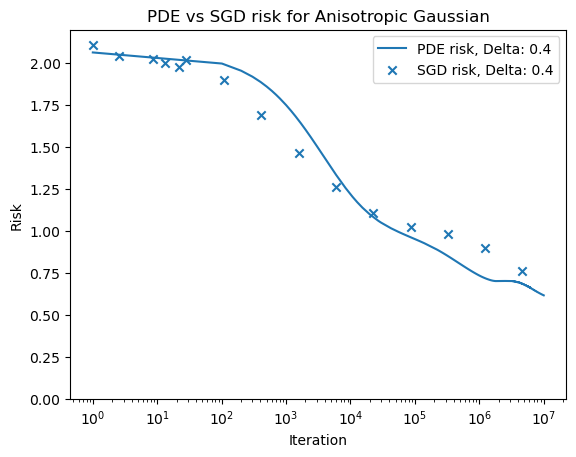

In [235]:
plt.plot(iters, pde_loss(iters),  label = 'PDE risk, Delta: 0.4')
plt.scatter(np.array(indices), risk_SGD, marker = 'x', label = 'SGD risk, Delta: 0.4')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Risk')
plt.legend()
plt.title('PDE vs SGD risk for Anisotropic Gaussian')
plt.ylim([0,2.2])

Text(0.5, 1.0, 'PDE vs SGD Mean value of a for Anisotropic Gaussian')

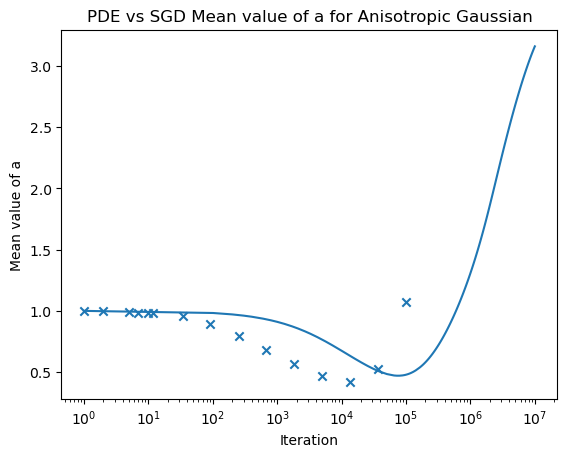

In [236]:
plt.plot(iters, avg_a_pde(iters), label = 'PDE mean value of a, Delta: 0.2')
plt.scatter(np.array(indices), a_SGD, marker = 'x', label = 'SGD mean value of b, Delta: 0.2')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Mean value of a')
plt.title('PDE vs SGD Mean value of a for Anisotropic Gaussian')

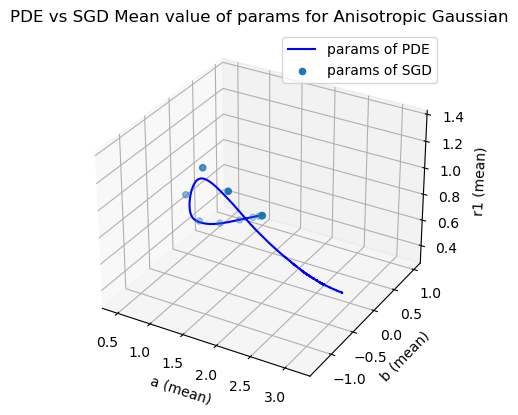

In [212]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(avg_a_pde(iters), avg_b_pde(iters), avg_r1_pde(iters), 'blue', label = 'params of PDE')
ax.scatter(a_SGD, b_SGD, r1_SGD, 'blue', label = 'params of SGD')
ax.set_title('3D Line plot')
ax.set_xlabel('a (mean)')
ax.set_ylabel('b (mean)')
ax.set_zlabel('r1 (mean)')
plt.title('PDE vs SGD Mean value of params for Anisotropic Gaussian')
plt.legend()
plt.show()

Text(0.5, 1.0, 'PDE vs SGD Mean value of r1 for Anisotropic Gaussian')

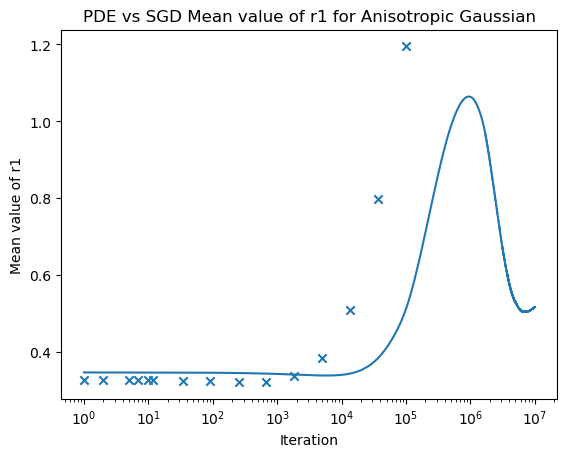

In [237]:
plt.plot(iters, avg_r1_pde(iters), label = 'PDE mean value of r1, Delta: 0.2')
plt.scatter(np.array(indices), r1_SGD, marker = 'x', label = 'SGD mean value of r1, Delta: 0.2')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Mean value of r1')
plt.title('PDE vs SGD Mean value of r1 for Anisotropic Gaussian')